In [1]:
using Plots
using Zygote
using Printf
using JLD2
using DiffEqFlux
using Flux
using OrdinaryDiffEq
using BSON: @load

include("src/utils/graphic_tools.jl")
include("src/neural_ode/models.jl")
include("src/utils/processing_tools.jl")
include("src/utils/generators.jl")
include("src/examples/burgers/analysis.jl")
include("src/examples/burgers/burgers_direct.jl")

Main.BurgersDirect

---
# Hyper-parameter tuning

## Architecture - FNN

In [2]:
ho_nonoise = JLD2.load("./src/examples/burgers/models/feedforward2/hyperopt_result_fnn_nonoise.jld2")["ho"];
ho_05noise = JLD2.load("./src/examples/burgers/models/feedforward2/hyperopt_result_fnn_05noise.jld2")["ho"];
ho_15noise = JLD2.load("./src/examples/burgers/models/feedforward2/hyperopt_result_fnn_15noise.jld2")["ho"];

┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#2017###hyperopt_objective#425#25} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.LHSampler does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#1188###hyperopt_objective#403#11} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.LHSampler does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#1603###hyperopt_objective#414#18} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia

In [4]:
function get_d_train(ho)
    d = Dict([]);
    x =  [8, 16, 24, 32, 40];
    y = [1, 2, 3, 4, 5];

    for a in x
        for b in y
            d[(b, a)] = 1.;
        end
    end

    for (i, tupl) in enumerate(ho.history)
        d[tupl[1]] = ho.results[i];
    end
    
    return d
end

get_d_train (generic function with 1 method)

In [5]:
using BSON

function get_d_val(ho, dataset, filepath)
    (train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.7, false, false);
    function val_loss(K, p, x, y, t)
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
        ŷ = prob_neuralode(x, p);
        l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
        return l;
    end
    
    function evalcb(K, p, val_loader)
        lval = 0;
        for (x, y, t) in val_loader
            lval += val_loss(K, p, x, y, t[1]);
        end
        lval /= (val_loader.nobs / val_loader.batchsize);
        return lval
    end
    
    d = Dict([]);
    x = [8, 16, 24, 32, 40];  # Remove 56 for no noise and 15% noise
    y = [1, 2, 3, 4, 5];

    for k in y
        for l in x
            d[(k, l)] = 1.;
        end
    end
    
    for (i, tupl) in enumerate(ho.history)
        d[tupl[1]] = ho.results[i];
    end
    
    for (i, tupl) in enumerate(ho.history)
        filename = filepath * string(i) * ".bson"
        BSON.@load filename K p;
        l = evalcb(K, p, val_loader);
        d[tupl[1]] = l;
    end
    
    return d
end

get_d_val (generic function with 1 method)

In [10]:
x =  [8, 16, 24, 32, 40];
y = [1, 2, 3, 4, 5];

d_nonoise = get_d_train(ho_nonoise);
d_05noise = get_d_train(ho_05noise);
d_15noise = get_d_train(ho_15noise);

function f(x, y, d)
    return d[(y, x)];
end

f (generic function with 1 method)

In [24]:
dataset = JLD2.load("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];

In [26]:
d_val_nonoise = get_d_val(ho_nonoise, dataset, "./src/examples/burgers/models/feedforward2/tuning_burgers_fnn_nonoise_iter_");

Dict{Any, Any} with 25 entries:
  (1, 24) => 0.434847
  (5, 40) => 0.328162
  (5, 16) => 0.274743
  (3, 8)  => 0.337051
  (4, 32) => 0.279463
  (3, 24) => 0.281814
  (1, 40) => 0.298571
  (2, 32) => 0.306929
  (1, 16) => 0.309271
  (4, 8)  => 0.4467
  (5, 32) => 0.287703
  (2, 8)  => 0.309244
  (3, 40) => 0.432417
  (4, 24) => 0.274295
  (3, 16) => 0.337587
  (2, 24) => 0.328737
  (1, 32) => 0.308375
  (5, 8)  => 0.280309
  (5, 24) => 0.337911
  (4, 40) => 0.291304
  (2, 40) => 0.439751
  (4, 16) => 0.285132
  (1, 8)  => 0.277357
  (2, 16) => 0.440391
  (3, 32) => 0.303693

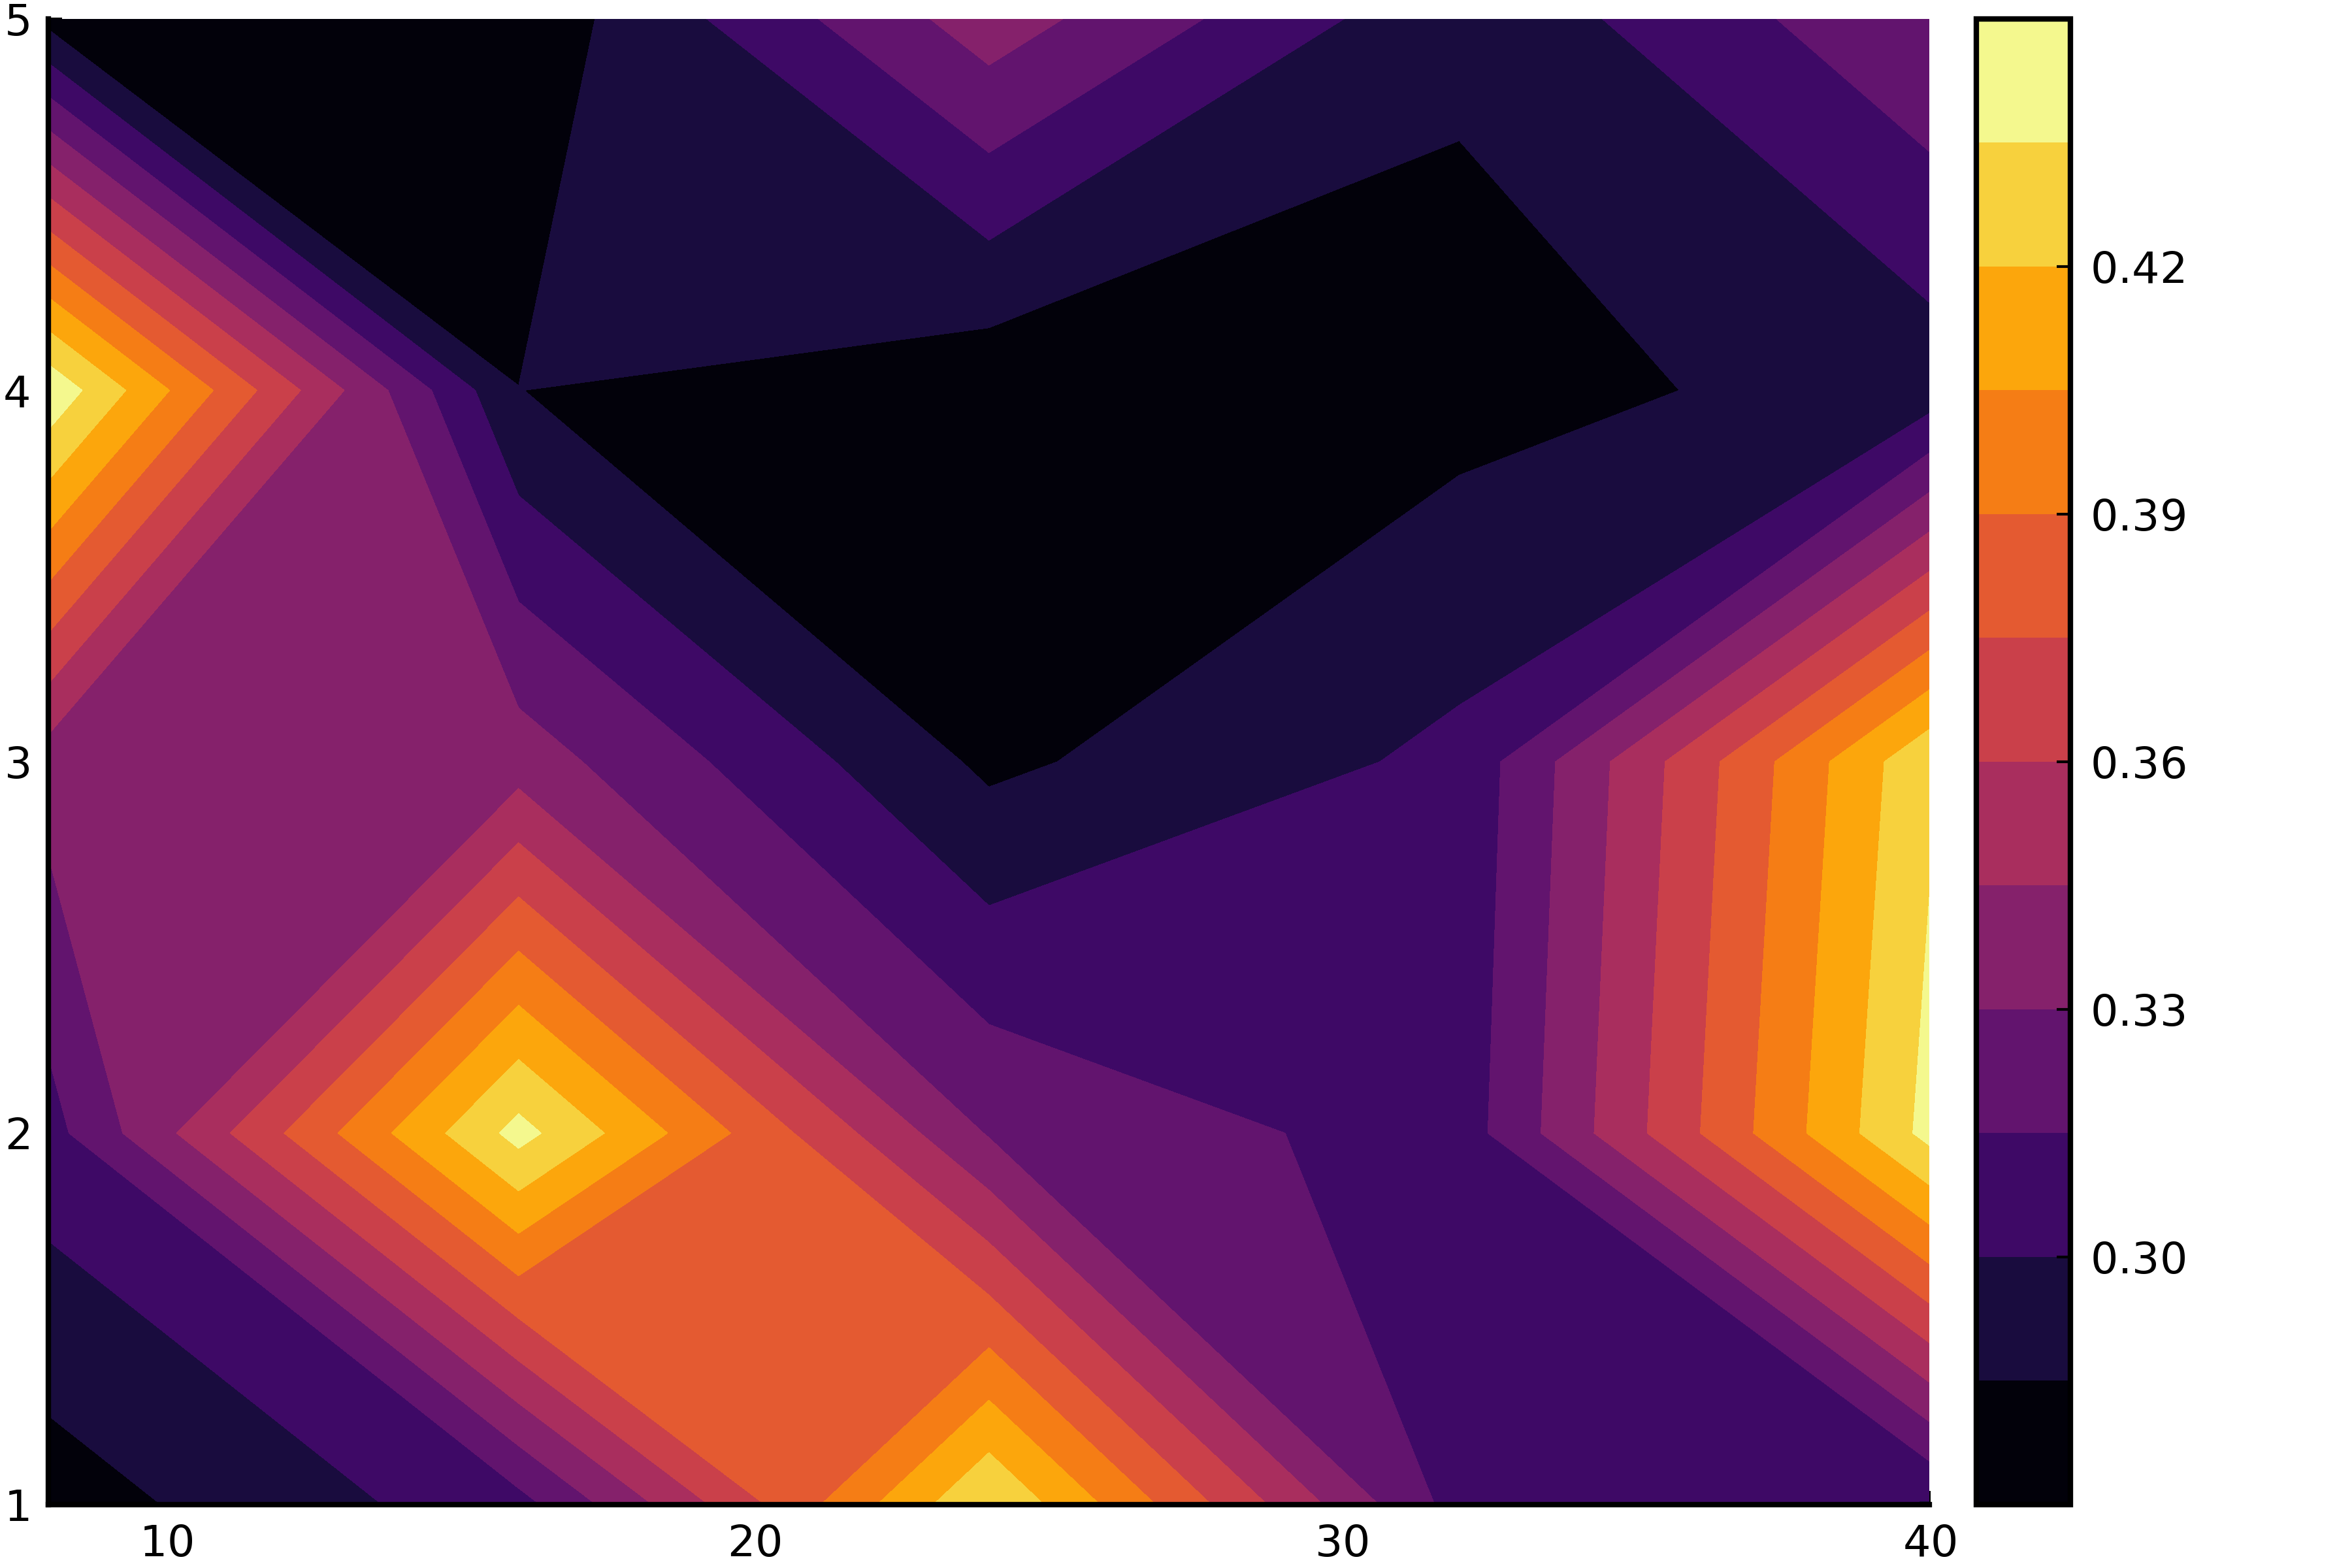

In [27]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_nonoise)), dpi=600)

In [28]:
d_val_05noise = get_d_val(ho_05noise, dataset, "./src/examples/burgers/models/feedforward2/tuning_burgers_fnn_05noise_iter_");

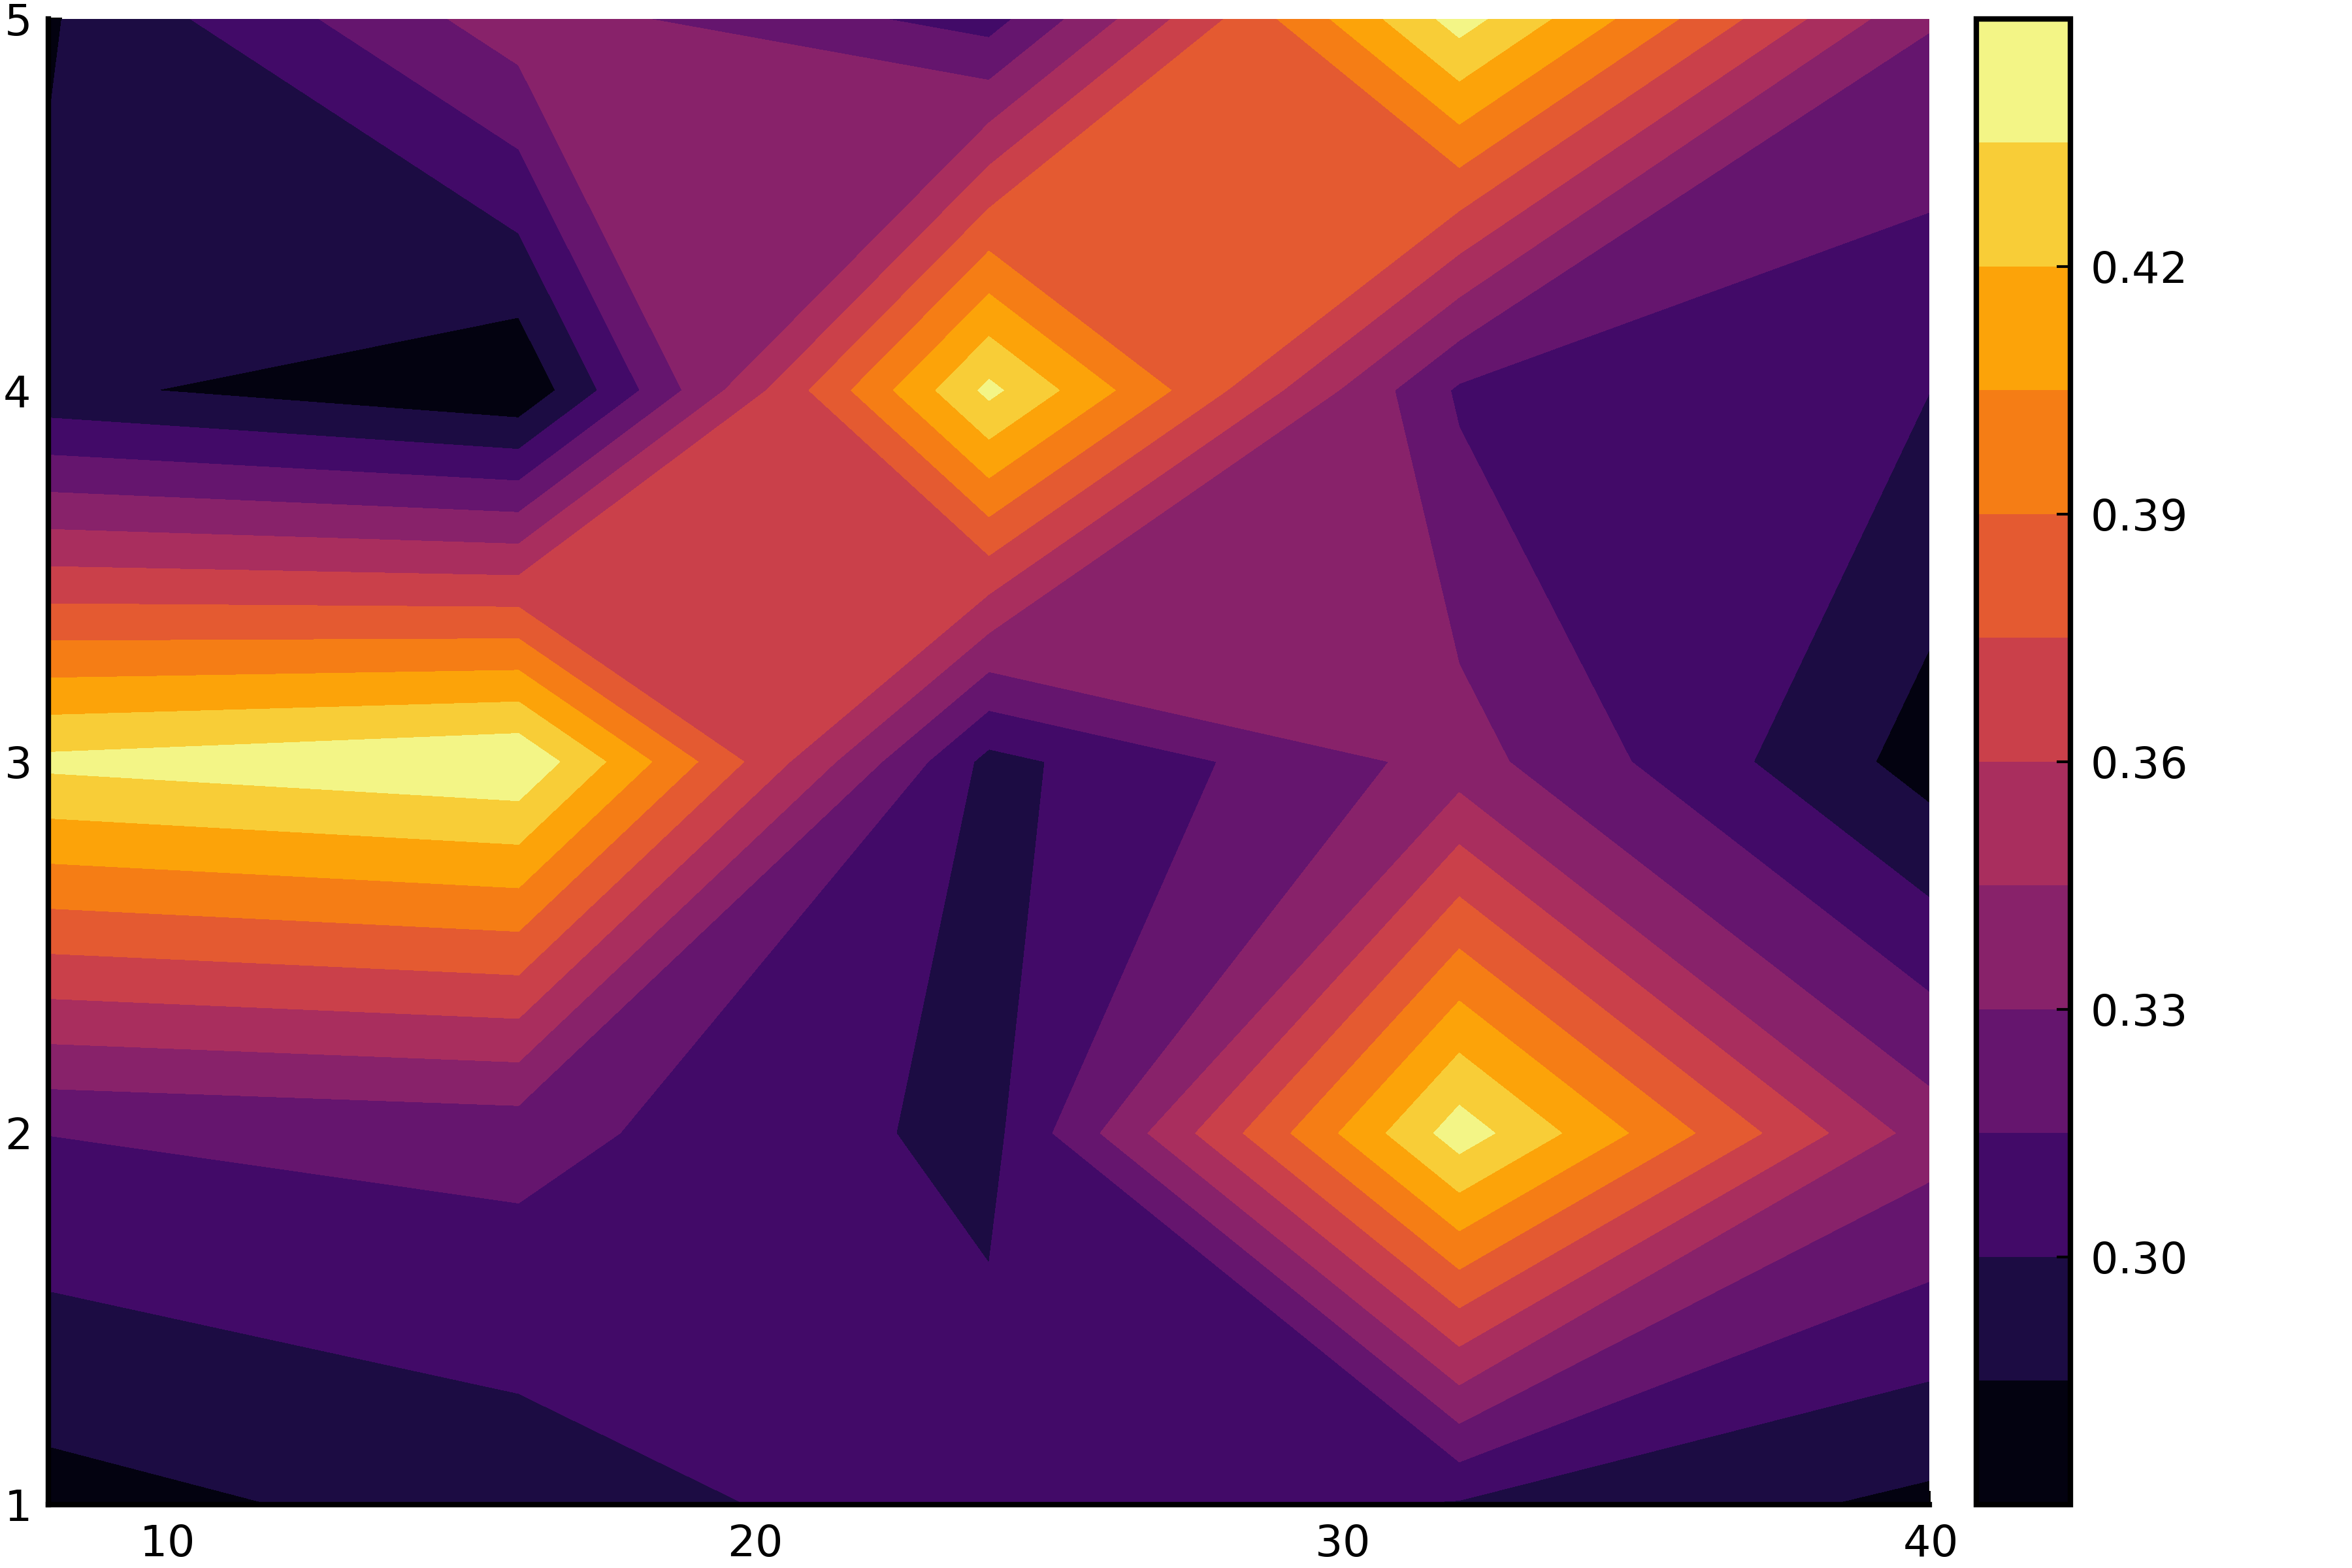

In [30]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_05noise)), dpi=600)

In [31]:
d_val_15noise = get_d_val(ho_15noise, dataset, "./src/examples/burgers/models/feedforward2/tuning_burgers_fnn_15noise_iter_");

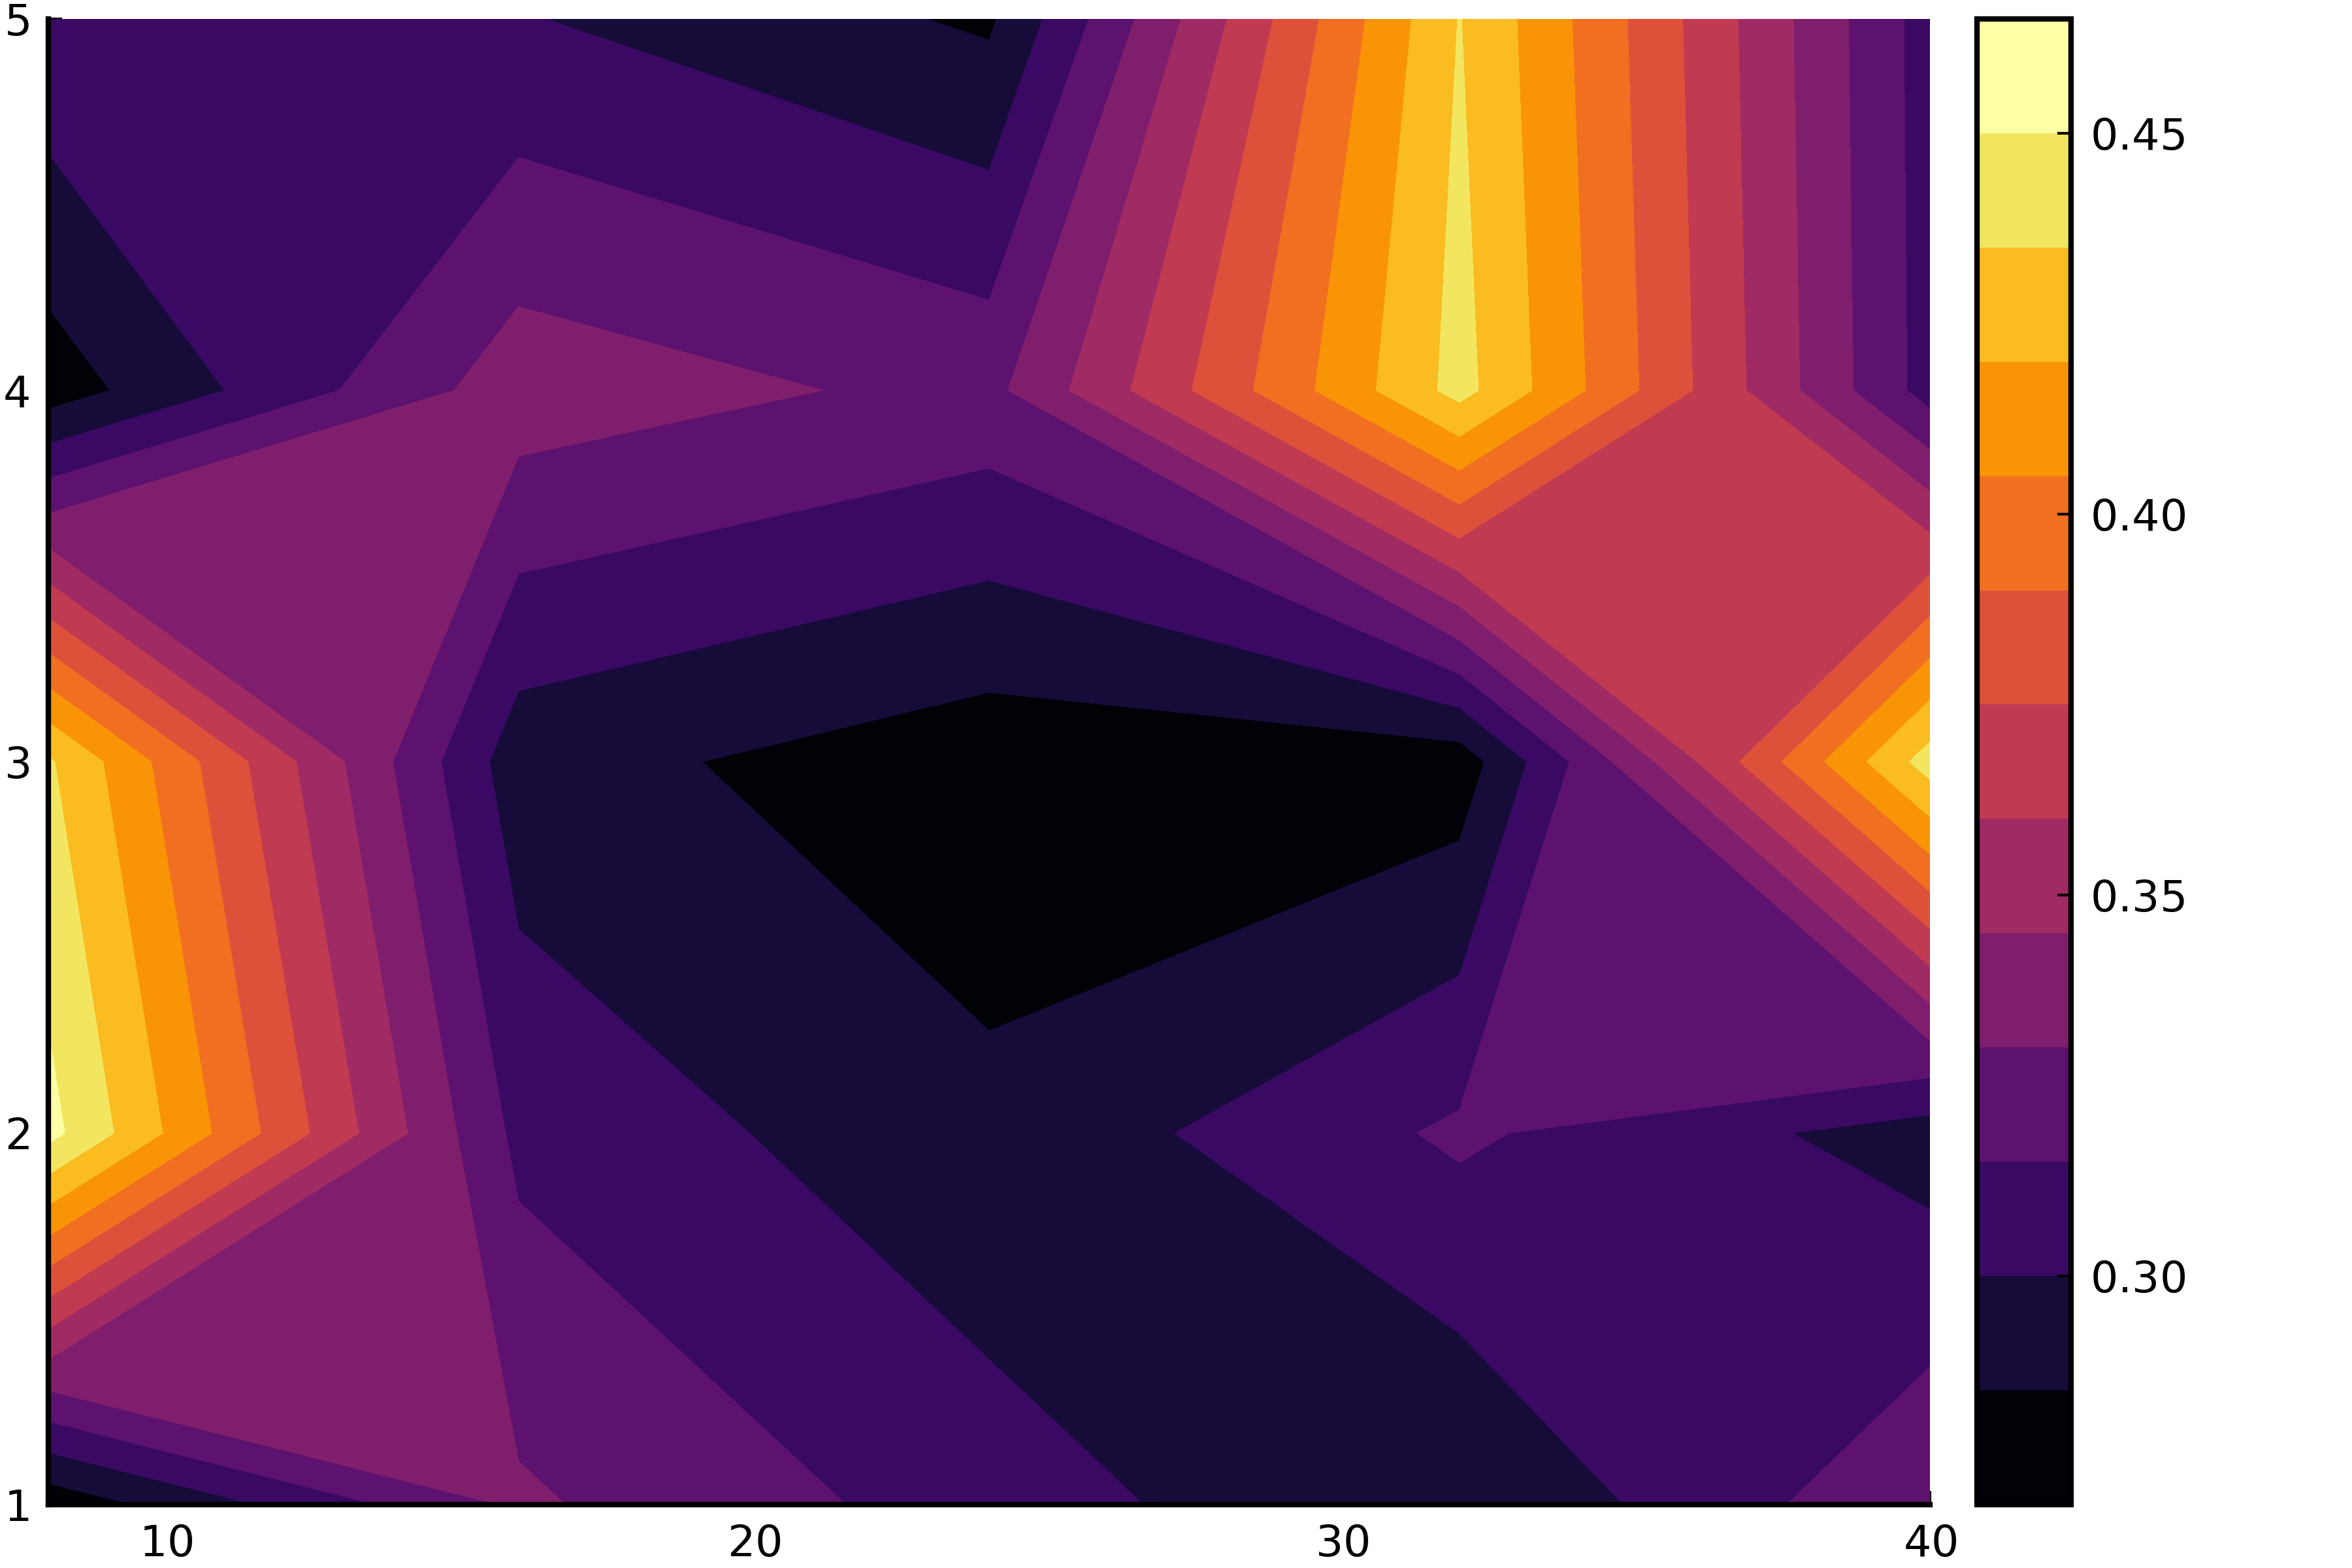

In [32]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_15noise)), dpi=600)

In [4]:
filename = "./src/examples/burgers/models/feedforward4/tuning_burgers_fnn_worker_47_iter_46.bson"
@load filename K p

In [26]:
t, u0, u = Generator.get_burgers_batch(1., 0., pi, 0., 64, 64, 0.04, 2);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
u_pred = prob_neuralode(u0, p);

# display(
#     plot(
#         GraphicTools.show_state(u, ""),
#         GraphicTools.show_state(hcat(u_pred.u...), ""),
#         GraphicTools.show_err(hcat(u_pred.u...), u, "");
#         layout = (1, 3),
#         dpi=600
#     )
# )

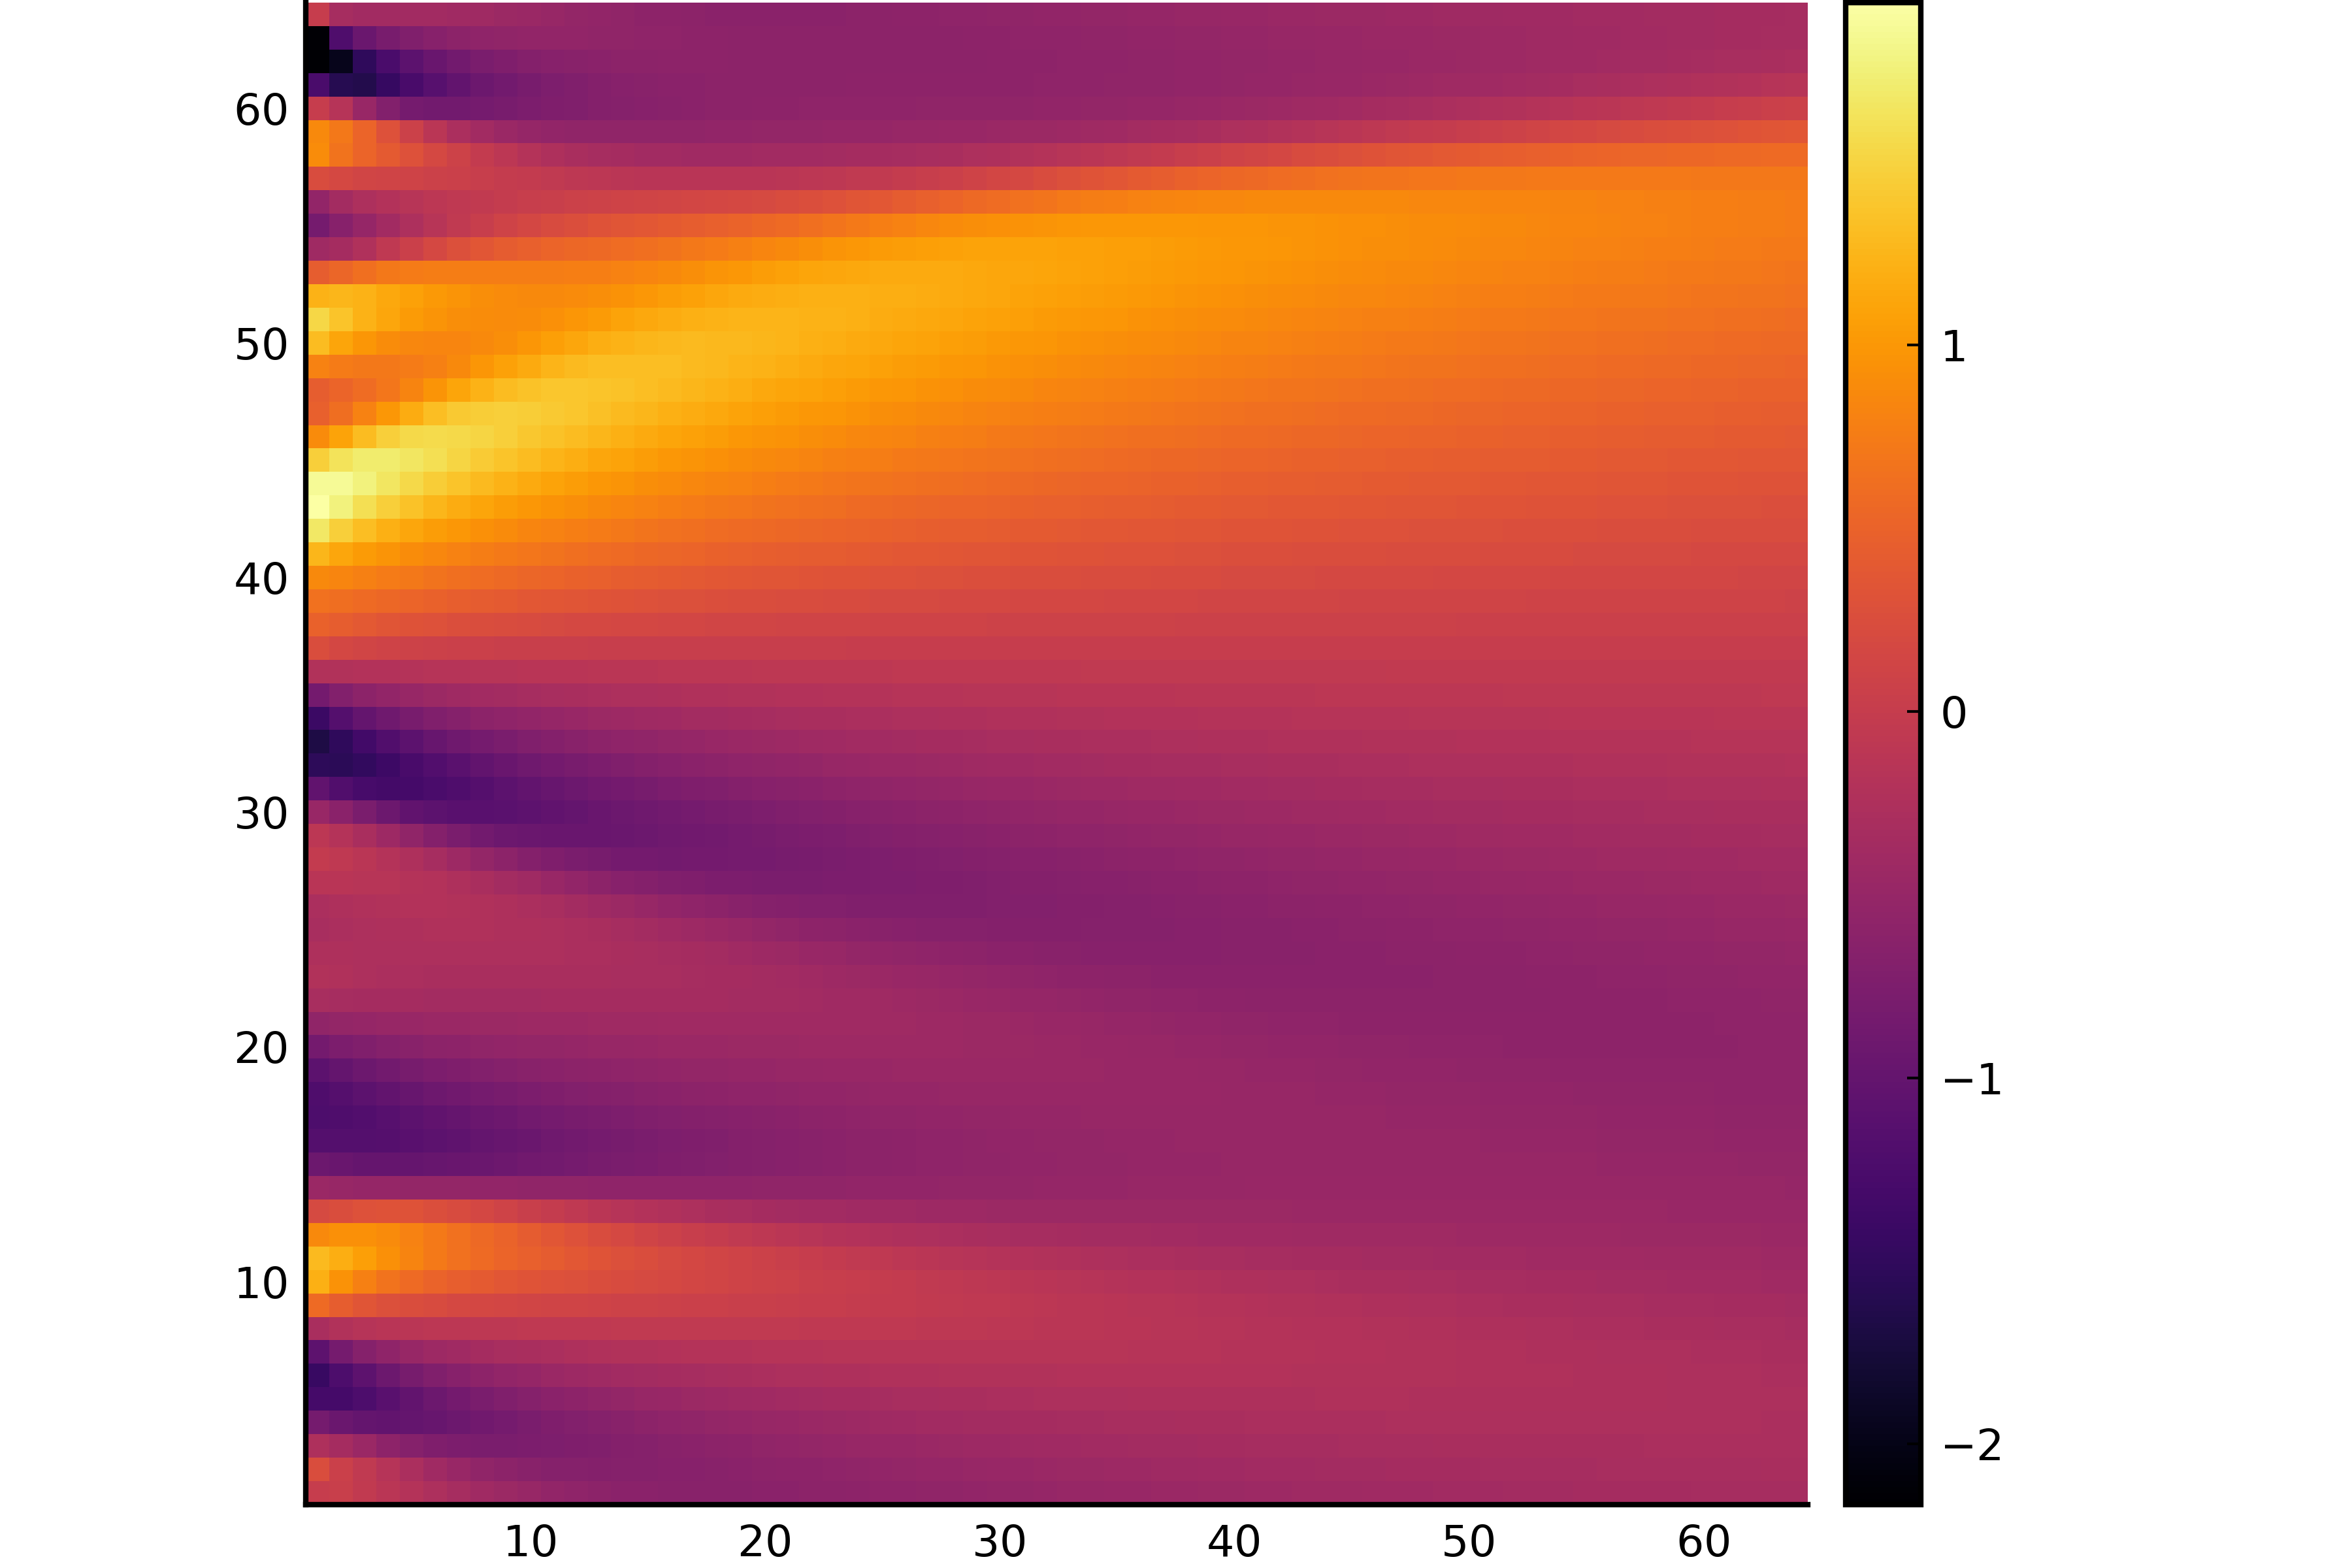

In [27]:
GraphicTools.show_state(u, "")

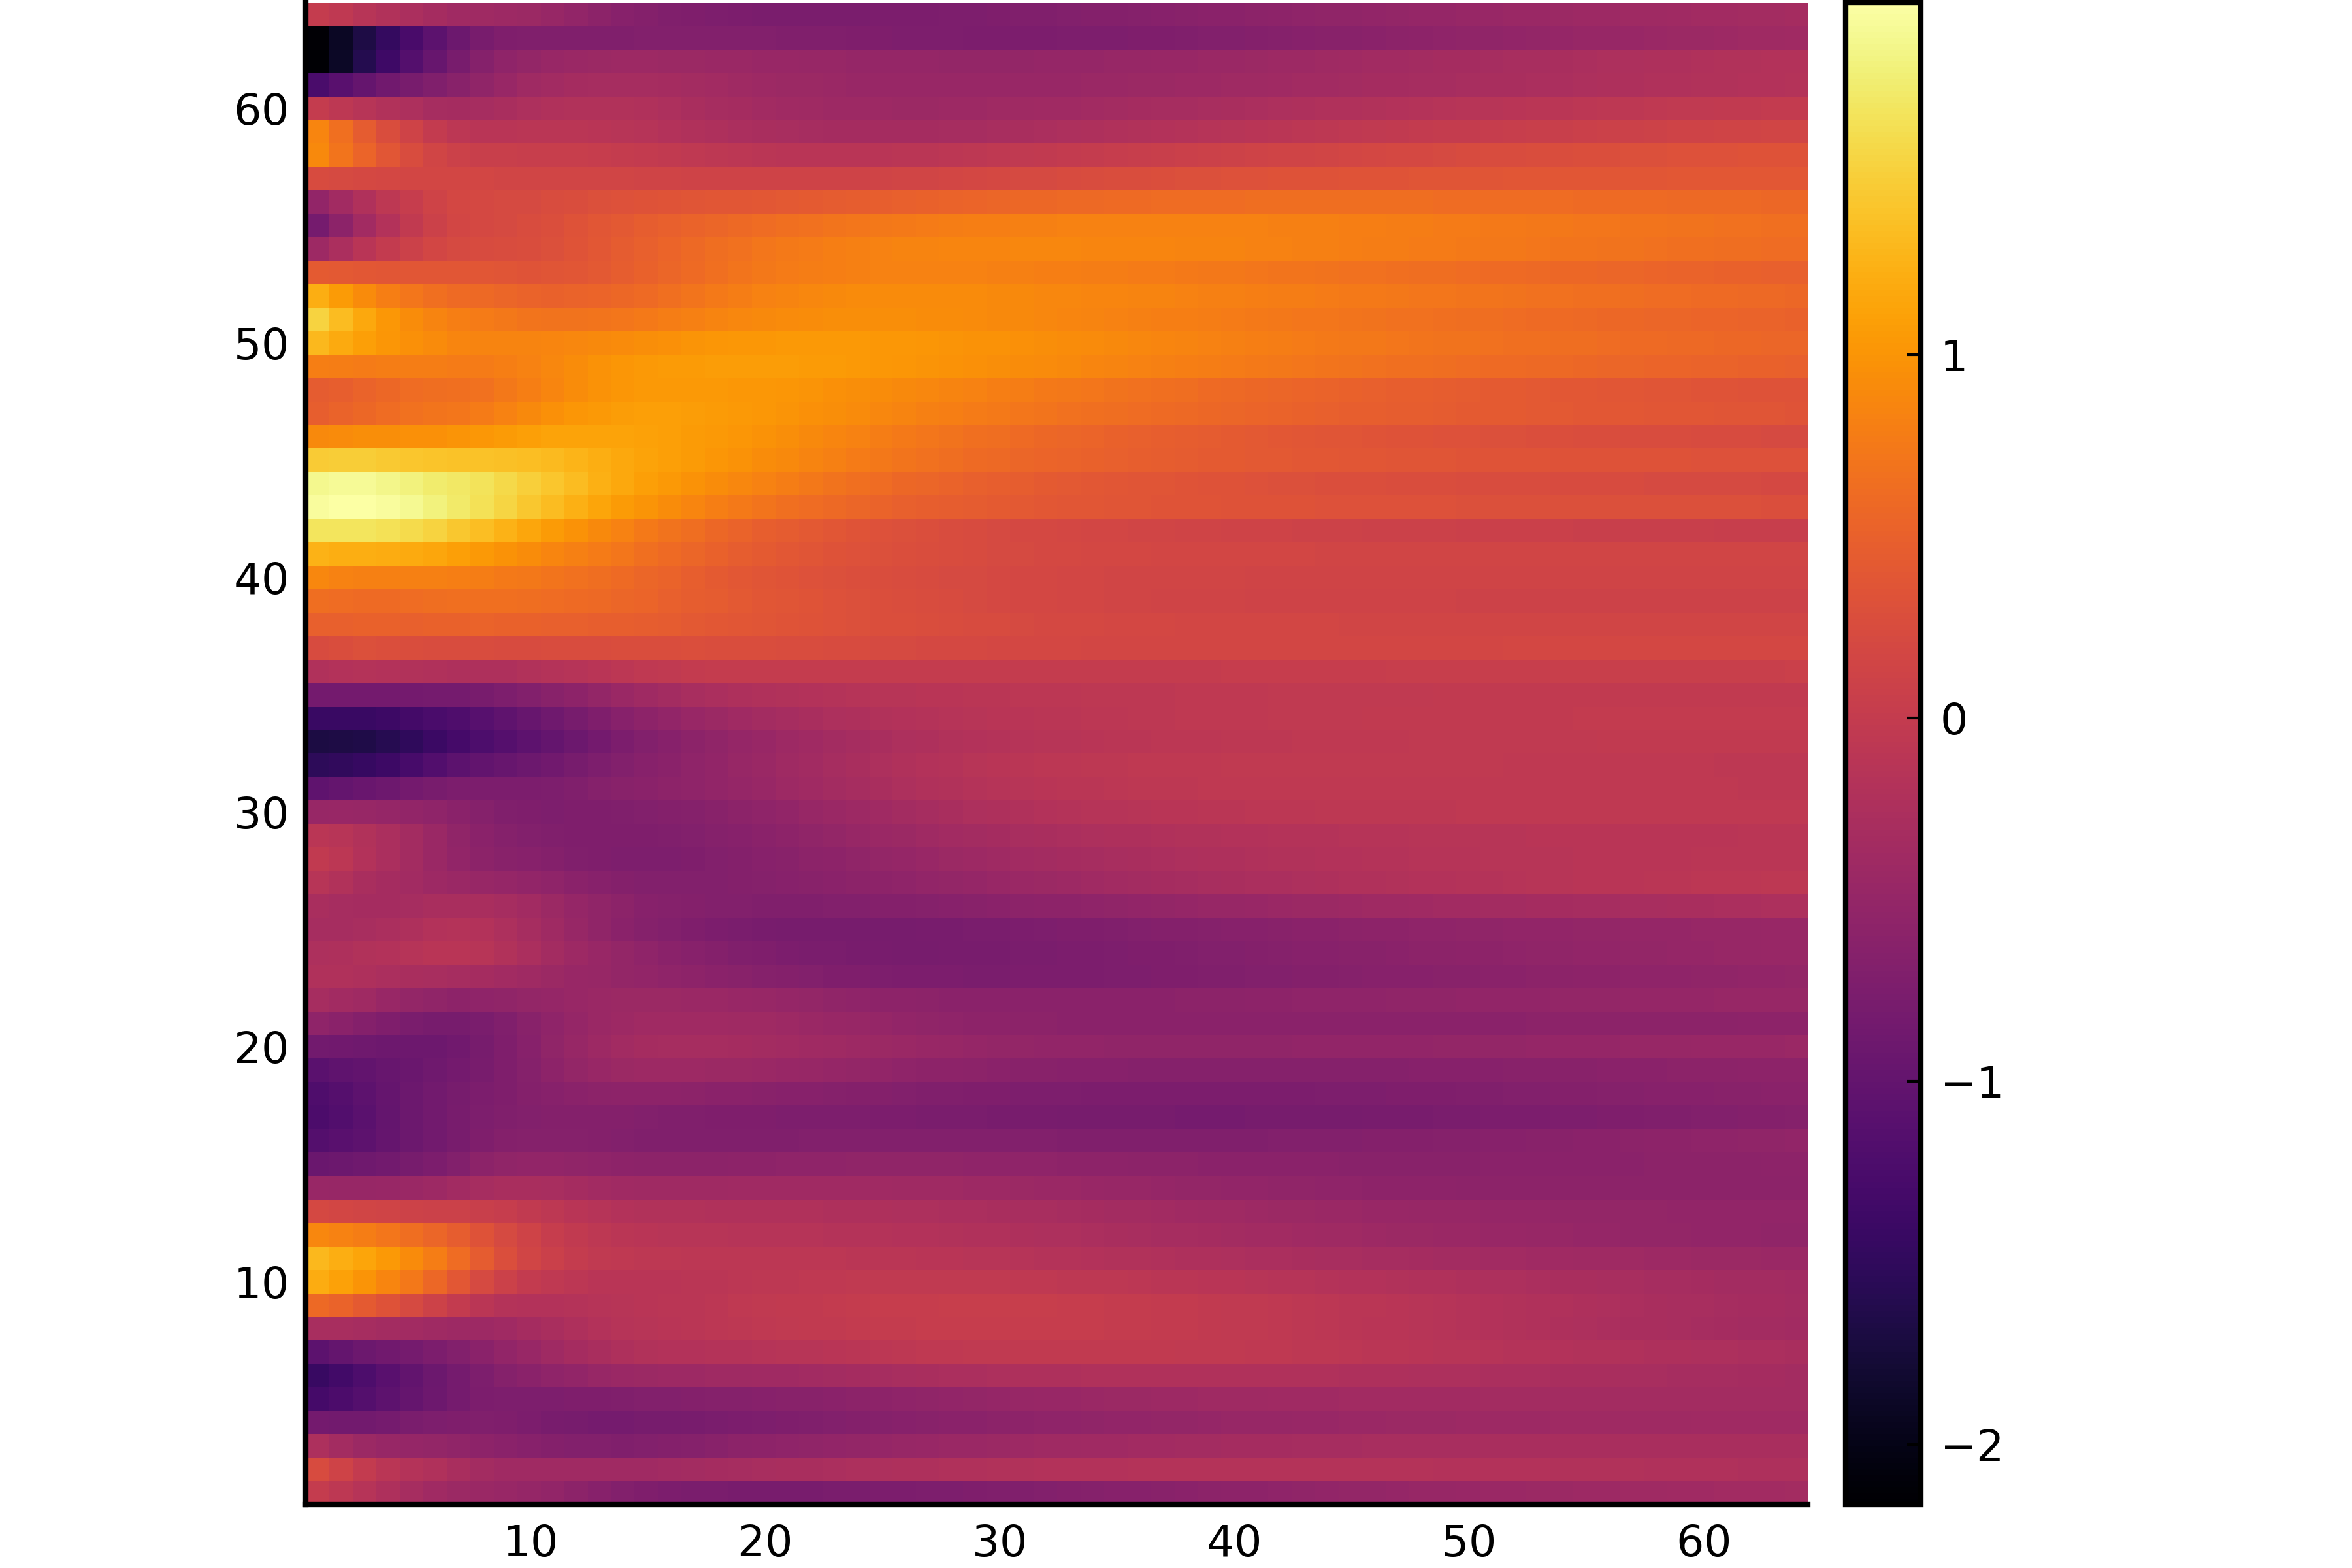

In [28]:
GraphicTools.show_state(hcat(u_pred.u...), "")

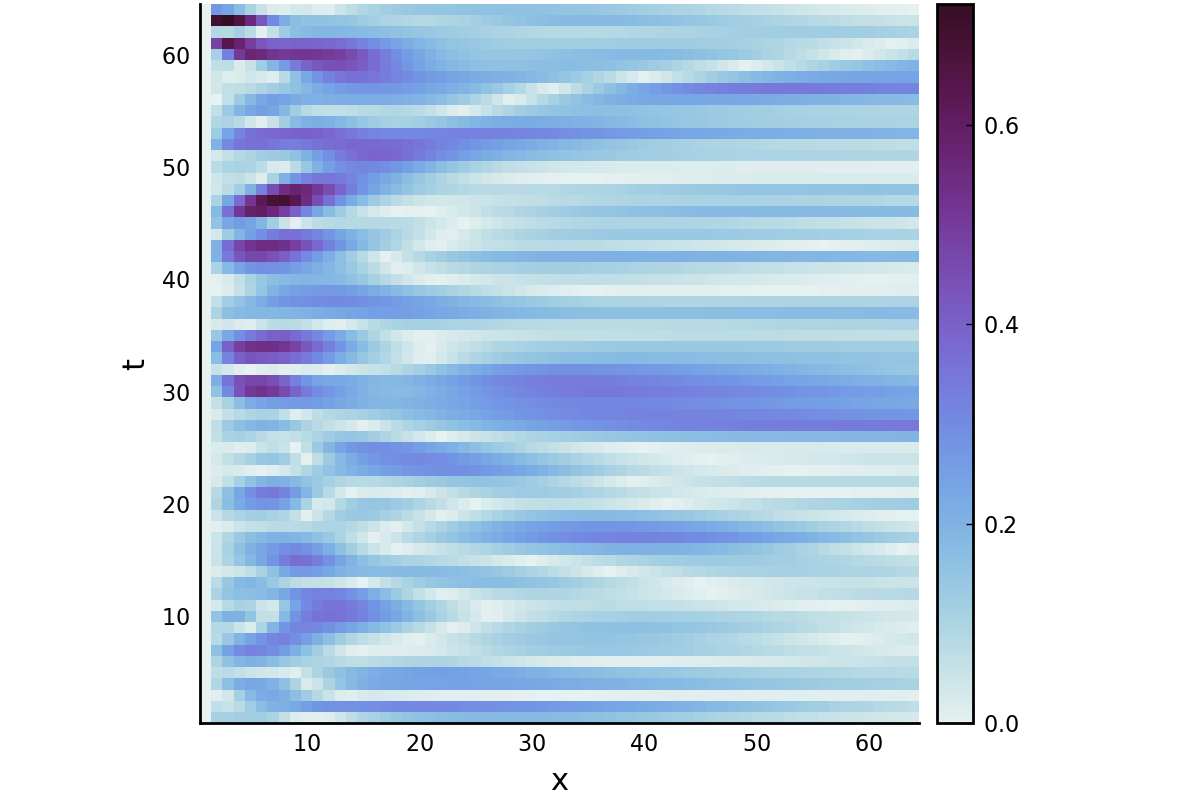

In [29]:
GraphicTools.show_err(hcat(u_pred.u...), u, "")

## Tuning - Regularization

Check the training and validation cost function after training neural network for different $L_2$ regularization parameters. Consider case with Gaussian noise added to prediction.

In [2]:
ho = JLD2.load("./src/examples/burgers/models/feedforward4/hyperopt_result_fnn.jld2")["ho"];

┌ Warning: type Hyperopt.RandomSampler{Random.MersenneTwister} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{JLD2.ReconstructedTypes.var"##Hyperopt.RandomSampler{Random.MersenneTwister}#334",Main.#1744###hyperopt_objective#411#18} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461


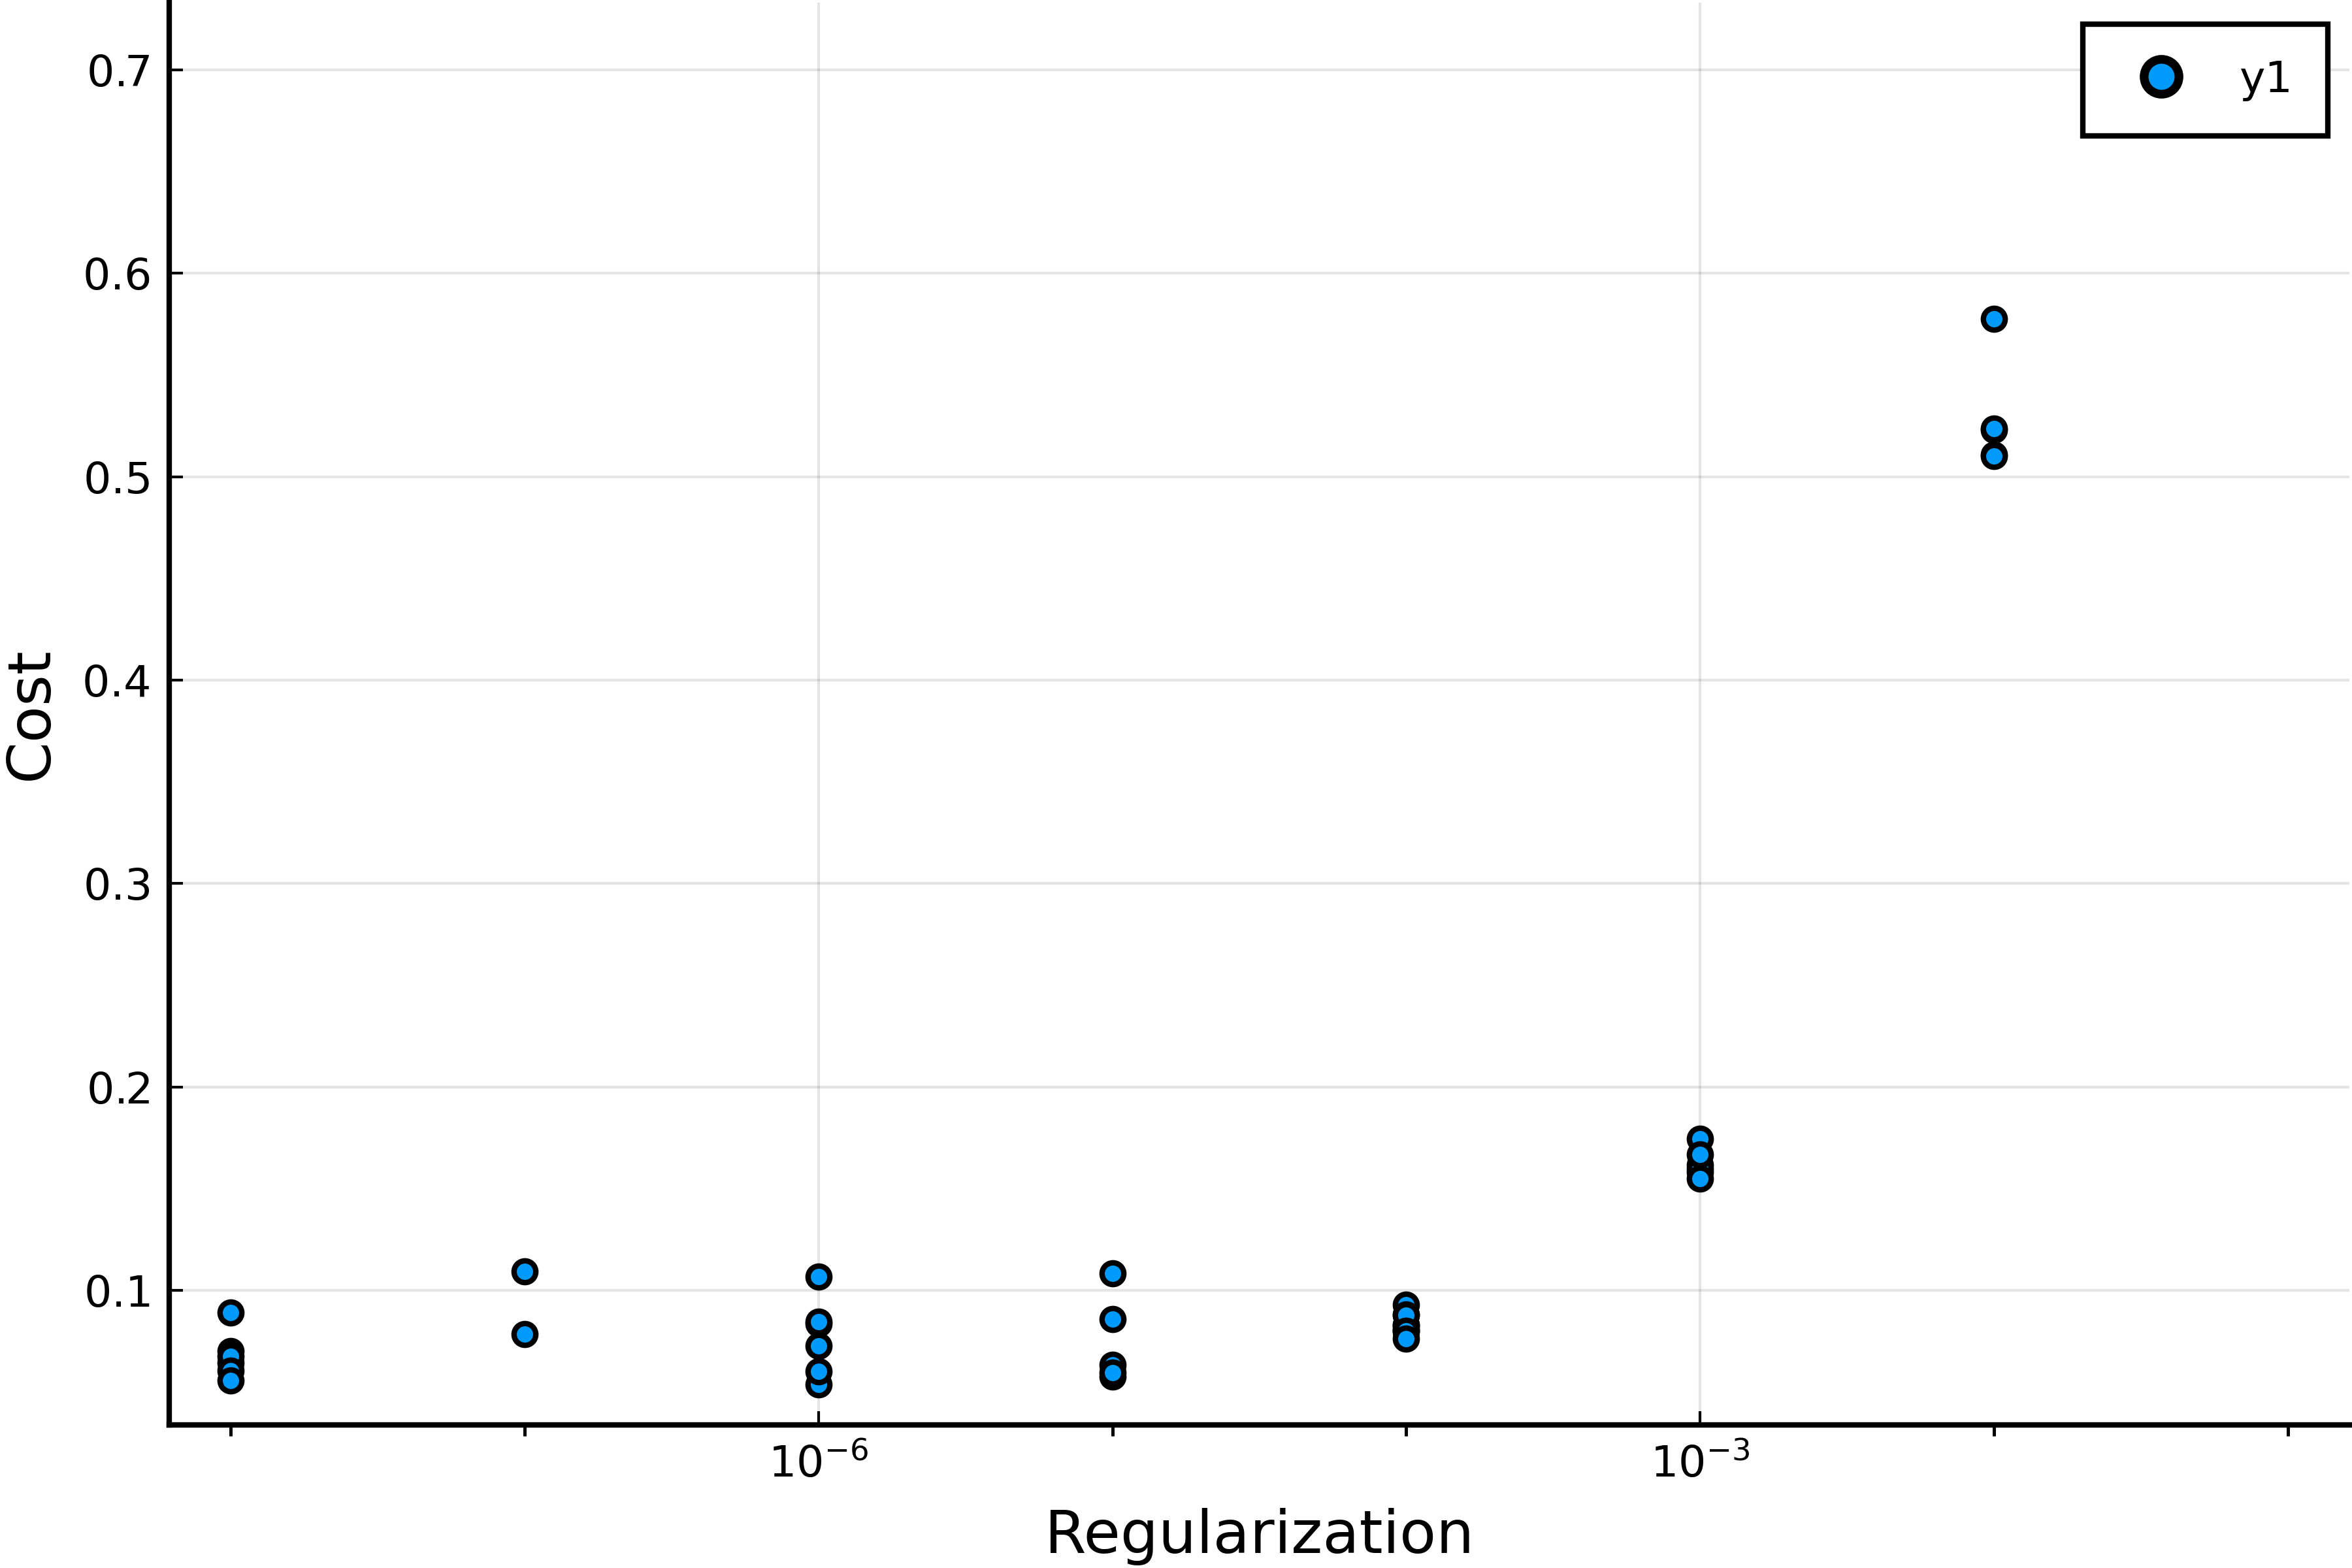

In [20]:
ho.history;

function get_reg(ho)
    x = [];
    y = [];

    for (i, tupl) in enumerate(ho.history)
        push!(x, tupl[3]);
        push!(y, ho.results[i]);
    end
    
    return x, y
end

using BSON

function get_reg_val(ho, dataset, filepath)
    x = [];
    y = [];
    
    (_, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.7, false, false);
    
    function val_loss(K, p, x, y, t)
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
        ŷ = prob_neuralode(x, p);
        l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
        return l;
    end
    
    function evalcb(K, p, val_loader)
        lval = 0;
        for (x, y, t) in val_loader
            lval += val_loss(K, p, x, y, t[1]);
        end
        lval /= (val_loader.nobs / val_loader.batchsize);
        return lval
    end
    
    for (i, tupl) in enumerate(ho.history)
        filename = filepath * string(i) * ".bson"
        BSON.@load filename K p;
        lval = evalcb(K, p, val_loader);

        push!(x, tupl[3]);
        push!(y, lval);
    end
    
    return x, y
end

x, y = get_reg(ho);
plt = scatter(x, y)
scatter!(plt; dpi=600, xaxis=:log, xlabel="Regularization", ylabel="Cost")


# print(d)

---
### Training 

In [35]:
function main()
  batch_size = 32;
  epochs = 1000;
  hl = 3;
  ne = 32;
  reg = 1.0e-6;
  n = 0.01
  lr = 0.03;

  data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
  model = Models.FeedForwardNetwork(64, hl, ne);
  K, p = BurgersDirect.training(model, epochs, data, batch_size, 0.7, n, reg);
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:23
┌ Info: Loading dataset
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:30
┌ Info: Building model
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:33
┌ Info: Initiate training
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:80
┌ Info: Epoch 1
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.6292643323421897
lval = 0.5717872138858102
ltrain = 0.6136523740795143
lval = 0.5578341498714086
ltrain = 0.5945961436859267
lval = 0.5452120502926008


┌ Info: Epoch 2
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.578123093945892
lval = 0.5339787447124188
ltrain = 0.5678851930602258
lval = 0.5237587838215959
ltrain = 0.5498950457883464
lval = 0.5142057395231303


┌ Info: Epoch 3
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.5377462234740433
lval = 0.5053087469520244
ltrain = 0.5254062115715763
lval = 0.4966582147176006
ltrain = 0.5131648007609472
lval = 0.4884028737209545


┌ Info: Epoch 4
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.5014415658253566
lval = 0.48020044471207074
ltrain = 0.4919853255710305
lval = 0.4723211441883042
ltrain = 0.4826652471402685
lval = 0.4647848522367385


┌ Info: Epoch 5
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4695368027883169
lval = 0.45749512621972377
ltrain = 0.4613092471475454
lval = 0.45036612159800526
ltrain = 0.4472757420705556
lval = 0.4433251422863803


┌ Info: Epoch 6
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4385373861302826
lval = 0.4364397326042146
ltrain = 0.4337571976535585
lval = 0.4297471117123597
ltrain = 0.41922865746945015
lval = 0.42317086426545647


┌ Info: Epoch 7
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4097024532480924
lval = 0.4168124680026941
ltrain = 0.4015684882443148
lval = 0.4105750830648172
ltrain = 0.3942703759657457
lval = 0.40439494907660256


┌ Info: Epoch 8
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.387490537688535
lval = 0.3983385305855247
ltrain = 0.37638174917529
lval = 0.3924334498974692
ltrain = 0.36972553406805597
lval = 0.38673668978883535


┌ Info: Epoch 9
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3612859736602314
lval = 0.38122577562518845
ltrain = 0.35742848055582593
lval = 0.37579241124422624
ltrain = 0.34840177895375013
lval = 0.3705369603858977


┌ Info: Epoch 10
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3389805457044214
lval = 0.36543667806289504
ltrain = 0.33380343708057764
lval = 0.3604700611150561
ltrain = 0.32866544134357356
lval = 0.35562552738601616


┌ Info: Epoch 11
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.31983910104730434
lval = 0.35090248335836405
ltrain = 0.31589437138832727
lval = 0.3463360055030038
ltrain = 0.30716037936069673
lval = 0.341905253159605


┌ Info: Epoch 12
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3027658043374792
lval = 0.33758883204166984
ltrain = 0.29617117094293083
lval = 0.33337070679234165
ltrain = 0.2925472703361584
lval = 0.3293329887536158


┌ Info: Epoch 13
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2850556254202399
lval = 0.32542861697716685
ltrain = 0.2807300092993323
lval = 0.32162233125611894
ltrain = 0.27641440104463744
lval = 0.317910146492515


┌ Info: Epoch 14
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2699409203992213
lval = 0.3143912935105321
ltrain = 0.26607395511404186
lval = 0.31091612860996465
ltrain = 0.262283032936358
lval = 0.3074716362663346


┌ Info: Epoch 15
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2539163485044331
lval = 0.3040874026103462
ltrain = 0.25260657908405776
lval = 0.3008212521461459
ltrain = 0.24688510499348884
lval = 0.29764561657216737


┌ Info: Epoch 16
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.24460407871235307
lval = 0.29451131707613937
ltrain = 0.24151605384418895
lval = 0.29144086964488664
ltrain = 0.23511600236249397
lval = 0.2885169761361155


┌ Info: Epoch 17
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.23288980780155405
lval = 0.2856690816724449
ltrain = 0.22793479573499711
lval = 0.2829123077365258
ltrain = 0.2239250413163319
lval = 0.28016781401504964


┌ Info: Epoch 18
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.22100393694430778
lval = 0.27749234596343786
ltrain = 0.21645926269750904
lval = 0.2748495533005192
ltrain = 0.2152045394787426
lval = 0.272277875977099


┌ Info: Epoch 19
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2098977703634758
lval = 0.2697559469461678
ltrain = 0.20883568881195053
lval = 0.2672839598248724
ltrain = 0.20398589948962698
lval = 0.26485671715569553


┌ Info: Epoch 20
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.20239577313972926
lval = 0.2624539515428625
ltrain = 0.19891333571795802
lval = 0.2601303622003548
ltrain = 0.1962270628763735
lval = 0.2578213330378825


┌ Info: Epoch 21
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.19308783539635038
lval = 0.2555917772943482
ltrain = 0.1899477153590447
lval = 0.25335301003910654
ltrain = 0.18816967342153942
lval = 0.25113968613488735


┌ Info: Epoch 22
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1855375409169697
lval = 0.2490058696354551
ltrain = 0.1832576599080387
lval = 0.2468320817445635
ltrain = 0.17996800850581096
lval = 0.24470557900697829


┌ Info: Epoch 23
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.17846305112441868
lval = 0.2425777663849175
ltrain = 0.1750166390941253
lval = 0.24045999370743623
ltrain = 0.17237381113254768
lval = 0.23842347880081896


┌ Info: Epoch 24
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.17034408668595707
lval = 0.23635843298964884
ltrain = 0.16732770468300273
lval = 0.23432838426691044
ltrain = 0.1667771562344275
lval = 0.23237346145891513


┌ Info: Epoch 25
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1636726599207173
lval = 0.23042777805161505
ltrain = 0.16187464761792725
lval = 0.22849529728439938
ltrain = 0.1605245006323926
lval = 0.22661137724773156


┌ Info: Epoch 26
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15774659666931815
lval = 0.22469220176056284
ltrain = 0.1555719837432135
lval = 0.22285618863440174
ltrain = 0.1526319271589877
lval = 0.22102877912030786


┌ Info: Epoch 27
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1507874218090155
lval = 0.21929874280069753
ltrain = 0.14840353642332982
lval = 0.21750899320509484
ltrain = 0.1485691795571286
lval = 0.2157253205522674


┌ Info: Epoch 28
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14618243580218598
lval = 0.21403073591176155
ltrain = 0.14484988021240416
lval = 0.21233606388988263
ltrain = 0.1419243815147899
lval = 0.21057623507781778


┌ Info: Epoch 29
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14058935624118588
lval = 0.2087985696152716
ltrain = 0.13844510990184875
lval = 0.20711116625385637
ltrain = 0.13695804892137017
lval = 0.2054241603937542


┌ Info: Epoch 30
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1362789057827005
lval = 0.2037381686384729
ltrain = 0.13371875110920475
lval = 0.20207882179995765
ltrain = 0.1321884303576327
lval = 0.20048536938059716


┌ Info: Epoch 31
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1303688361282932
lval = 0.19889092804277206
ltrain = 0.12927243491141066
lval = 0.19730213321016166
ltrain = 0.1276927462587057
lval = 0.19581523607940304


┌ Info: Epoch 32
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1278508418995258
lval = 0.19443141655583668
ltrain = 0.1252988109899791
lval = 0.19300000128195066
ltrain = 0.12439272366417546
lval = 0.1915720499674691


┌ Info: Epoch 33
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12164707502843745
lval = 0.1901827771112399
ltrain = 0.12103414659064791
lval = 0.18884853718790515
ltrain = 0.11847961483639903
lval = 0.18747352662868022


┌ Info: Epoch 34
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1176304088428312
lval = 0.18609349649874593
ltrain = 0.11707569407585906
lval = 0.18469959966358304
ltrain = 0.11554120290092292
lval = 0.18342785089275002


┌ Info: Epoch 35
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1146971439637665
lval = 0.1821840754211843
ltrain = 0.11312990008283007
lval = 0.18095436717770563
ltrain = 0.11216584003548584
lval = 0.17973948330161166


┌ Info: Epoch 36
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11145569063220988
lval = 0.17852442839069302
ltrain = 0.10978094218676276
lval = 0.17737488525627085
ltrain = 0.1081325875197881
lval = 0.17619262423299262


┌ Info: Epoch 37
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10767754283338726
lval = 0.17507654541303036
ltrain = 0.10666927591924065
lval = 0.17390205092289976
ltrain = 0.10506834248624074
lval = 0.1727609463415469


┌ Info: Epoch 38
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10454526408535152
lval = 0.17159966862936346
ltrain = 0.10356527017008688
lval = 0.17048803544237814
ltrain = 0.1019124139238144
lval = 0.1694130454762889


┌ Info: Epoch 39
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10213230209223362
lval = 0.16841250832494692
ltrain = 0.1001749809409953
lval = 0.16737395082284345
ltrain = 0.09953729006900414
lval = 0.16637076217948418


┌ Info: Epoch 40
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09948969630475998
lval = 0.16541340597087925
ltrain = 0.09887656869959022
lval = 0.164446566221251
ltrain = 0.0972220537874411
lval = 0.1635142197834006


┌ Info: Epoch 41
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09629572678148772
lval = 0.16258887555960663
ltrain = 0.09588103003613807
lval = 0.1617564455512428
ltrain = 0.09528742420716997
lval = 0.1608347251596232


┌ Info: Epoch 42
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09464937874983327
lval = 0.1600167734841571
ltrain = 0.0929290805966165
lval = 0.15916045962461398
ltrain = 0.09307333004306287
lval = 0.15825326815479596


┌ Info: Epoch 43
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09196773819220362
lval = 0.1574458550914235
ltrain = 0.09100645894485887
lval = 0.15652313278718288
ltrain = 0.09190785908292508
lval = 0.1556815010280271


┌ Info: Epoch 44
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08983589737198974
lval = 0.1548632328864004
ltrain = 0.08859687928797641
lval = 0.1540623137395248
ltrain = 0.08897786185430867
lval = 0.1532772288013858


┌ Info: Epoch 45
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0883785874860158
lval = 0.1524444927413988
ltrain = 0.08688307288248269
lval = 0.15170692478212106
ltrain = 0.08684805683044142
lval = 0.15097691005170882


┌ Info: Epoch 46
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08556032368103926
lval = 0.15032248149868777
ltrain = 0.08539383398439977
lval = 0.14962906280996804
ltrain = 0.08566488055298022
lval = 0.14894991525236032


┌ Info: Epoch 47
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08403069090349018
lval = 0.14830139344480203
ltrain = 0.08381950045402985
lval = 0.1476286872512344
ltrain = 0.08288970832403265
lval = 0.1469722474295363


┌ Info: Epoch 48
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08225754162959843
lval = 0.14640740702556898
ltrain = 0.08199583402726995
lval = 0.145784122760284
ltrain = 0.08167758530249364
lval = 0.1451123188438931


┌ Info: Epoch 49
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08102411627226418
lval = 0.14446012479563672
ltrain = 0.08045784771999161
lval = 0.14377935005773554
ltrain = 0.08015949588024197
lval = 0.14316105044172556


┌ Info: Epoch 50
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07935724962824711
lval = 0.14262102784325226
ltrain = 0.0788330960462286
lval = 0.14202595431033807
ltrain = 0.07796415514199541
lval = 0.14145543230678134


┌ Info: Epoch 51
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07807518065032924
lval = 0.14090778573707644
ltrain = 0.07757093469251523
lval = 0.1403414522844197
ltrain = 0.07698380171588762
lval = 0.13981219727120245


┌ Info: Epoch 52
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07633313506507303
lval = 0.13928078153680992
ltrain = 0.07606180277597267
lval = 0.1387362732714083
ltrain = 0.07608044872794226
lval = 0.1382268908113014


┌ Info: Epoch 53
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07505223064556817
lval = 0.13771121926843988
ltrain = 0.07440309241002442
lval = 0.13725925876431555
ltrain = 0.07442010829697784
lval = 0.1367339017041954


┌ Info: Epoch 54
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07395280510861954
lval = 0.1362101826826776
ltrain = 0.07389098676884365
lval = 0.13573069511950128
ltrain = 0.07308637705619539
lval = 0.13521465573008623


┌ Info: Epoch 55
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07334132177193504
lval = 0.1346950242342999
ltrain = 0.07251770631294908
lval = 0.13428354900832917
ltrain = 0.07194542690649891
lval = 0.1338139190307024


┌ Info: Epoch 56
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07187917363231308
lval = 0.13341200446497015
ltrain = 0.07150407303625014
lval = 0.13300338602852757
ltrain = 0.07032378688029252
lval = 0.1325886297036548


┌ Info: Epoch 57
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07036515268880608
lval = 0.13222361451000858
ltrain = 0.06981888224487781
lval = 0.1317717152466536
ltrain = 0.06933043418155399
lval = 0.13140357790509147


┌ Info: Epoch 58
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06906015695723598
lval = 0.1311889353910791
ltrain = 0.06903894706722674
lval = 0.1309444175399848
ltrain = 0.06876607180116656
lval = 0.13049630107918753


┌ Info: Epoch 59
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06906597862749969
lval = 0.1300527640252594
ltrain = 0.06832845673291696
lval = 0.1295446580357459
ltrain = 0.06735032242002925
lval = 0.12912094164828616


┌ Info: Epoch 60
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06668245454847951
lval = 0.12874545457137002
ltrain = 0.06662057392795673
lval = 0.12841129581340846
ltrain = 0.0665828331242972
lval = 0.1280099385980813


┌ Info: Epoch 61
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06621167056811307
lval = 0.12762419094554786
ltrain = 0.06620896371427379
lval = 0.12722589805236248
ltrain = 0.06583690472871907
lval = 0.12690943777290276


┌ Info: Epoch 62
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06501805906618334
lval = 0.12657554045511904
ltrain = 0.06567337068635432
lval = 0.1263770547927404
ltrain = 0.06509052430879181
lval = 0.12608422935334773


┌ Info: Epoch 63
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06446252756522824
lval = 0.12588280187175174
ltrain = 0.06431422153939263
lval = 0.12564558072936965
ltrain = 0.06392443315237005
lval = 0.12527321548271117


┌ Info: Epoch 64
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0633537759621818
lval = 0.12483094655841687
ltrain = 0.06342881866502946
lval = 0.124380084055905
ltrain = 0.06332618035553984
lval = 0.12407865845896399


┌ Info: Epoch 65
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06279686452762295
lval = 0.12376925894037352
ltrain = 0.062776140294256
lval = 0.12349234626458853
ltrain = 0.06298610270402905
lval = 0.12329528935675198


┌ Info: Epoch 66
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06242702942246901
lval = 0.12317926247682956
ltrain = 0.06188532020052089
lval = 0.12301040332507011
ltrain = 0.0615147197692181
lval = 0.12281263078517368


┌ Info: Epoch 67
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06128207095946979
lval = 0.1225304885516234
ltrain = 0.06099808291995971
lval = 0.12221715326179965
ltrain = 0.060514802164659896
lval = 0.12203837894487965


┌ Info: Epoch 68
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06068506684348983
lval = 0.12192347196696844
ltrain = 0.06057179024669954
lval = 0.12185007503338334
ltrain = 0.060373052449294154
lval = 0.12155266916010583


┌ Info: Epoch 69
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0600318136683806
lval = 0.12125760868919266
ltrain = 0.05973041877783679
lval = 0.12087217558147269
ltrain = 0.05946945289854925
lval = 0.12057812487381812


┌ Info: Epoch 70
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.059318077305792784
lval = 0.12044518473516337
ltrain = 0.05881230855514312
lval = 0.12022964611996355
ltrain = 0.05910564920324662
lval = 0.11995188859639977


┌ Info: Epoch 71
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05869004611375171
lval = 0.11982008686867263
ltrain = 0.05835623893492082
lval = 0.1195850699251132
ltrain = 0.05829251108410893
lval = 0.11935393804381861


┌ Info: Epoch 72
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05839551262087253
lval = 0.11904449274931621
ltrain = 0.05802172653776285
lval = 0.1187342848984879
ltrain = 0.057407662112063704
lval = 0.11862940977421808


┌ Info: Epoch 73
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.057811421199097275
lval = 0.11876840252755143
ltrain = 0.05724404610606815
lval = 0.11888006981644186
ltrain = 0.057005757114814995
lval = 0.11856589331992505


┌ Info: Epoch 74
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05668918761944429
lval = 0.11822760894503066
ltrain = 0.056972190404215105
lval = 0.11767516477997625
ltrain = 0.05670692208317871
lval = 0.11737365272503934


┌ Info: Epoch 75
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.056297934569415
lval = 0.11723801267265396
ltrain = 0.05609295372216081
lval = 0.11710255267286822
ltrain = 0.05585127555095655
lval = 0.11690686888339782


┌ Info: Epoch 76
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05578222108938812
lval = 0.11667031119099391
ltrain = 0.05532249596320294
lval = 0.11650698327619065
ltrain = 0.055928456017591506
lval = 0.11641994676773736


┌ Info: Epoch 77
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05566310703162371
lval = 0.11645946441836534
ltrain = 0.05542563874851736
lval = 0.11643288711414186
ltrain = 0.054712678499308234
lval = 0.1162580137502267


┌ Info: Epoch 78
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0550016780694032
lval = 0.1161693780975441
ltrain = 0.05408697389785553
lval = 0.11606724926826435
ltrain = 0.05381746468050746
lval = 0.11571110594587462


┌ Info: Epoch 79
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05414337938246856
lval = 0.11533346440079241
ltrain = 0.05404227718429186
lval = 0.11508991720557137
ltrain = 0.05414092022868892
lval = 0.11484354343432122


┌ Info: Epoch 80
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.053559262044097146
lval = 0.11467464221445973
ltrain = 0.05365097394037891
lval = 0.11454346787838493
ltrain = 0.053833504385954384
lval = 0.11445162575791874


┌ Info: Epoch 81
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.053847427839202135
lval = 0.11434015929369955
ltrain = 0.052997038674562014
lval = 0.11417235284086939
ltrain = 0.05248934588274526
lval = 0.1140539739154283


┌ Info: Epoch 82
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05241841654908749
lval = 0.11393674147906963
ltrain = 0.052623151366374334
lval = 0.1137742214956992
ltrain = 0.052684406590369624
lval = 0.11364343970143427


┌ Info: Epoch 83
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05244866312174569
lval = 0.11347132332760855
ltrain = 0.052041131093529376
lval = 0.11323689832701259
ltrain = 0.05199890826574504
lval = 0.11317041534258206


┌ Info: Epoch 84
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.051722816812483134
lval = 0.11312929880038808
ltrain = 0.05199452032960507
lval = 0.11324205034847568
ltrain = 0.051695141582378354
lval = 0.113076356223466


┌ Info: Epoch 85
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0516723232417247
lval = 0.11299522426062732
ltrain = 0.05058242943680525
lval = 0.11270938246925415
ltrain = 0.05057628682116794
lval = 0.11241775248605941


┌ Info: Epoch 86
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05126980689912549
lval = 0.11215824886254085
ltrain = 0.0506880468660216
lval = 0.11192102492071826
ltrain = 0.05127867809516424
lval = 0.11182470093839611


┌ Info: Epoch 87
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05064093252514195
lval = 0.11186389123610581
ltrain = 0.05036783792589966
lval = 0.11193638993924247
ltrain = 0.050460631600622634
lval = 0.11186882295462909


┌ Info: Epoch 88
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04967791083467528
lval = 0.11181329252178251
ltrain = 0.04967367376369541
lval = 0.11168310274955029
ltrain = 0.04949281308351064
lval = 0.11142911732372766


┌ Info: Epoch 89
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04989557942631928
lval = 0.11111764141300813
ltrain = 0.049671686659735946
lval = 0.11097770815840481
ltrain = 0.049441795151196406
lval = 0.11086921113253219


┌ Info: Epoch 90
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0493683802030677
lval = 0.11074684546913538
ltrain = 0.04935355403819511
lval = 0.11078559490169572
ltrain = 0.04923313533900808
lval = 0.11076546186379081


┌ Info: Epoch 91
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04865588675201712
lval = 0.11047647747756635
ltrain = 0.04892564805640027
lval = 0.11032642270976013
ltrain = 0.048809033083152736
lval = 0.11038115907441358


┌ Info: Epoch 92
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04841494670940509
lval = 0.1105623559508981
ltrain = 0.04828746588595207
lval = 0.1106579846666769
ltrain = 0.04794887292772575
lval = 0.11058821806662002


┌ Info: Epoch 93
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04811378273729132
lval = 0.11049245546532456
ltrain = 0.04820106079085069
lval = 0.11027278785312464
ltrain = 0.04765363356375041
lval = 0.11004380929384641


┌ Info: Epoch 94
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04748620938882502
lval = 0.11002531063075571
ltrain = 0.04759519654965473
lval = 0.10999430571398632
ltrain = 0.047077368413762616
lval = 0.10988989715810915


┌ Info: Epoch 95
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04757272779590428
lval = 0.10984271671405753
ltrain = 0.04727347675143883
lval = 0.1098679647972423
ltrain = 0.046923914169832354
lval = 0.10954746935997003


┌ Info: Epoch 96
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04678368421983514
lval = 0.10934916972529977
ltrain = 0.04702668572268768
lval = 0.10934167500024164
ltrain = 0.04640905812453165
lval = 0.1088856847762793


┌ Info: Epoch 97
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04708900701894044
lval = 0.10855921494636218
ltrain = 0.046719486789345954
lval = 0.10823219522925535
ltrain = 0.046243244195434345
lval = 0.10811723049519861


┌ Info: Epoch 98
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.046363414387968316
lval = 0.10819104381617228
ltrain = 0.046518931685465434
lval = 0.1083727875270104
ltrain = 0.04611113579087405
lval = 0.10848377516747702


┌ Info: Epoch 99
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04642418694019708
lval = 0.10860655046155959
ltrain = 0.045959952790216814
lval = 0.1086464634158748
ltrain = 0.04547385797853925
lval = 0.10850758391456472


┌ Info: Epoch 100
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04575092213080209
lval = 0.10821207225643825
ltrain = 0.04575980804029449
lval = 0.1079615065601471
ltrain = 0.045604470306304684
lval = 0.1077555161032004


┌ Info: Epoch 101
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.045282015267963986
lval = 0.10766881973302957
ltrain = 0.04517790291351061
lval = 0.10787288848060646
ltrain = 0.045067271474028565
lval = 0.1078830852383989


┌ Info: Epoch 102
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04524801509118961
lval = 0.10781044556159393
ltrain = 0.04464173386259556
lval = 0.10777220725504762
ltrain = 0.04471164296350232
lval = 0.1078202639405948


┌ Info: Epoch 103
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04452916623296481
lval = 0.10787826498859646
ltrain = 0.044749966533129126
lval = 0.1077277739883666
ltrain = 0.04376861823049352
lval = 0.10747140146197383


┌ Info: Epoch 104
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.044386078932148305
lval = 0.10718784909107067
ltrain = 0.04422652095431347
lval = 0.1070683520270896
ltrain = 0.043863597605810906
lval = 0.10696219685976888


┌ Info: Epoch 105
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04425615117354757
lval = 0.10711446612336373
ltrain = 0.04367776154472694
lval = 0.10713920565096251
ltrain = 0.043949041299282336
lval = 0.10714782793603463


┌ Info: Epoch 106
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.043965303074750245
lval = 0.10714093100184403
ltrain = 0.043379244273470716
lval = 0.10721509359583692
ltrain = 0.04332340193489286
lval = 0.10723767908910159


┌ Info: Epoch 107
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.043145453435368956
lval = 0.10718244678800508
ltrain = 0.042984831673243254
lval = 0.10708077266714822
ltrain = 0.042983254854509566
lval = 0.10700451486169767


┌ Info: Epoch 108
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0430358785706534
lval = 0.10699523477904449
ltrain = 0.0432202097364362
lval = 0.10713153737490921
ltrain = 0.043149661922931175
lval = 0.10697186124489008


┌ Info: Epoch 109
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04314641127729482
lval = 0.10666669487483153
ltrain = 0.04281144697468711
lval = 0.10638919341308482
ltrain = 0.042484518251776314
lval = 0.10630689843109059


┌ Info: Epoch 110
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.042697623066687056
lval = 0.106306521196294
ltrain = 0.04257177761188852
lval = 0.10634269634974838
ltrain = 0.04196164337062548
lval = 0.10633471641353413


┌ Info: Epoch 111
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04244099190038068
lval = 0.1060500643242659
ltrain = 0.04188697504571849
lval = 0.10574992342011119
ltrain = 0.04228357928090024
lval = 0.1059207220840479


┌ Info: Epoch 112
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0419353629396086
lval = 0.10615470334954939
ltrain = 0.041698832853157536
lval = 0.10613927059667734
ltrain = 0.041645679386696215
lval = 0.10631152935253031


┌ Info: Epoch 113
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04139687524631698
lval = 0.10653328625186331
ltrain = 0.041845954575633525
lval = 0.10671222638945951
ltrain = 0.04125589171558074
lval = 0.10637747397407195


┌ Info: Epoch 114
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04146874882745027
lval = 0.10617149523978853
ltrain = 0.04132346870980294
lval = 0.10597790777895813
ltrain = 0.04102582251799025
lval = 0.10563162731426565


┌ Info: Epoch 115
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04099173983951791
lval = 0.10539314124887153
ltrain = 0.04088335347320043
lval = 0.10529024420294228
ltrain = 0.040915502734333496
lval = 0.10534181143386345


┌ Info: Epoch 116
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.040587159778680555
lval = 0.10567427714132797
ltrain = 0.04046161285489328
lval = 0.10574512750491803
ltrain = 0.04041733306672215
lval = 0.1055866560943635


┌ Info: Epoch 117
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.040592381751604824
lval = 0.10572265996550152
ltrain = 0.04033084197660482
lval = 0.10572510468550222
ltrain = 0.040196455227358194
lval = 0.10545354356859021


┌ Info: Epoch 118
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04028679826551474
lval = 0.1054876983359144
ltrain = 0.040849908167610846
lval = 0.10557411027660109
ltrain = 0.04003379000604796
lval = 0.10560941089966307


┌ Info: Epoch 119
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04036960481488333
lval = 0.10539543193547607
ltrain = 0.04000218715653305
lval = 0.10524464860167575
ltrain = 0.039881396053821364
lval = 0.10513479159253855


┌ Info: Epoch 120
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03972443451179531
lval = 0.10531273373002759
ltrain = 0.03937443813392111
lval = 0.10519782401902986
ltrain = 0.03923658527237122
lval = 0.10510067232063125


┌ Info: Epoch 121
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.039402804328399356
lval = 0.105225094545225
ltrain = 0.03932838535800697
lval = 0.1053872098803805
ltrain = 0.03931602354954986
lval = 0.10524974269707853


┌ Info: Epoch 122
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03883797745709327
lval = 0.10539366585515185
ltrain = 0.03909874527775058
lval = 0.10550407837663375
ltrain = 0.039136914402947254
lval = 0.10535041074753912


┌ Info: Epoch 123
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.038668633805062136
lval = 0.10515519329445704
ltrain = 0.038862162183090784
lval = 0.10505109969715486
ltrain = 0.03896713840286604
lval = 0.10529454194035714


┌ Info: Epoch 124
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.038706201579764385
lval = 0.10545620216576164
ltrain = 0.03879649719670756
lval = 0.10550674688026748
ltrain = 0.03866909511319917
lval = 0.10560876330069742


┌ Info: Epoch 125
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03832183775649095
lval = 0.10569966529221211
ltrain = 0.03827036846967838
lval = 0.1055259594839736
ltrain = 0.038189586698693
lval = 0.10531718442310804


┌ Info: Epoch 126
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03815284940076814
lval = 0.1051125748324316
ltrain = 0.038040284355408634
lval = 0.1048660127839495
ltrain = 0.037847934314363535
lval = 0.1047658024685265


┌ Info: Epoch 127
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03798076342844936
lval = 0.1049250331739595
ltrain = 0.03770867389763409
lval = 0.10490723676913168
ltrain = 0.03750830059556066
lval = 0.10478859256074137


┌ Info: Epoch 128
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03770836467603696
lval = 0.10485015091730455
ltrain = 0.037840062601408965
lval = 0.10481682823050621
ltrain = 0.03780398308393337
lval = 0.1047856500210164


┌ Info: Epoch 129
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0373177880035609
lval = 0.10490338240924948
ltrain = 0.037608094807969755
lval = 0.10509969461751324
ltrain = 0.03722061382770844
lval = 0.10495904058445292


┌ Info: Epoch 130
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03716426044556009
lval = 0.10475836843432125
ltrain = 0.03738200098814852
lval = 0.10469465847883742
ltrain = 0.037194428103150906
lval = 0.10496628685854001


┌ Info: Epoch 131
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03709867969922697
lval = 0.1054978533036458
ltrain = 0.03716603532358542
lval = 0.10615815874010044
ltrain = 0.03728380819933612
lval = 0.10666114990450452


┌ Info: Epoch 132
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0368641382494682
lval = 0.10660156368223755
ltrain = 0.03660819144022676
lval = 0.10580291253127044
ltrain = 0.036854711779052175
lval = 0.10504027016797525


┌ Info: Epoch 133
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0370173970046922
lval = 0.10477020835675366
ltrain = 0.036890845900945136
lval = 0.10480546614224164
ltrain = 0.03637810752039672
lval = 0.10528878395943951


┌ Info: Epoch 134
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03664555614752304
lval = 0.10594666470712176
ltrain = 0.03639830306522821
lval = 0.10623670636318948
ltrain = 0.0365201448406116
lval = 0.10596316781571992


┌ Info: Epoch 135
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03650060126494885
lval = 0.10527044156556012
ltrain = 0.036280825465820975
lval = 0.10475779478925769
ltrain = 0.03623509744181704
lval = 0.1043042024778989


┌ Info: Epoch 136
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.036177453588581966
lval = 0.10446974263317033
ltrain = 0.03634739448589815
lval = 0.10498948429889586
ltrain = 0.03561417761881461
lval = 0.10542189572674014


┌ Info: Epoch 137
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03580846729809143
lval = 0.10602435577450932
ltrain = 0.035953196317700026
lval = 0.10599225609451268
ltrain = 0.03605169487456555
lval = 0.10560077643152753


┌ Info: Epoch 138
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03571499385713688
lval = 0.10508110882831526
ltrain = 0.036154909624840255
lval = 0.10467871267672861
ltrain = 0.03561884286772927
lval = 0.1043320264103795


┌ Info: Epoch 139
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.035648357926291244
lval = 0.10445813181273778
ltrain = 0.03567079403892978
lval = 0.10487041094040708
ltrain = 0.03586115771082478
lval = 0.10538795041101591


┌ Info: Epoch 140
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0353183330213816
lval = 0.10568906266508361
ltrain = 0.03529079451060163
lval = 0.10570187585454516
ltrain = 0.03526603868364483
lval = 0.10556089680888714


┌ Info: Epoch 141
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03534670805750583
lval = 0.10552098298618218
ltrain = 0.03498618868646746
lval = 0.10555716159795148
ltrain = 0.03467946560374131
lval = 0.10534673508885162


┌ Info: Epoch 142
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.035277458822141644
lval = 0.10562029644562468
ltrain = 0.034911810761984505
lval = 0.10544563067676743
ltrain = 0.03503618515970131
lval = 0.10517149135631229


┌ Info: Epoch 143
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.034792769975066265
lval = 0.10500463863684739
ltrain = 0.034673159265737725
lval = 0.10493997063066818
ltrain = 0.034422043385303434
lval = 0.10492032071050338


┌ Info: Epoch 144
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.034268798725307054
lval = 0.10513339633563008
ltrain = 0.03419440033648669
lval = 0.10546386180180405
ltrain = 0.03424707878782883
lval = 0.10583082836411103


┌ Info: Epoch 145
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03445800729978518
lval = 0.10597229578137916
ltrain = 0.03465713346404573
lval = 0.10558104323697175
ltrain = 0.03409615135566231
lval = 0.10502369036594955


┌ Info: Epoch 146
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03448472343049592
lval = 0.10515799017941052
ltrain = 0.0343024033102617
lval = 0.10477244437174582
ltrain = 0.0336782166845868
lval = 0.10491700921597237


┌ Info: Epoch 147
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03463264876719104
lval = 0.10582458188062707
ltrain = 0.034940017925440575
lval = 0.10651520072295571
ltrain = 0.033987639176061055
lval = 0.10593168440051114


┌ Info: Epoch 148
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03381662900081089
lval = 0.10526893054113454
ltrain = 0.03374467098437106
lval = 0.10490744244035105
ltrain = 0.03420919948700122
lval = 0.10489415247602053


┌ Info: Epoch 149
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.034178624709721925
lval = 0.10461321524873018
ltrain = 0.03391464911247619
lval = 0.10439314349072511
ltrain = 0.033816388088830474
lval = 0.10473793735919246


┌ Info: Epoch 150
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03415942103182456
lval = 0.10543473817738425
ltrain = 0.03394554264695951
lval = 0.10585224547875342
ltrain = 0.03353100152529668
lval = 0.10572545285016828


┌ Info: Epoch 151
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03333440103318733
lval = 0.10546409315004439
ltrain = 0.033595286444837884
lval = 0.10562174282574739
ltrain = 0.03359507803306353
lval = 0.10528366563105312


┌ Info: Epoch 152
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03287534877418596
lval = 0.10506157480135818
ltrain = 0.033286947645226224
lval = 0.10534121670995493
ltrain = 0.033161018170440065
lval = 0.10548147095355331


┌ Info: Epoch 153
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0330505432458808
lval = 0.10573279672498269
ltrain = 0.03309942713275316
lval = 0.10586301873209464
ltrain = 0.03258791461450588
lval = 0.10539255486095551


┌ Info: Epoch 154
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03268557550863539
lval = 0.10548311180325257
ltrain = 0.03294509603742058
lval = 0.10580458634965621
ltrain = 0.03288154689668939
lval = 0.10564111963393101


┌ Info: Epoch 155
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03229666154355218
lval = 0.10539355603849014
ltrain = 0.032289563206578296
lval = 0.10542889762139518
ltrain = 0.032329474022497334
lval = 0.10539081496592732


┌ Info: Epoch 156
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03195100372069936
lval = 0.10518624207217342
ltrain = 0.032374526779136166
lval = 0.1050647969226931
ltrain = 0.032190192385461815
lval = 0.105201257459921


┌ Info: Epoch 157
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.032235388470047976
lval = 0.10548901883098553
ltrain = 0.032028347297270825
lval = 0.10563629424202374
ltrain = 0.03211825010403073
lval = 0.1058826771844401


┌ Info: Epoch 158
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03192784586050367
lval = 0.10615086737371641
ltrain = 0.032027190469324555
lval = 0.10612131663554483
ltrain = 0.032016363216409514
lval = 0.10574082647525918


┌ Info: Epoch 159
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03189795051751149
lval = 0.1056425247241829
ltrain = 0.031568150835026614
lval = 0.10536858517726139
ltrain = 0.03129472308432142
lval = 0.1051489869098078


┌ Info: Epoch 160
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03168789860971022
lval = 0.10531822326258919
ltrain = 0.03179602744285632
lval = 0.1056592877065333
ltrain = 0.03139212362704708
lval = 0.10589675593089887


┌ Info: Epoch 161
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.031349979646253696
lval = 0.106228696817465
ltrain = 0.03151028991250594
lval = 0.10656063135976596
ltrain = 0.03158230207157455
lval = 0.10632308183022078


┌ Info: Epoch 162
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03134487975744001
lval = 0.1062249537002977
ltrain = 0.03147209779707307
lval = 0.10634592824349358
ltrain = 0.03130684187494958
lval = 0.10649470277332455


┌ Info: Epoch 163
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03171597581915964
lval = 0.1064405962534984
ltrain = 0.03131926747159615
lval = 0.10632098941888797
ltrain = 0.031129381346940817
lval = 0.10578085491985068


┌ Info: Epoch 164
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03099990130820039
lval = 0.10531678480150643
ltrain = 0.031009347993386005
lval = 0.10517066514428818
ltrain = 0.0311252469884033
lval = 0.10520660041615446


┌ Info: Epoch 165
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030766140917530993
lval = 0.1057110867843885
ltrain = 0.030801248610461886
lval = 0.10617804055679264
ltrain = 0.030608472967898485
lval = 0.10634825396217393


┌ Info: Epoch 166
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030936097341507405
lval = 0.1062141551735335
ltrain = 0.030745841909734443
lval = 0.10612970070308503
ltrain = 0.03047408268627015
lval = 0.10611547441920628


┌ Info: Epoch 167
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03054825726032749
lval = 0.10658503895160683
ltrain = 0.03051510228211799
lval = 0.10690276554445231
ltrain = 0.03037355214783982
lval = 0.10690323456086578


┌ Info: Epoch 168
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03073547714856522
lval = 0.10711576913546032
ltrain = 0.030571682693875862
lval = 0.10676859692946432
ltrain = 0.03030666515553621
lval = 0.10630491313394275


┌ Info: Epoch 169
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030238229219759362
lval = 0.10630558900554678
ltrain = 0.03067379372616855
lval = 0.10634560075803143
ltrain = 0.030308256062185502
lval = 0.10632619564769391


┌ Info: Epoch 170
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03062857928295975
lval = 0.10716884626478465
ltrain = 0.03065827834238668
lval = 0.10785893879568348
ltrain = 0.030487411507515768
lval = 0.1079591629920883


┌ Info: Epoch 171
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030532539580475228
lval = 0.10776575033666826
ltrain = 0.030500608171203196
lval = 0.1069591709514836
ltrain = 0.03036052623193633
lval = 0.10639141859313869


┌ Info: Epoch 172
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030391688169605056
lval = 0.10629715488857719
ltrain = 0.03022218180179559
lval = 0.10613889404751943
ltrain = 0.029864426302241794
lval = 0.10621258974710769


┌ Info: Epoch 173
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030163156558759438
lval = 0.10633601958646195
ltrain = 0.03000430053869814
lval = 0.10656736361510288
ltrain = 0.030005230656249982
lval = 0.1064997823037882


┌ Info: Epoch 174
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02994772478704546
lval = 0.10671455117825486
ltrain = 0.029848678314679244
lval = 0.107156085104532
ltrain = 0.02973366387088515
lval = 0.10710348817266914


┌ Info: Epoch 175
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030038568812348447
lval = 0.1068414216049814
ltrain = 0.029706341490969825
lval = 0.10662290082622952
ltrain = 0.029507173206863795
lval = 0.1065478975932228


┌ Info: Epoch 176
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02954129637300551
lval = 0.10676331346728811
ltrain = 0.02976153027374906
lval = 0.10676901063854645
ltrain = 0.02980263867592567
lval = 0.10664601838139888


┌ Info: Epoch 177
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029312029986411456
lval = 0.10641782281476297
ltrain = 0.029161368784524033
lval = 0.10671234387935369
ltrain = 0.02952995160853297
lval = 0.10660935276223438


┌ Info: Epoch 178
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02940600731512193
lval = 0.10609498223829002
ltrain = 0.029130977378792687
lval = 0.10559506354554409
ltrain = 0.02903056238645587
lval = 0.10571201817626494


┌ Info: Epoch 179
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029808161263686996
lval = 0.10644277521778148
ltrain = 0.029573271716954164
lval = 0.10691272175775152
ltrain = 0.028694462269058117
lval = 0.10733863042776937


┌ Info: Epoch 180
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02922841951997413
lval = 0.10779069255446609
ltrain = 0.02938372536242751
lval = 0.10755188166684301
ltrain = 0.028902211309139208
lval = 0.10672890020722418


┌ Info: Epoch 181
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02924097969319254
lval = 0.10659780036265575
ltrain = 0.02943515821613331
lval = 0.10680902525077657
ltrain = 0.029267826413025923
lval = 0.10608142265328924


┌ Info: Epoch 182
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028946165241037623
lval = 0.10559273062527443
ltrain = 0.02887079347977778
lval = 0.1054864564670347
ltrain = 0.029089466611679913
lval = 0.10583444259411738


┌ Info: Epoch 183
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028997046230838316
lval = 0.10588764694879091
ltrain = 0.028693799424455102
lval = 0.10615979751271452
ltrain = 0.028947356677169536
lval = 0.1061545772307576


┌ Info: Epoch 184
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02864049219765858
lval = 0.10621728475350549
ltrain = 0.028978135853579057
lval = 0.10631297974141073
ltrain = 0.029007713184115404
lval = 0.10634074240558129


┌ Info: Epoch 185
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028522026637142074
lval = 0.10658945244527364
ltrain = 0.028527118076337822
lval = 0.10701161713300057
ltrain = 0.028413996280063827
lval = 0.10707276897159443


┌ Info: Epoch 186
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02879086695686695
lval = 0.10716558064273841
ltrain = 0.028388289588440828
lval = 0.10692341732086132
ltrain = 0.02840479362103013
lval = 0.10663933597248046


┌ Info: Epoch 187
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028426626707279162
lval = 0.10671773944800282
ltrain = 0.028266824602297923
lval = 0.10678567567741898
ltrain = 0.028233177367376093
lval = 0.10630208329712304


┌ Info: Epoch 188
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02829335459620908
lval = 0.10603274719616126
ltrain = 0.028060923938007794
lval = 0.10600730632248159
ltrain = 0.02790199145830792
lval = 0.10630818607159756


┌ Info: Epoch 189
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028172400690834574
lval = 0.10695288925239078
ltrain = 0.027994526896294
lval = 0.10752876719313546
ltrain = 0.02775471640123882
lval = 0.10754774738479578


┌ Info: Epoch 190
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027931596266256985
lval = 0.10726949451413965
ltrain = 0.027885927626326183
lval = 0.10693787572027143
ltrain = 0.02775336612435157
lval = 0.10648661678030183


┌ Info: Epoch 191
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027548280528695616
lval = 0.10636661321607029
ltrain = 0.02772162304328856
lval = 0.10647665122429104
ltrain = 0.027448654589152636
lval = 0.10678711826602434


┌ Info: Epoch 192
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027572581507476338
lval = 0.10718348729825937
ltrain = 0.027694148028886388
lval = 0.10760914877644814
ltrain = 0.027755214722974243
lval = 0.10781719610193442


┌ Info: Epoch 193
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027463414474097468
lval = 0.10734850814736716
ltrain = 0.027335014394708364
lval = 0.10660007705242719
ltrain = 0.02750710952091846
lval = 0.10625999174752264


┌ Info: Epoch 194
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027622574612932136
lval = 0.10662260670458623
ltrain = 0.027470437145009113
lval = 0.10709924401243112
ltrain = 0.027469624246418186
lval = 0.10737234035558622


┌ Info: Epoch 195
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02735470296929444
lval = 0.1076166113793179
ltrain = 0.0274283400346962
lval = 0.10809216544348033
ltrain = 0.02722440523674154
lval = 0.10778094752657995


┌ Info: Epoch 196
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02745377885347459
lval = 0.10766209346790732
ltrain = 0.0272854517608461
lval = 0.10759046886478207
ltrain = 0.027072114589553248
lval = 0.10768580060319231


┌ Info: Epoch 197
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0276025268147086
lval = 0.10798453211754384
ltrain = 0.027205929742269024
lval = 0.10809904218625743
ltrain = 0.026922232665347098
lval = 0.10777311229685106


┌ Info: Epoch 198
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02722031591615224
lval = 0.10730682556290287
ltrain = 0.027141922618291944
lval = 0.10707788556634555
ltrain = 0.02697122234964081
lval = 0.10721262049105162


┌ Info: Epoch 199
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027198444210731375
lval = 0.10758565493586487
ltrain = 0.02694971743285692
lval = 0.10797569683461938
ltrain = 0.0269193841407025
lval = 0.10804257785181945


┌ Info: Epoch 200
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0267859110732596
lval = 0.10788124776879054
ltrain = 0.026862660306627824
lval = 0.10763339935816914
ltrain = 0.026602208516573505
lval = 0.10720547627035246


┌ Info: Epoch 201
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02649439901784945
lval = 0.1072905439286375
ltrain = 0.026839568683108484
lval = 0.10745717131883738
ltrain = 0.026718481904833825
lval = 0.10772074969983518


┌ Info: Epoch 202
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.026474319557954453
lval = 0.10794906070895421
ltrain = 0.026663423872123167
lval = 0.10839045685519581
ltrain = 0.02666746264335612
lval = 0.10857073029034583


┌ Info: Epoch 203
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.026522926734493878
lval = 0.10837675306828012
ltrain = 0.026475624697100582
lval = 0.1082650082313222
ltrain = 0.02660719808970546
lval = 0.10823211316244652


┌ Info: Epoch 204
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02635488062335447
lval = 0.10831874628665465
ltrain = 0.026700370132854277
lval = 0.10842056470661116
ltrain = 0.02629722718316068
lval = 0.10863161503709795


┌ Info: Epoch 205
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02681137717152739
lval = 0.10913901165496169
ltrain = 0.02657009062309174
lval = 0.10945549802056012
ltrain = 0.026197234667947614
lval = 0.10904390222139607


┌ Info: Epoch 206
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.026127799312923347
lval = 0.10874472446856019
ltrain = 0.02636945618741026
lval = 0.10853353823934282
ltrain = 0.026121123574657408
lval = 0.10850561862596578


┌ Info: Epoch 207
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02641146562140354
lval = 0.10854739548348083
ltrain = 0.02632615888751655
lval = 0.10858205617718804
ltrain = 0.026208460378771312
lval = 0.10871158604486553


┌ Info: Epoch 208
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.026131273709282313
lval = 0.10916670442847261
ltrain = 0.026269354218046676
lval = 0.10929364081999243
ltrain = 0.0260651582195459
lval = 0.10874196119440847


┌ Info: Epoch 209
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025996345640925497
lval = 0.10831285831789145
ltrain = 0.02597775973245891
lval = 0.1078115412872013
ltrain = 0.025901295995413392
lval = 0.10767440227090379


┌ Info: Epoch 210
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025948597728861152
lval = 0.10768732251273122
ltrain = 0.02579000838866288
lval = 0.10812602031997033
ltrain = 0.0259832724091203
lval = 0.10863237297860143


┌ Info: Epoch 211
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02587040328115079
lval = 0.10876884809117619
ltrain = 0.025392333125862372
lval = 0.10875596964958636
ltrain = 0.025782380520763155
lval = 0.10874969945036439


┌ Info: Epoch 212
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025883470197490856
lval = 0.1087967608932415
ltrain = 0.025728499369317422
lval = 0.1087840987426205
ltrain = 0.025543483543222854
lval = 0.10902350714184875


┌ Info: Epoch 213
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025533408500839697
lval = 0.10935742070639616
ltrain = 0.025533103188710368
lval = 0.1093984022546773
ltrain = 0.025864507867647383
lval = 0.10911386587331585


┌ Info: Epoch 214
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025668194505596334
lval = 0.10860625042335474
ltrain = 0.025449286259020345
lval = 0.10789882949525212
ltrain = 0.025738902086630933
lval = 0.10785583898224309


┌ Info: Epoch 215
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02576179422477572
lval = 0.10817383191138019
ltrain = 0.025824249749132226
lval = 0.10867019102000262
ltrain = 0.025642757289339076
lval = 0.10901044856828229


┌ Info: Epoch 216
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025638117002076966
lval = 0.1088160987969692
ltrain = 0.025463594413771714
lval = 0.10838714373665966
ltrain = 0.02574528323886872
lval = 0.10849995883091827


┌ Info: Epoch 217
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025781945161623066
lval = 0.10843611485117287
ltrain = 0.02556550915615568
lval = 0.10830877419916304
ltrain = 0.0253751686130877
lval = 0.10848367416902822


┌ Info: Epoch 218
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025915712992407858
lval = 0.1089095507520225
ltrain = 0.025394573856171485
lval = 0.10812268253691809
ltrain = 0.025516549379941408
lval = 0.10806291031956518


┌ Info: Epoch 219
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025805560905532727
lval = 0.10822618392205037
ltrain = 0.02536216543851038
lval = 0.10867613205366881
ltrain = 0.025182845986193674
lval = 0.10912535593499341


┌ Info: Epoch 220
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02550336727937854
lval = 0.11002303969406566
ltrain = 0.02529459659289057
lval = 0.11000337385984235
ltrain = 0.025290109696262077
lval = 0.1091704901620102


┌ Info: Epoch 221
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02541447656526238
lval = 0.10858766848722365
ltrain = 0.025185324652170146
lval = 0.10803671096544584
ltrain = 0.025294891148813264
lval = 0.10801485163986783


┌ Info: Epoch 222
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0253519863238335
lval = 0.10842803834877712
ltrain = 0.025198916055016327
lval = 0.10860650904322229
ltrain = 0.025509021679014577
lval = 0.10907425545926742


┌ Info: Epoch 223
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025501698280064045
lval = 0.10939191957331419
ltrain = 0.02499216072491712
lval = 0.10931360628310847
ltrain = 0.02508987416247794
lval = 0.10903959779349306


┌ Info: Epoch 224
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025484751384594304
lval = 0.10925421446838353
ltrain = 0.02513057844516993
lval = 0.10904927418966752
ltrain = 0.025041822878652652
lval = 0.10950300970106153


┌ Info: Epoch 225
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025179382565271816
lval = 0.11014318411189758
ltrain = 0.025010914484350815
lval = 0.11028749496395374
ltrain = 0.024750300923607003
lval = 0.10958586956886625


┌ Info: Epoch 226
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02526625922491619
lval = 0.10928309487810628
ltrain = 0.025189859344668438
lval = 0.10862254159306656
ltrain = 0.024630663806412413
lval = 0.10826539054665887


┌ Info: Epoch 227
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02515551885677196
lval = 0.10875504039388835
ltrain = 0.02491463286932071
lval = 0.10963367951930784
ltrain = 0.025007407509839527
lval = 0.11017342001770558


┌ Info: Epoch 228
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024791742919994537
lval = 0.10955873261570308
ltrain = 0.024666562063831436
lval = 0.10905730917807262
ltrain = 0.02509542794923545
lval = 0.10864616300502998


┌ Info: Epoch 229
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0251356032262055
lval = 0.10852658965388189
ltrain = 0.02474579496902346
lval = 0.10811550307618643
ltrain = 0.0248355973050837
lval = 0.10836311223177122


┌ Info: Epoch 230
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024988088700067978
lval = 0.10925345148223706
ltrain = 0.02495343868495731
lval = 0.10959559248186379
ltrain = 0.02477666268121666
lval = 0.1087597644754667


┌ Info: Epoch 231
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02482936329783405
lval = 0.10844719930071978
ltrain = 0.025413273195736864
lval = 0.1079624390009476
ltrain = 0.024619865722309876
lval = 0.10786039505599661


┌ Info: Epoch 232
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02443445375670358
lval = 0.10825515944972566
ltrain = 0.024630884294976823
lval = 0.10894156824794574
ltrain = 0.024647942975428164
lval = 0.10984160333548833


┌ Info: Epoch 233
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024641427888702723
lval = 0.11038949934842932
ltrain = 0.02446214614501454
lval = 0.11012472986642735
ltrain = 0.024391496844990253
lval = 0.10983497002861081


┌ Info: Epoch 234
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024635043961399077
lval = 0.10966812463143383
ltrain = 0.02443016983066103
lval = 0.10913004846988118
ltrain = 0.024151633455658298
lval = 0.10877946937145976


┌ Info: Epoch 235
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02433207770537352
lval = 0.10888299299030875
ltrain = 0.024605556636651486
lval = 0.1090062711710722
ltrain = 0.024085366614101735
lval = 0.10897755982821931


┌ Info: Epoch 236
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02419390094477864
lval = 0.10916182610763468
ltrain = 0.024408437506533865
lval = 0.10933388198696257
ltrain = 0.02425120839838895
lval = 0.10928305396197911


┌ Info: Epoch 237
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02398455297851971
lval = 0.10930223797810756
ltrain = 0.02423415627658061
lval = 0.10908883373372341
ltrain = 0.02395146420228066
lval = 0.1090561880379561


┌ Info: Epoch 238
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024058742844753338
lval = 0.10893036618203288
ltrain = 0.02382441177543628
lval = 0.10905790825118021
ltrain = 0.024014949212355783
lval = 0.10923070635796965


┌ Info: Epoch 239
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024100711167909458
lval = 0.10948617011681387
ltrain = 0.023879655256500876
lval = 0.1094109599833904
ltrain = 0.023370609466339835
lval = 0.1088893518991965


┌ Info: Epoch 240
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02392670445318592
lval = 0.10863427494300788
ltrain = 0.023741177835545402
lval = 0.10841283438503019
ltrain = 0.023946277926499695
lval = 0.1081068794883403


┌ Info: Epoch 241
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023725497724456708
lval = 0.10838162293137782
ltrain = 0.02367512226654473
lval = 0.10879639661221503
ltrain = 0.023667126811911382
lval = 0.10884264420828334


┌ Info: Epoch 242
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023754323663788324
lval = 0.10883654645168803
ltrain = 0.02361285406703684
lval = 0.1089549517847639
ltrain = 0.023489888724868537
lval = 0.10875987767385023


┌ Info: Epoch 243
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023583029239739654
lval = 0.10862981294237173
ltrain = 0.02364640438358526
lval = 0.10855598841851838
ltrain = 0.02342669493452519
lval = 0.10899313043949804


┌ Info: Epoch 244
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023602498124395736
lval = 0.1097989619367646
ltrain = 0.02368023120284442
lval = 0.11021890079484885
ltrain = 0.02329208936952843
lval = 0.11016939693533714


┌ Info: Epoch 245
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02355488929053731
lval = 0.10987081233211775
ltrain = 0.023482552359935703
lval = 0.10972528393590546
ltrain = 0.023364468724366316
lval = 0.10900293922451158


┌ Info: Epoch 246
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023658614624785197
lval = 0.10864293544345158
ltrain = 0.023545100888086014
lval = 0.10871120490141693
ltrain = 0.023322957568528382
lval = 0.10934622621730694


┌ Info: Epoch 247
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02358243591253227
lval = 0.11019843679658477
ltrain = 0.023711475813703496
lval = 0.11072240451713636
ltrain = 0.023325578785634432
lval = 0.11032670830584401


┌ Info: Epoch 248
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02348435219801029
lval = 0.1098853931643973
ltrain = 0.023697437643450718
lval = 0.10964583955226148
ltrain = 0.023474521984879898
lval = 0.10883899128361581


┌ Info: Epoch 249
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02335576113131751
lval = 0.10847983176099331
ltrain = 0.023248869215758923
lval = 0.1087734468147878
ltrain = 0.023322641420085204
lval = 0.10873563149070845


┌ Info: Epoch 250
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023229758558655632
lval = 0.10875629252695261
ltrain = 0.023604003286317916
lval = 0.10889092168365833
ltrain = 0.023152398821249316
lval = 0.10891869579828058


┌ Info: Epoch 251
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023217430279063502
lval = 0.10910546440784015
ltrain = 0.023430985382073603
lval = 0.10971132131056181
ltrain = 0.023129529467057184
lval = 0.10992009159063303


┌ Info: Epoch 252
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023101734322003624
lval = 0.11022433265001133
ltrain = 0.023126193751368054
lval = 0.10985304672346684
ltrain = 0.023168522629606267
lval = 0.10920328862207214


┌ Info: Epoch 253
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022927495330618813
lval = 0.10868135798097574
ltrain = 0.022904748839028603
lval = 0.1085642617240402
ltrain = 0.023150312821020997
lval = 0.10860924589983678


┌ Info: Epoch 254
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02289210197030644
lval = 0.10924964014856035
ltrain = 0.023098081800190892
lval = 0.10993384683122916
ltrain = 0.022856986737241423
lval = 0.10998304899158029


┌ Info: Epoch 255
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022782075008572357
lval = 0.10990657585020287
ltrain = 0.022702454864999666
lval = 0.10909584971073297
ltrain = 0.0230621132028253
lval = 0.10855241836634773


┌ Info: Epoch 256
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022727657038968625
lval = 0.1082231774044831
ltrain = 0.02292020584631939
lval = 0.10829803191293015
ltrain = 0.02263443858053522
lval = 0.10896714320482084


┌ Info: Epoch 257
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02287289892423946
lval = 0.10941807849809439
ltrain = 0.023034070819388238
lval = 0.10963188782141661
ltrain = 0.022463073572438125
lval = 0.1092920026337264


┌ Info: Epoch 258
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022551442160913718
lval = 0.10901882983632694
ltrain = 0.02269614682692604
lval = 0.1090973355588668
ltrain = 0.022740463070104806
lval = 0.10943490140856839


┌ Info: Epoch 259
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022816520672213726
lval = 0.10967537788511791
ltrain = 0.02264582575392719
lval = 0.10991853762184912
ltrain = 0.02254636033817823
lval = 0.10958775976841571


┌ Info: Epoch 260
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022415489320651266
lval = 0.10921546744113537
ltrain = 0.022710426670719527
lval = 0.10900409092675901
ltrain = 0.02256927332993379
lval = 0.1092829055693109


┌ Info: Epoch 261
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022380364687049084
lval = 0.10986206874413643
ltrain = 0.022391635945942304
lval = 0.11025936700613413
ltrain = 0.02240233153999715
lval = 0.11054636254022733


┌ Info: Epoch 262
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022513007875327
lval = 0.11054847455122851
ltrain = 0.022386869139171563
lval = 0.110138788473367
ltrain = 0.022240712651317725
lval = 0.10953784902833612


┌ Info: Epoch 263
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02248587494046619
lval = 0.10938208885806042
ltrain = 0.02267938612957324
lval = 0.10959385275429859
ltrain = 0.022457165485630048
lval = 0.10983656881623112


┌ Info: Epoch 264
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022365267259810508
lval = 0.10992543817116565
ltrain = 0.02236843069483021
lval = 0.10972006308392548
ltrain = 0.022352817780106976
lval = 0.10935128512555564


┌ Info: Epoch 265
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022018017711704405
lval = 0.10945636326847667
ltrain = 0.022457906614952897
lval = 0.10971973044245653
ltrain = 0.022312648358049265
lval = 0.10942337912415766


┌ Info: Epoch 266
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022344373955671227
lval = 0.10931516235984268
ltrain = 0.02224831328538917
lval = 0.10943775544625285
ltrain = 0.022276740828143158
lval = 0.1097461164276599


┌ Info: Epoch 267
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022019470730803764
lval = 0.10994968974219203
ltrain = 0.022320721517180998
lval = 0.11002529198522194
ltrain = 0.021983625629604604
lval = 0.10958717595186


┌ Info: Epoch 268
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022389629782040302
lval = 0.10954350768147625
ltrain = 0.022225002707576765
lval = 0.10977545232770722
ltrain = 0.021963457453842237
lval = 0.10989865788649732


┌ Info: Epoch 269
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022297548807143644
lval = 0.10993413710786722
ltrain = 0.0222436806384462
lval = 0.10944153978150407
ltrain = 0.02219221905063484
lval = 0.10981230571556705


┌ Info: Epoch 270
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022332396788451038
lval = 0.1097605918777675
ltrain = 0.022286278244629365
lval = 0.10981857120044844
ltrain = 0.022066459924717625
lval = 0.10981004823075949


┌ Info: Epoch 271
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02256600342939422
lval = 0.1103692275070477
ltrain = 0.022434947842160415
lval = 0.11048269720943926
ltrain = 0.02204681986733829
lval = 0.10983973798434972


┌ Info: Epoch 272
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022023138068374692
lval = 0.10922336588389642
ltrain = 0.022479879502181277
lval = 0.10931720016669501
ltrain = 0.02215471105187246
lval = 0.10892481408223799


┌ Info: Epoch 273
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022202837540231994
lval = 0.10872815765036889
ltrain = 0.021907105212956912
lval = 0.10896920871290815
ltrain = 0.022309586151154776
lval = 0.10940845123545484


┌ Info: Epoch 274
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02243535165224526
lval = 0.1094995022189792
ltrain = 0.02211510408902697
lval = 0.10938700980990892
ltrain = 0.022089097306325908
lval = 0.10944386425301485


┌ Info: Epoch 275
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022104460573448406
lval = 0.10938635105813402
ltrain = 0.022148639684857137
lval = 0.10930429531868135
ltrain = 0.022061484440313653
lval = 0.10894380855988928


┌ Info: Epoch 276
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021723214844370026
lval = 0.10838608115994734
ltrain = 0.02199770959251623
lval = 0.1084245844540442
ltrain = 0.022128783205512034
lval = 0.10869879347472845


┌ Info: Epoch 277
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022166649111914273
lval = 0.10852609790901163
ltrain = 0.021788305116701333
lval = 0.10829672871246285
ltrain = 0.022312816052451407
lval = 0.10904977684230949


┌ Info: Epoch 278
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022858130488306976
lval = 0.11014541562110616
ltrain = 0.022756571866489217
lval = 0.1099643884084837
ltrain = 0.021974194280007818
lval = 0.10870555340450153


┌ Info: Epoch 279
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.023478233043285134
lval = 0.10981149505186227
ltrain = 0.023417181773367757
lval = 0.10902417783758596
ltrain = 0.02214840642987498
lval = 0.10773921334554419


┌ Info: Epoch 280
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02251027463193132
lval = 0.1076364642604596
ltrain = 0.022832006554262742
lval = 0.10838905955135467
ltrain = 0.022764656022712063
lval = 0.10914400322487243


┌ Info: Epoch 281
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022705850415314564
lval = 0.10976304186887399
ltrain = 0.022547357383745234
lval = 0.10954213679956294
ltrain = 0.022159626160559137
lval = 0.10807378805665345


┌ Info: Epoch 282
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022053638298191167
lval = 0.10766535225131574
ltrain = 0.022971565588957354
lval = 0.10833987074962051
ltrain = 0.022960832046829267
lval = 0.10868418090117962


┌ Info: Epoch 283
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022626448401598637
lval = 0.10861180606012277
ltrain = 0.021947077217697206
lval = 0.10827720686312015
ltrain = 0.02205220080597441
lval = 0.10874731302535143


┌ Info: Epoch 284
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02219717314174812
lval = 0.10936350894787639
ltrain = 0.02250354979847983
lval = 0.10996228637490939
ltrain = 0.022189960523680254
lval = 0.10939405540337237


┌ Info: Epoch 285
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02196300643346656
lval = 0.10888740541494635
ltrain = 0.021901616676884665
lval = 0.10839034148585198
ltrain = 0.02189522007200524
lval = 0.1083446142326314


┌ Info: Epoch 286
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021984603834636938
lval = 0.10877004934631608
ltrain = 0.021983868623013
lval = 0.10878754370425096
ltrain = 0.02185802190385699
lval = 0.10803127626251255


┌ Info: Epoch 287
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021983464757613577
lval = 0.10739071843274929
ltrain = 0.02176883058275925
lval = 0.10749486248120625
ltrain = 0.021501520351316476
lval = 0.10773752054820647


┌ Info: Epoch 288
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022053793148204184
lval = 0.10831079307647794
ltrain = 0.022370258492805533
lval = 0.10860159204690613
ltrain = 0.021546275127355095
lval = 0.10826634050681916


┌ Info: Epoch 289
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02171531104669678
lval = 0.10857685058705942
ltrain = 0.021829850632247672
lval = 0.10895870829474483
ltrain = 0.02180911777775155
lval = 0.10868293407270081


┌ Info: Epoch 290
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021767435253053895
lval = 0.10854025463885107
ltrain = 0.0217653497644674
lval = 0.10900604633741875
ltrain = 0.021531665483138236
lval = 0.10894882096809097


┌ Info: Epoch 291
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021350500505957177
lval = 0.10905671809058078
ltrain = 0.021265984653549785
lval = 0.10916132418715832
ltrain = 0.02133082809775552
lval = 0.1095653300573013


┌ Info: Epoch 292
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021557888925910717
lval = 0.10977051544317619
ltrain = 0.021397319798091986
lval = 0.10947005072149414
ltrain = 0.021163904634228528
lval = 0.10916143630044167


┌ Info: Epoch 293
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021318681062126144
lval = 0.10901136054969149
ltrain = 0.02130334211889665
lval = 0.10870861557222868
ltrain = 0.021008764152515836
lval = 0.1087804913895256


┌ Info: Epoch 294
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021274088264537055
lval = 0.1092666659448334
ltrain = 0.02114318768188255
lval = 0.10938952845301975
ltrain = 0.021022181256648252
lval = 0.1098826988454575


┌ Info: Epoch 295
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021186644262192234
lval = 0.110301062158616
ltrain = 0.021118007080198082
lval = 0.10989871758803392
ltrain = 0.02097144981414829
lval = 0.10961091662351967


┌ Info: Epoch 296
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02090473084047029
lval = 0.10957201208300202
ltrain = 0.021105437983299006
lval = 0.10914925972111024
ltrain = 0.021171128012030457
lval = 0.10870498584563865


┌ Info: Epoch 297
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020862616290950767
lval = 0.10847047253666119
ltrain = 0.020853408391607816
lval = 0.10819725614500755
ltrain = 0.020903090340490343
lval = 0.10837258964776542


┌ Info: Epoch 298
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021072172617963045
lval = 0.10817651976413642
ltrain = 0.020844065401590364
lval = 0.10814971425034944
ltrain = 0.02089634083669183
lval = 0.1087637444070093


┌ Info: Epoch 299
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021124690715027983
lval = 0.10991399387238877
ltrain = 0.02088241767370883
lval = 0.11014228509283282
ltrain = 0.02071103916023226
lval = 0.10994856937648186


┌ Info: Epoch 300
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020795324166372954
lval = 0.1094190137081207
ltrain = 0.020819813943390806
lval = 0.10916529630033889
ltrain = 0.020797117703773134
lval = 0.10876928294091776


┌ Info: Epoch 301
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020964554803784816
lval = 0.10901442475516833
ltrain = 0.020841575923725156
lval = 0.10900157099233877
ltrain = 0.02063384051693911
lval = 0.10906090513232751


┌ Info: Epoch 302
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020812396275515576
lval = 0.10940967616133097
ltrain = 0.020973211917801347
lval = 0.10925979586547398
ltrain = 0.020614035435454515
lval = 0.10877640361541238


┌ Info: Epoch 303
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02075337373757178
lval = 0.10853387801087115
ltrain = 0.020637279906415708
lval = 0.10865154298486963
ltrain = 0.0205656310373939
lval = 0.10931759024254488


┌ Info: Epoch 304
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0205345893399827
lval = 0.11003547187701308
ltrain = 0.020416433457711675
lval = 0.110461769708048
ltrain = 0.020418382523933992
lval = 0.11055581008194294


┌ Info: Epoch 305
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020608455243307136
lval = 0.1099529478458627
ltrain = 0.020501427629633768
lval = 0.10920049006350202
ltrain = 0.02040102531385459
lval = 0.10857366338818457


┌ Info: Epoch 306
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020631428482164264
lval = 0.10812714651006679
ltrain = 0.02055095192644242
lval = 0.10814961899082211
ltrain = 0.020414317072635888
lval = 0.10870330917865113


┌ Info: Epoch 307
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02035443674844567
lval = 0.10964947197773925
ltrain = 0.020719206530413828
lval = 0.11006342322468891
ltrain = 0.02045484723355431
lval = 0.10969025819197423


┌ Info: Epoch 308
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0203567400346841
lval = 0.10930300528433506
ltrain = 0.020462726956935146
lval = 0.10921788254461347
ltrain = 0.02040311460634806
lval = 0.10922603590859027


┌ Info: Epoch 309
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020350120568858255
lval = 0.10933735621997501
ltrain = 0.02040708098607548
lval = 0.10928630757622612
ltrain = 0.020276278252007302
lval = 0.10941618455987721


┌ Info: Epoch 310
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02060108373123757
lval = 0.10975485673153153
ltrain = 0.020358338282450653
lval = 0.10966986677144372
ltrain = 0.020243706803261378
lval = 0.10942087768364321


┌ Info: Epoch 311
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020333834261422476
lval = 0.10921036392714492
ltrain = 0.020268784965839035
lval = 0.10958373622718169
ltrain = 0.020362880620144883
lval = 0.10974510989895482


┌ Info: Epoch 312
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02037785566717427
lval = 0.11006612418139486
ltrain = 0.020080877063732943
lval = 0.11021938745439033
ltrain = 0.020222211521788366
lval = 0.11012644279809632


┌ Info: Epoch 313
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020526126641305296
lval = 0.10995319763839109
ltrain = 0.020592807273487296
lval = 0.10958563980801526
ltrain = 0.02016987779884064
lval = 0.10923268033726463


┌ Info: Epoch 314
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02023778013492485
lval = 0.10929595533031577
ltrain = 0.020333499796154102
lval = 0.10970256337696309
ltrain = 0.02026450311984102
lval = 0.11028866357072664


┌ Info: Epoch 315
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02029095157519355
lval = 0.1107218186120923
ltrain = 0.02018840474251542
lval = 0.11053486650688629
ltrain = 0.020351031295937648
lval = 0.1101914182785635


┌ Info: Epoch 316
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020542970518881428
lval = 0.10989638902690439
ltrain = 0.02032176252641367
lval = 0.10926951311682206
ltrain = 0.020210457478718767
lval = 0.10932883121493328


┌ Info: Epoch 317
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020358338425316473
lval = 0.10988145514297765
ltrain = 0.02033019003889259
lval = 0.11002051861883656
ltrain = 0.020091487618091312
lval = 0.10971135302102912


┌ Info: Epoch 318
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020232041035362594
lval = 0.10927691536764578
ltrain = 0.02028851101365429
lval = 0.10909934809676661
ltrain = 0.02055560308642116
lval = 0.10895907504643876


┌ Info: Epoch 319
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020400912400426335
lval = 0.10899291080120385
ltrain = 0.01997880278823052
lval = 0.10898756714798483
ltrain = 0.020671620473614
lval = 0.10988021972696799


┌ Info: Epoch 320
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02059794197785651
lval = 0.10989381551543544
ltrain = 0.0201179524590101
lval = 0.10914331187580122
ltrain = 0.02031871311635852
lval = 0.10862307917814233


┌ Info: Epoch 321
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02062976333842852
lval = 0.10840044712028614
ltrain = 0.02014880921257968
lval = 0.10841270655664186
ltrain = 0.02015596944989919
lval = 0.10930856517136253


┌ Info: Epoch 322
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02075098878643929
lval = 0.11043512671260161
ltrain = 0.02087403053661641
lval = 0.11123522050095802
ltrain = 0.020223955848665993
lval = 0.11052204298486816


┌ Info: Epoch 323
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020751467069326384
lval = 0.10997171461517667
ltrain = 0.02077040296654052
lval = 0.10947597726132183
ltrain = 0.020331135046892986
lval = 0.1085319350228635


┌ Info: Epoch 324
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020989053588996883
lval = 0.1085653765963435
ltrain = 0.021001199890897423
lval = 0.10858076253444209
ltrain = 0.020478822192068563
lval = 0.10858836652531682


┌ Info: Epoch 325
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020715681381255582
lval = 0.10904302510002843
ltrain = 0.020538139726176238
lval = 0.10940473674461033
ltrain = 0.020356974934558233
lval = 0.10939964252051601


┌ Info: Epoch 326
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02031113730281258
lval = 0.10960557927120045
ltrain = 0.020326926652827777
lval = 0.10963163753787311
ltrain = 0.020282519046587035
lval = 0.10978567308352384


┌ Info: Epoch 327
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020426195072399997
lval = 0.10991915352979212
ltrain = 0.020153449058889
lval = 0.10917844541486714
ltrain = 0.02023329506617207
lval = 0.10894920417698171


┌ Info: Epoch 328
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02059705200890705
lval = 0.108610045853947
ltrain = 0.0202032057239183
lval = 0.10845044375956776
ltrain = 0.01985486792450624
lval = 0.10858600505967707


┌ Info: Epoch 329
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02021027656737884
lval = 0.10936410273919052
ltrain = 0.020044750295265083
lval = 0.10905343070378999
ltrain = 0.019955072358708314
lval = 0.10895144575962341


┌ Info: Epoch 330
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02027102407652555
lval = 0.10919625649952598
ltrain = 0.01999530250721782
lval = 0.10948635177246584
ltrain = 0.019853004514980878
lval = 0.10994978773695409


┌ Info: Epoch 331
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019923166540698048
lval = 0.11034183959045739
ltrain = 0.020095171210394194
lval = 0.11018280546087011
ltrain = 0.01967469761780028
lval = 0.10932965902691498


┌ Info: Epoch 332
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019864210014458254
lval = 0.10903311267242242
ltrain = 0.01996248665546913
lval = 0.10865520130480207
ltrain = 0.01988373147004795
lval = 0.10896577931289873


┌ Info: Epoch 333
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020242810368326848
lval = 0.10983303580354621
ltrain = 0.01987755523021446
lval = 0.11018991249177645
ltrain = 0.01984804306918218
lval = 0.11061204135905531


┌ Info: Epoch 334
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019946075464626966
lval = 0.11055203900218066
ltrain = 0.019909800922893857
lval = 0.10990927885706168
ltrain = 0.019833947945979074
lval = 0.10955691739919295


┌ Info: Epoch 335
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019956508901876294
lval = 0.109963969519782
ltrain = 0.01987364737852741
lval = 0.11049993974823917
ltrain = 0.019836877887192485
lval = 0.11060404978495375


┌ Info: Epoch 336
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01984450932481251
lval = 0.11048043382756106
ltrain = 0.01979475307771153
lval = 0.10970553722033616
ltrain = 0.019813170453159078
lval = 0.10865786904835656


┌ Info: Epoch 337
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019808394095819824
lval = 0.10798687221479152
ltrain = 0.01975630490085195
lval = 0.10802775439356405
ltrain = 0.019825328348865613
lval = 0.10875838051368392


┌ Info: Epoch 338
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019786878699755588
lval = 0.10959190928109598
ltrain = 0.01977410102289639
lval = 0.11025613173147458
ltrain = 0.0197172358126195
lval = 0.11072399473876414


┌ Info: Epoch 339
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01997342328225925
lval = 0.11039221324801955
ltrain = 0.01984290638074639
lval = 0.11009245299902051
ltrain = 0.01962202042496857
lval = 0.10950078666486243


┌ Info: Epoch 340
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019778344255852794
lval = 0.10921072213267016
ltrain = 0.019979682226209654
lval = 0.10861096533506702
ltrain = 0.019713504739753404
lval = 0.10848543114950888


┌ Info: Epoch 341
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01954307598742216
lval = 0.10889577133824564
ltrain = 0.01963250321446652
lval = 0.10922262350505862
ltrain = 0.019844623349142127
lval = 0.10933659310841251


┌ Info: Epoch 342
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01968822839553686
lval = 0.10910105481090375
ltrain = 0.01943207080687979
lval = 0.109192092386518
ltrain = 0.019724880985012745
lval = 0.10947068673995082


┌ Info: Epoch 343
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019699411478848943
lval = 0.1097004056257386
ltrain = 0.019512718940719747
lval = 0.10936544863724133
ltrain = 0.019748762246185964
lval = 0.10940805935882404


┌ Info: Epoch 344
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01946581258135808
lval = 0.10986534004216598
ltrain = 0.019619042173348856
lval = 0.10988309056783223
ltrain = 0.02004097257475252
lval = 0.11012034922299054


┌ Info: Epoch 345
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019659781534606176
lval = 0.1096795037459914
ltrain = 0.019516543155778877
lval = 0.10904904009839282
ltrain = 0.019816352695804985
lval = 0.10890938853555027


┌ Info: Epoch 346
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019849842226853855
lval = 0.1094741825844934
ltrain = 0.020108790622650977
lval = 0.11019119719582811
ltrain = 0.019585211309526587
lval = 0.11089169604792054


┌ Info: Epoch 347
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01979186106656815
lval = 0.11161201181070453
ltrain = 0.0201772984149388
lval = 0.1112282295428653
ltrain = 0.01962884323662983
lval = 0.11019789896832916


┌ Info: Epoch 348
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020033224185127905
lval = 0.10939112984124078
ltrain = 0.019902368438623606
lval = 0.10908777336947983
ltrain = 0.019579703972111288
lval = 0.10906769076176415


┌ Info: Epoch 349
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01991589014740584
lval = 0.10944920844070435
ltrain = 0.019858797663727654
lval = 0.10966915996002002
ltrain = 0.019701181510367576
lval = 0.10971726827309189


┌ Info: Epoch 350
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019816914794741017
lval = 0.10985098169426136
ltrain = 0.01986792516302747
lval = 0.10979651695165088
ltrain = 0.019529257142068712
lval = 0.10963450683180948


┌ Info: Epoch 351
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01949820088169168
lval = 0.10957637987734425
ltrain = 0.01967650259368735
lval = 0.10943669163279984
ltrain = 0.019869694173252676
lval = 0.10920157341116934


┌ Info: Epoch 352
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019573850609301186
lval = 0.10869106006085466
ltrain = 0.01949883749845209
lval = 0.10815912749377486
ltrain = 0.019558081762117322
lval = 0.10788504795819509


┌ Info: Epoch 353
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019647500269448184
lval = 0.10798340704714411
ltrain = 0.01965303129024509
lval = 0.10823579812803841
ltrain = 0.01914337195154738
lval = 0.10862068689921622


┌ Info: Epoch 354
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019479345478425846
lval = 0.10892339352142903
ltrain = 0.01959894822720231
lval = 0.10971113778237256
ltrain = 0.019529930272221115
lval = 0.11043404158290693


┌ Info: Epoch 355
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01955483300772828
lval = 0.1106853489737542
ltrain = 0.019334018073053967
lval = 0.11020827771787237
ltrain = 0.019196683214306162
lval = 0.10966486972389607


┌ Info: Epoch 356
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019492295233992006
lval = 0.10963049139008299
ltrain = 0.01929020761540577
lval = 0.10924670190062709
ltrain = 0.019247261763235327
lval = 0.109057470072436


┌ Info: Epoch 357
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019592853961306538
lval = 0.10907904055204865
ltrain = 0.019212674951977565
lval = 0.10880030153217995
ltrain = 0.01898599881990352
lval = 0.1085073751802065


┌ Info: Epoch 358
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019272259357761765
lval = 0.10840830743027957
ltrain = 0.01941070636487009
lval = 0.10876021497460149
ltrain = 0.01909709838847243
lval = 0.10966490161988407


┌ Info: Epoch 359
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01923990571056601
lval = 0.11099140356445127
ltrain = 0.019383714467819297
lval = 0.1115802010359271
ltrain = 0.019007563262041286
lval = 0.11019140745845733


┌ Info: Epoch 360
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019102813109738617
lval = 0.10883902700706591
ltrain = 0.01939684393920678
lval = 0.10858479207335205
ltrain = 0.01928064913733453
lval = 0.10930515322161367


┌ Info: Epoch 361
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019160933973375257
lval = 0.11076090353584406
ltrain = 0.01934017174827935
lval = 0.111599027712674
ltrain = 0.019142076902431197
lval = 0.11090829036987057


┌ Info: Epoch 362
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01912687998761404
lval = 0.10985429396006402
ltrain = 0.019163336820207752
lval = 0.10918519319136098
ltrain = 0.019111152755252436
lval = 0.1089030702386638


┌ Info: Epoch 363
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01932764685906428
lval = 0.10895935202507794
ltrain = 0.019133321694739216
lval = 0.10912821109266262
ltrain = 0.019010041208180967
lval = 0.10970882196178844


┌ Info: Epoch 364
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01929578210925938
lval = 0.11032541607608846
ltrain = 0.019098466045435504
lval = 0.11000530151333777
ltrain = 0.01900499976611777
lval = 0.10971264918709803


┌ Info: Epoch 365
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01911150728853251
lval = 0.10959286620782861
ltrain = 0.019037217541510984
lval = 0.1090128397839488
ltrain = 0.019024219295286315
lval = 0.1087266900505274


┌ Info: Epoch 366
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019375068463678393
lval = 0.10865586728942117
ltrain = 0.019065008758298498
lval = 0.10921806944275399
ltrain = 0.018789075778592217
lval = 0.10976694328858734


┌ Info: Epoch 367
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018908019295074574
lval = 0.11013837395783745
ltrain = 0.018914030006845963
lval = 0.10988600127969084
ltrain = 0.018935579834450076
lval = 0.10932142542402445


┌ Info: Epoch 368
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019220362579975916
lval = 0.10888959895624083
ltrain = 0.018945473742790615
lval = 0.10855409387874249
ltrain = 0.01885268069451271
lval = 0.10842169526462928


┌ Info: Epoch 369
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01890688369843276
lval = 0.10844399393149716
ltrain = 0.0187339890431972
lval = 0.1089457881366907
ltrain = 0.018940030198607547
lval = 0.10957040642881051


┌ Info: Epoch 370
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018857752834245303
lval = 0.11006777100335277
ltrain = 0.018800322286364583
lval = 0.11023752911669948
ltrain = 0.01849313093170651
lval = 0.11003506647223504


┌ Info: Epoch 371
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01861372425823612
lval = 0.10954680847519845
ltrain = 0.018775692801207496
lval = 0.10926277110451284
ltrain = 0.018534718952820127
lval = 0.10905699462990495


┌ Info: Epoch 372
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018680460684770823
lval = 0.10923553197138589
ltrain = 0.018621969203472182
lval = 0.1094494931283734
ltrain = 0.018628295435432016
lval = 0.10973992104523299


┌ Info: Epoch 373
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018466481096791023
lval = 0.10979004325839652
ltrain = 0.018421384890774304
lval = 0.10952778074415404
ltrain = 0.018522013297755376
lval = 0.10952182551413558


┌ Info: Epoch 374
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018881175370723764
lval = 0.10960243420877613
ltrain = 0.018433410177980288
lval = 0.10945304893837271
ltrain = 0.018609552777093873
lval = 0.1095933789634301


┌ Info: Epoch 375
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01865186119652754
lval = 0.10986473314665958
ltrain = 0.018506871761491257
lval = 0.11002090239080183
ltrain = 0.01839504803852485
lval = 0.10916783940694073


┌ Info: Epoch 376
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018465226252620558
lval = 0.10875166168183242
ltrain = 0.01865641062467164
lval = 0.1088980475768377
ltrain = 0.018451175744313732
lval = 0.10944735793399285


┌ Info: Epoch 377
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018428827928439112
lval = 0.11064635975860926
ltrain = 0.018735450640940062
lval = 0.11149749399951302
ltrain = 0.018603735885021056
lval = 0.11082068005949565


┌ Info: Epoch 378
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018463274700875415
lval = 0.10988857678769928
ltrain = 0.018670313743107434
lval = 0.10924371506357464
ltrain = 0.018673376378000386
lval = 0.10928251051239213


┌ Info: Epoch 379
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018531162714339952
lval = 0.10960398276793869
ltrain = 0.01850182959725419
lval = 0.11052725606382949
ltrain = 0.018365041819366136
lval = 0.11137517533507517


┌ Info: Epoch 380
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018328782202879354
lval = 0.11122384678896081
ltrain = 0.018465135938888717
lval = 0.11052641640539235
ltrain = 0.01853392710434641
lval = 0.1095911407840354


┌ Info: Epoch 381
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018339189591059835
lval = 0.10907167522156458
ltrain = 0.01830125812008809
lval = 0.10918156537720601
ltrain = 0.018295004956614045
lval = 0.11029952253995294


┌ Info: Epoch 382
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018858333122126963
lval = 0.11160103338831628
ltrain = 0.018640075727238692
lval = 0.11130828474799152
ltrain = 0.018241243978516893
lval = 0.10998997519144532


┌ Info: Epoch 383
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018644322633474684
lval = 0.10921323242060059
ltrain = 0.018530753224149224
lval = 0.10867054497484677
ltrain = 0.018583854813971828
lval = 0.10920098185137259


┌ Info: Epoch 384
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018613868137387326
lval = 0.10985287304299003
ltrain = 0.018675513479349957
lval = 0.1103343070586071
ltrain = 0.018657218474230904
lval = 0.11060088356042319


┌ Info: Epoch 385
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018507232335943227
lval = 0.11017127826260974
ltrain = 0.018414447998928156
lval = 0.10941567227969405
ltrain = 0.018362871367115573
lval = 0.10889969562622893


┌ Info: Epoch 386
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01841680802900258
lval = 0.10867013999233566
ltrain = 0.018368471300319843
lval = 0.10951308585373874
ltrain = 0.018312475762056923
lval = 0.11049493115585263


┌ Info: Epoch 387
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01840676079529422
lval = 0.1113688283302755
ltrain = 0.018447918330398275
lval = 0.1112196811403319
ltrain = 0.018287668767479795
lval = 0.1103416905189948


┌ Info: Epoch 388
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018331584926061184
lval = 0.10974471369086418
ltrain = 0.018192452963419085
lval = 0.10997031939416632
ltrain = 0.018247738730106978
lval = 0.11081733691661186


┌ Info: Epoch 389
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018683254737576836
lval = 0.11168366021539029
ltrain = 0.01848657858178178
lval = 0.11192116173041104
ltrain = 0.018192014660843737
lval = 0.11113605063467258


┌ Info: Epoch 390
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018200634375598924
lval = 0.11065313732739941
ltrain = 0.01840759743430453
lval = 0.10999719640931736
ltrain = 0.018216269609957356
lval = 0.10972414554756921


┌ Info: Epoch 391
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018429441955808232
lval = 0.10968605100119688
ltrain = 0.018404808787069404
lval = 0.11010108513885869
ltrain = 0.01825087383160703
lval = 0.11028678166680068


┌ Info: Epoch 392
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018309467569590777
lval = 0.11031516792632252
ltrain = 0.018469195594350913
lval = 0.11038237657376614
ltrain = 0.01841094167462044
lval = 0.11048716990940222


┌ Info: Epoch 393
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018659732963792048
lval = 0.11052185622039072
ltrain = 0.018247609302363545
lval = 0.11061844968130137
ltrain = 0.01808808991338934
lval = 0.11131438599105833


┌ Info: Epoch 394
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018427117261716808
lval = 0.11198038979449172
ltrain = 0.018351078622580858
lval = 0.11138448692385411
ltrain = 0.018156604311014436
lval = 0.11053594796613402


┌ Info: Epoch 395
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018419768112280244
lval = 0.11005242267488802
ltrain = 0.01832757925743327
lval = 0.10997464089493647
ltrain = 0.018033645976989143
lval = 0.11051874781240824


┌ Info: Epoch 396
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017868519518220747
lval = 0.11128880484430387
ltrain = 0.018226902332470124
lval = 0.11132451964723422
ltrain = 0.018030247583176114
lval = 0.11069568176153813


┌ Info: Epoch 397
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01794575737377665
lval = 0.1099654961172929
ltrain = 0.01804395456992902
lval = 0.1093795008728579
ltrain = 0.018034653848743212
lval = 0.10922001946256954


┌ Info: Epoch 398
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018048530077074056
lval = 0.109578482124347
ltrain = 0.017929401231639275
lval = 0.11003897677723713
ltrain = 0.01776227439120923
lval = 0.11062813244417231


┌ Info: Epoch 399
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0179980359353981
lval = 0.11095563258655243
ltrain = 0.018049715469636705
lval = 0.11075221680694772
ltrain = 0.01785981299795306
lval = 0.11048139265381202


┌ Info: Epoch 400
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01784722377375756
lval = 0.11073696018629303
ltrain = 0.018105634218257442
lval = 0.11109836403561613
ltrain = 0.018084382971948025
lval = 0.11119319833923512


┌ Info: Epoch 401
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017800672155274224
lval = 0.11106087890858043
ltrain = 0.0178267847605089
lval = 0.11081517499770871
ltrain = 0.01804713997561301
lval = 0.11109769326343477


┌ Info: Epoch 402
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018101800897821846
lval = 0.11130115484231329
ltrain = 0.01787882424528181
lval = 0.11130226738881051
ltrain = 0.017865043830333934
lval = 0.11130082959303254


┌ Info: Epoch 403
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01784280729069591
lval = 0.11177370487854876
ltrain = 0.0178250233453844
lval = 0.1122539004094443
ltrain = 0.017853180843900068
lval = 0.11282167453631993


┌ Info: Epoch 404
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017822376769586104
lval = 0.11210807121398461
ltrain = 0.017860939132955275
lval = 0.11084530414412343
ltrain = 0.01799287117703717
lval = 0.10979500094630641


┌ Info: Epoch 405
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017917094763926188
lval = 0.1098994384022819
ltrain = 0.017904685185599935
lval = 0.11126944115049349
ltrain = 0.01792695134231941
lval = 0.1125925813276073


┌ Info: Epoch 406
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017768865966979103
lval = 0.11256564351497522
ltrain = 0.01797151264940974
lval = 0.11210488943660961
ltrain = 0.017881728597735288
lval = 0.11108674987479485


┌ Info: Epoch 407
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018072704212881194
lval = 0.1104962096395445
ltrain = 0.017990136421287425
lval = 0.1106113232832849
ltrain = 0.01789565758754086
lval = 0.11170312428334436


┌ Info: Epoch 408
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017950610521882016
lval = 0.11278838411336282
ltrain = 0.01771453271918558
lval = 0.1125265097460141
ltrain = 0.01796388053682722
lval = 0.11203670258472274


┌ Info: Epoch 409
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01784418748893951
lval = 0.11104933494000034
ltrain = 0.018035797175998847
lval = 0.11054170869581957
ltrain = 0.01788749232466746
lval = 0.11049192935401823


┌ Info: Epoch 410
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01781837254308325
lval = 0.11078810391090019
ltrain = 0.0179517583743317
lval = 0.11135535614699944
ltrain = 0.018011626020028464
lval = 0.11158244356963158


┌ Info: Epoch 411
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01792803857117053
lval = 0.11171033901694365
ltrain = 0.01765168946581904
lval = 0.11109214398040197
ltrain = 0.017521480655182952
lval = 0.11049684076711146


┌ Info: Epoch 412
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017967367357880282
lval = 0.11057805659591444
ltrain = 0.017949717871852133
lval = 0.1106847796892285
ltrain = 0.017595171233462114
lval = 0.110600033723508


┌ Info: Epoch 413
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01768794405927648
lval = 0.11097507030467461
ltrain = 0.01768643689847543
lval = 0.1110795074950869
ltrain = 0.01763805698535671
lval = 0.1106400605600817


┌ Info: Epoch 414
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017684241232410674
lval = 0.11005820825312283
ltrain = 0.01777102221505595
lval = 0.10966417295433606
ltrain = 0.017677961951968763
lval = 0.1099893913447697


┌ Info: Epoch 415
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017581986286214654
lval = 0.11031349016701443
ltrain = 0.017691664543584947
lval = 0.11096573890036697
ltrain = 0.017862560491745463
lval = 0.11125698138843436


┌ Info: Epoch 416
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017634995026230497
lval = 0.11116802239163102
ltrain = 0.01759211857312342
lval = 0.11099287896109053
ltrain = 0.017497873875589317
lval = 0.1112981010592429


┌ Info: Epoch 417
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017829821360376006
lval = 0.11189105917040687
ltrain = 0.01783852173015471
lval = 0.11182334862652886
ltrain = 0.017647855753182926
lval = 0.11135184653206354


┌ Info: Epoch 418
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017688187496486756
lval = 0.11097378420297824
ltrain = 0.017666355038254096
lval = 0.11058894296599057
ltrain = 0.017664650379762243
lval = 0.11054667852740019


┌ Info: Epoch 419
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01761815635335717
lval = 0.11043576107421825
ltrain = 0.017722188733178372
lval = 0.11086856269994509
ltrain = 0.01758897131748919
lval = 0.11090560209149142


┌ Info: Epoch 420
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017642948850883446
lval = 0.11107420833277663
ltrain = 0.01788333444190787
lval = 0.11173624964653595
ltrain = 0.017784010605523794
lval = 0.11228703946578504


┌ Info: Epoch 421
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0178321994340193
lval = 0.11279186121149119
ltrain = 0.017552373848491384
lval = 0.1127848178228423
ltrain = 0.01765687135451609
lval = 0.11181578800013475


┌ Info: Epoch 422
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017769797065781148
lval = 0.11135372601110943
ltrain = 0.01755127025625823
lval = 0.11114870708666001
ltrain = 0.01767196657350538
lval = 0.11068278080716859


┌ Info: Epoch 423
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018182841490706553
lval = 0.10997815298841394
ltrain = 0.017707950801686537
lval = 0.10989545089176427
ltrain = 0.017696561007695222
lval = 0.10986827346121358


┌ Info: Epoch 424
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01783758041562684
lval = 0.11022613423117876
ltrain = 0.01760697988771531
lval = 0.11109054613885525
ltrain = 0.017814029461967584
lval = 0.11206075049010382


┌ Info: Epoch 425
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017884263699939045
lval = 0.11235191296584905
ltrain = 0.017548863513096247
lval = 0.11113423577418552
ltrain = 0.0176515378014476
lval = 0.11073836494793281


┌ Info: Epoch 426
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01793124573217891
lval = 0.1105427033111964
ltrain = 0.017577635902323953
lval = 0.11102436052872795
ltrain = 0.01761983069240034
lval = 0.11159459580782727


┌ Info: Epoch 427
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017635285046870806
lval = 0.11218639492935244
ltrain = 0.01774611388974813
lval = 0.1115411115863904
ltrain = 0.017828930546568734
lval = 0.11029534989872389


┌ Info: Epoch 428
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01766108298513818
lval = 0.10958546463760953
ltrain = 0.01788064572197388
lval = 0.1099303635030715
ltrain = 0.01827808438784878
lval = 0.11079277543811532


┌ Info: Epoch 429
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01795534652017201
lval = 0.11183165563195588
ltrain = 0.01779460315748039
lval = 0.11246625011080569
ltrain = 0.018044100273457986
lval = 0.11288244209421286


┌ Info: Epoch 430
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018153558970374493
lval = 0.11189397875173564
ltrain = 0.017778964083169587
lval = 0.11017400995098682
ltrain = 0.017728049385444155
lval = 0.10916362274916391


┌ Info: Epoch 431
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017804259572346583
lval = 0.10932130554841661
ltrain = 0.017640565855712914
lval = 0.11013226214410869
ltrain = 0.017669587966993108
lval = 0.11134904082315358


┌ Info: Epoch 432
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017599840039305426
lval = 0.11142932028855286
ltrain = 0.017368290131528165
lval = 0.11084537855843406
ltrain = 0.017527503389293066
lval = 0.11019218033887498


┌ Info: Epoch 433
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017719841954708604
lval = 0.11002487303153426
ltrain = 0.017505536198658102
lval = 0.11010193653108949
ltrain = 0.017307382537643554
lval = 0.11060290500053443


┌ Info: Epoch 434
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017407380588198264
lval = 0.11135627293702925
ltrain = 0.01761980953523785
lval = 0.11185682029673938
ltrain = 0.017288376690701136
lval = 0.11181594544374822


┌ Info: Epoch 435
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01745622714719651
lval = 0.11126159986459393
ltrain = 0.017204196189189384
lval = 0.11057131204583129
ltrain = 0.017391727356346913
lval = 0.11049044249358227


┌ Info: Epoch 436
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017644352842208715
lval = 0.11097825966176877
ltrain = 0.017274292414473254
lval = 0.11130664978601915
ltrain = 0.0172221744372868
lval = 0.11187662416639985


┌ Info: Epoch 437
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017374147903486303
lval = 0.11242077805558261
ltrain = 0.01724465586101838
lval = 0.11249743500884311
ltrain = 0.017219008977685874
lval = 0.11218484978715682


┌ Info: Epoch 438
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017281727648881407
lval = 0.1120206577307701
ltrain = 0.01718967362560787
lval = 0.1121095928521127
ltrain = 0.01712178153021762
lval = 0.11146954895670157


┌ Info: Epoch 439
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017182200919217024
lval = 0.11094679359169438
ltrain = 0.017116733640901622
lval = 0.11089080844938914
ltrain = 0.01707201493585751
lval = 0.11099827943796614


┌ Info: Epoch 440
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01716207807642698
lval = 0.11163623998956516
ltrain = 0.017247124948164865
lval = 0.1120667537019299
ltrain = 0.017162689657267752
lval = 0.11214938886183776


┌ Info: Epoch 441
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017117332946023182
lval = 0.11165302465421212
ltrain = 0.01717286479648944
lval = 0.11163920009790367
ltrain = 0.01729096621367099
lval = 0.1119198520107347


┌ Info: Epoch 442
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017260629265481154
lval = 0.11244192391749745
ltrain = 0.01721732732386304
lval = 0.11296619387784934
ltrain = 0.017346884365821207
lval = 0.11338861678574912


┌ Info: Epoch 443
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017393074421000045
lval = 0.11343751938261172
ltrain = 0.01709747644431033
lval = 0.11250043739764672
ltrain = 0.017362283724973303
lval = 0.11179840607090744


┌ Info: Epoch 444
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017250492768325205
lval = 0.11144099290214841
ltrain = 0.017138274116757654
lval = 0.11169302095401984
ltrain = 0.017512283051969498
lval = 0.11216906714923225


┌ Info: Epoch 445
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017275033212425933
lval = 0.11241699482260256
ltrain = 0.01717195038365555
lval = 0.11221190758450462
ltrain = 0.01745243202085395
lval = 0.1116313387653595


┌ Info: Epoch 446
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017439762656984756
lval = 0.11121136713257687
ltrain = 0.017324679648940234
lval = 0.110907525808661
ltrain = 0.017410848667822793
lval = 0.11131213716377919


┌ Info: Epoch 447
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017231637507963995
lval = 0.11170108690974379
ltrain = 0.01722583937529883
lval = 0.11182527553377528
ltrain = 0.017103330009054923
lval = 0.11198448944493522


┌ Info: Epoch 448
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017370539571288868
lval = 0.11225858863571049
ltrain = 0.01728860732623817
lval = 0.11239046050258085
ltrain = 0.017060720540687177
lval = 0.11195258515845559


┌ Info: Epoch 449
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01731969512573736
lval = 0.1114996044134832
ltrain = 0.017028283775659736
lval = 0.11140066878026433
ltrain = 0.01702779773552771
lval = 0.11151659628578708


┌ Info: Epoch 450
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017148648353307625
lval = 0.11158998763570539
ltrain = 0.017106735459799002
lval = 0.11209641733271992
ltrain = 0.017110330668724305
lval = 0.1126420853394295


┌ Info: Epoch 451
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01721144598207987
lval = 0.11283761263366882
ltrain = 0.01718074159686499
lval = 0.11273584613957892
ltrain = 0.017134603957166268
lval = 0.11176755231065665


┌ Info: Epoch 452
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017079567617257332
lval = 0.1109998697891718
ltrain = 0.01698521522393931
lval = 0.110537830740283
ltrain = 0.017150179952153614
lval = 0.11112167895979957


┌ Info: Epoch 453
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017205528164537427
lval = 0.11181199922018716
ltrain = 0.017034297682756896
lval = 0.11249125231643592
ltrain = 0.01704213347581607
lval = 0.11260043044830101


┌ Info: Epoch 454
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01727071156778984
lval = 0.1120720837747239
ltrain = 0.017089140845833635
lval = 0.11180759467429825
ltrain = 0.017181818723949232
lval = 0.11213560650608001


┌ Info: Epoch 455
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017322282372141933
lval = 0.11287541442252336
ltrain = 0.01708415195371404
lval = 0.1122742245528216
ltrain = 0.017054475684951186
lval = 0.11191716967311519


┌ Info: Epoch 456
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01732709432589485
lval = 0.11187507850333933
ltrain = 0.017218524870783472
lval = 0.11095741583500086
ltrain = 0.017209463280856187
lval = 0.1101858239421509


┌ Info: Epoch 457
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01735986723180426
lval = 0.11051820868541434
ltrain = 0.017151470473911166
lval = 0.11077333188294042
ltrain = 0.017188321639758183
lval = 0.11181301454750794


┌ Info: Epoch 458
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017868152897562457
lval = 0.11296895020134536
ltrain = 0.01741318079214027
lval = 0.11298114941623286
ltrain = 0.017050610086503794
lval = 0.11237889943018911


┌ Info: Epoch 459
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017624115116368542
lval = 0.11231361382304554
ltrain = 0.017711844479671092
lval = 0.11188025152559836
ltrain = 0.016929715432799287
lval = 0.11154411960114674


┌ Info: Epoch 460
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01724107806711394
lval = 0.11189521690181788
ltrain = 0.017367950061106426
lval = 0.11246453865413568
ltrain = 0.01742556416679354
lval = 0.11232361037595769


┌ Info: Epoch 461
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01720632083591041
lval = 0.1115941338015032
ltrain = 0.01734222103443672
lval = 0.11091520402606911
ltrain = 0.017165470491344318
lval = 0.11050608619753505


┌ Info: Epoch 462
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01738763198859821
lval = 0.11008057071260821
ltrain = 0.01710288005602187
lval = 0.11007684326235342
ltrain = 0.01687390032142092
lval = 0.11058714596654017


┌ Info: Epoch 463
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017184458676074224
lval = 0.11151462795806459
ltrain = 0.017094831182488474
lval = 0.11180392123623256
ltrain = 0.017244182444631575
lval = 0.11107370034758221


┌ Info: Epoch 464
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017360920404935264
lval = 0.11013377369003026
ltrain = 0.0174412467964796
lval = 0.10949331798670107
ltrain = 0.01740063746153781
lval = 0.10952330841184023


┌ Info: Epoch 465
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01737514486354318
lval = 0.11028300244559844
ltrain = 0.017467746483925486
lval = 0.11056907094882124
ltrain = 0.01736434695972424
lval = 0.11129187273357617


┌ Info: Epoch 466
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017050849986408205
lval = 0.11141938186135694
ltrain = 0.017229541293212133
lval = 0.11147106020933531
ltrain = 0.017390274243279817
lval = 0.11110160761463032


┌ Info: Epoch 467
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01763058897470663
lval = 0.11094031687891352
ltrain = 0.017428458956622015
lval = 0.11114074980074495
ltrain = 0.017221052293741365
lval = 0.11220020019636945


┌ Info: Epoch 468
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01725327254858662
lval = 0.11324063407283962
ltrain = 0.017270527805298454
lval = 0.11347914968607303
ltrain = 0.017313018973752363
lval = 0.11297108767914425


┌ Info: Epoch 469
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017466723610878074
lval = 0.11226859487237431
ltrain = 0.017378803224364622
lval = 0.11152568504449502
ltrain = 0.01710047011178092
lval = 0.11065623290976705


┌ Info: Epoch 470
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01734803787306446
lval = 0.11054964550916652
ltrain = 0.0171347956242065
lval = 0.11091316972280958
ltrain = 0.016957821031810625
lval = 0.11154475151716121


┌ Info: Epoch 471
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017087309649813132
lval = 0.11177731546452092
ltrain = 0.017077763176239415
lval = 0.1114984387228342
ltrain = 0.01714029711059761
lval = 0.11117641425617945


┌ Info: Epoch 472
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01710400960520783
lval = 0.11039701942700561
ltrain = 0.01691613004721483
lval = 0.1102093383074401
ltrain = 0.01691567993656531
lval = 0.11158296020108498


┌ Info: Epoch 473
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017025556104715827
lval = 0.11288161406724893
ltrain = 0.016883217913754484
lval = 0.11360264593972301
ltrain = 0.016776292348734585
lval = 0.11344122461195151


┌ Info: Epoch 474
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016849059705785922
lval = 0.11284729287524227
ltrain = 0.017017632088474288
lval = 0.11183214438971865
ltrain = 0.016952107256920187
lval = 0.11114522903786547


┌ Info: Epoch 475
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01700442779632935
lval = 0.11122295489637324
ltrain = 0.016794083871119695
lval = 0.11174001707304458
ltrain = 0.01687173908489027
lval = 0.11240336073955622


┌ Info: Epoch 476
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016924826408820908
lval = 0.11189239189549363
ltrain = 0.01678620973861091
lval = 0.1108070377700263
ltrain = 0.017035294421995965
lval = 0.11065541722317979


┌ Info: Epoch 477
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016937183132407455
lval = 0.11109634039380975
ltrain = 0.016748460820784992
lval = 0.11186018689240272
ltrain = 0.016683001395037915
lval = 0.11271521671763313


┌ Info: Epoch 478
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01678649230108521
lval = 0.11301143437869372
ltrain = 0.0168114706243667
lval = 0.11228953900595319
ltrain = 0.016619373841428416
lval = 0.11117352430252413


┌ Info: Epoch 479
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01713225224526036
lval = 0.11094632276422403
ltrain = 0.016984660595939588
lval = 0.11101437579907882
ltrain = 0.016775656489874426
lval = 0.1121607738830401


┌ Info: Epoch 480
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017306949134459064
lval = 0.11372229129926832
ltrain = 0.017270828578988134
lval = 0.11322828939818093
ltrain = 0.016944931709160116
lval = 0.11084404204422867


┌ Info: Epoch 481
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017574949630151583
lval = 0.10936521649892743
ltrain = 0.017128980007084245
lval = 0.10862545873888262
ltrain = 0.01731181623088505
lval = 0.10941368670391594


┌ Info: Epoch 482
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017291735420788976
lval = 0.11080950270356987
ltrain = 0.01730443974907927
lval = 0.11166833177582502
ltrain = 0.01699790083809018
lval = 0.11172600861220305


┌ Info: Epoch 483
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017241117364715616
lval = 0.11208720262134844
ltrain = 0.017404235160891974
lval = 0.11212492447396975
ltrain = 0.01695589525648974
lval = 0.11159404085275924


┌ Info: Epoch 484
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017071182896697935
lval = 0.11179523162349723
ltrain = 0.017343194079427766
lval = 0.11272631354204306
ltrain = 0.017272099268828212
lval = 0.11321912088983649


┌ Info: Epoch 485
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017275141435327594
lval = 0.11229483702317518
ltrain = 0.017027088931305907
lval = 0.11080764996136704
ltrain = 0.01719936787627274
lval = 0.10985433938572671


┌ Info: Epoch 486
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01742504515197592
lval = 0.10942919143005997
ltrain = 0.017116461540008125
lval = 0.10979755356603871
ltrain = 0.01682312598205698
lval = 0.11068304233293531


┌ Info: Epoch 487
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017462673568312454
lval = 0.11198056563684369
ltrain = 0.017062158769212552
lval = 0.11118384173959939
ltrain = 0.0166900758457311
lval = 0.11021409980953896


┌ Info: Epoch 488
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016834909175400224
lval = 0.10958675483201322
ltrain = 0.01692596064824178
lval = 0.10969586810745006
ltrain = 0.016578693543745988
lval = 0.10989642414007265


┌ Info: Epoch 489
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01663249646700341
lval = 0.1105724814081322
ltrain = 0.017140557103346134
lval = 0.11139039794900574
ltrain = 0.01692335276535191
lval = 0.1114598003636087


┌ Info: Epoch 490
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01682224633805527
lval = 0.11110330389591813
ltrain = 0.01696560192332809
lval = 0.11047145445488851
ltrain = 0.016710973005891677
lval = 0.11024915802612086


┌ Info: Epoch 491
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01682340140360515
lval = 0.11068640585154384
ltrain = 0.01701088460682092
lval = 0.11118843749601355
ltrain = 0.016827481135390215
lval = 0.11182376856950181


┌ Info: Epoch 492
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01676550620227036
lval = 0.11193607408947896
ltrain = 0.017031063420944435
lval = 0.11151134264704068
ltrain = 0.016718966795853305
lval = 0.11040307630598982


┌ Info: Epoch 493
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016849312739726778
lval = 0.10984265111339536
ltrain = 0.01663857328398183
lval = 0.10924980431903464
ltrain = 0.016546091726670743
lval = 0.10943590433546992


┌ Info: Epoch 494
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016723066925266983
lval = 0.10979361004907717
ltrain = 0.016827526593093795
lval = 0.11030601900848262
ltrain = 0.0166865993086323
lval = 0.11021689434975686


┌ Info: Epoch 495
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016771771291645147
lval = 0.11088075186444883
ltrain = 0.01668859430274146
lval = 0.11065972576442273
ltrain = 0.01689018726747684
lval = 0.1107655688670621


┌ Info: Epoch 496
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01696952454265618
lval = 0.11036411447469181
ltrain = 0.016596646411863415
lval = 0.11046419154754691
ltrain = 0.016836797174029427
lval = 0.11107215424435377


┌ Info: Epoch 497
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017020539370685362
lval = 0.11164553463893716
ltrain = 0.01690441067565671
lval = 0.11171638224967984
ltrain = 0.016608063559848077
lval = 0.110948426781065


┌ Info: Epoch 498
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016861643268101387
lval = 0.11063643137436736
ltrain = 0.016833839134920106
lval = 0.1107175338172445
ltrain = 0.01688946689029542
lval = 0.11096556061535995


┌ Info: Epoch 499
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016874845067925692
lval = 0.11148903708412228
ltrain = 0.01693074347368219
lval = 0.11207458653312032
ltrain = 0.017357335487958717
lval = 0.11286654026026399


┌ Info: Epoch 500
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01733866911380604
lval = 0.11264902751107893
ltrain = 0.016697272084654276
lval = 0.11081290328613902
ltrain = 0.017073683443605103
lval = 0.1096804012084519


┌ Info: Epoch 501
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017629427775928224
lval = 0.10967872402836694
ltrain = 0.01692162526450677
lval = 0.1097650801538464
ltrain = 0.016725006100965393
lval = 0.109911969422039


┌ Info: Epoch 502
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017241503380884843
lval = 0.11043068022439417
ltrain = 0.01727804135165041
lval = 0.11066427702549844
ltrain = 0.016825848389512628
lval = 0.11005736266034179


┌ Info: Epoch 503
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016853901564600395
lval = 0.1099799490495467
ltrain = 0.016725066256192387
lval = 0.11009282191058141
ltrain = 0.016817810661572247
lval = 0.11053692812249898


┌ Info: Epoch 504
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016705867174733643
lval = 0.11067690798276898
ltrain = 0.01679593337468485
lval = 0.11067129866869563
ltrain = 0.016731939274037058
lval = 0.11034973962341119


┌ Info: Epoch 505
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01670730848542868
lval = 0.11043167493407642
ltrain = 0.016607820508894817
lval = 0.10993484332990162
ltrain = 0.016851890188243873
lval = 0.10993800108928298


┌ Info: Epoch 506
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016876532939688493
lval = 0.11007844608883659
ltrain = 0.016424183616015723
lval = 0.1101729554224851
ltrain = 0.01634913855585471
lval = 0.11064879725508985


┌ Info: Epoch 507
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016470912570302802
lval = 0.11084019163188526
ltrain = 0.016600710858886147
lval = 0.11084402041277368
ltrain = 0.016357159027269585
lval = 0.11075665540396866


┌ Info: Epoch 508
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016364430260526332
lval = 0.11059604940665098
ltrain = 0.016330314449160103
lval = 0.11046554785657212
ltrain = 0.01628620982492533
lval = 0.11092827647330673


┌ Info: Epoch 509
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016400085686058854
lval = 0.111439403442062
ltrain = 0.01632292534706746
lval = 0.11167980207543406
ltrain = 0.016136851265322452
lval = 0.11104506106444302


┌ Info: Epoch 510
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016264581174903897
lval = 0.11058869591498599
ltrain = 0.016237977517957972
lval = 0.11044879075670888
ltrain = 0.01632386472150415
lval = 0.11025811371172431


┌ Info: Epoch 511
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016318588699046174
lval = 0.1108719632164235
ltrain = 0.01629548079144459
lval = 0.11119821128578919
ltrain = 0.016218946101658437
lval = 0.1113842109003085


┌ Info: Epoch 512
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016535379665386218
lval = 0.11200320371609485
ltrain = 0.016314304767590573
lval = 0.11188315971578779
ltrain = 0.01624294650590088
lval = 0.1117440831847539


┌ Info: Epoch 513
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016170997414911955
lval = 0.11181192317326345
ltrain = 0.016119305907496665
lval = 0.1119025159526537
ltrain = 0.01605010351523942
lval = 0.11128815212662813


┌ Info: Epoch 514
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016122704351454804
lval = 0.11096793832320291
ltrain = 0.016323678229613454
lval = 0.1109433614757078
ltrain = 0.016144675805404605
lval = 0.11107282984893038


┌ Info: Epoch 515
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01599945696606386
lval = 0.11163601763348226
ltrain = 0.016259704088987362
lval = 0.11214959272390643
ltrain = 0.016238205671499938
lval = 0.11240815193634673


┌ Info: Epoch 516
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01604298974805253
lval = 0.11202404292526964
ltrain = 0.01608725346024566
lval = 0.11206988925389912
ltrain = 0.016122823379578762
lval = 0.11219585349802125


┌ Info: Epoch 517
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01617328855156957
lval = 0.11181194175952089
ltrain = 0.016110875179426883
lval = 0.1115409262194822
ltrain = 0.016206252118884674
lval = 0.11181414893451928


┌ Info: Epoch 518
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016182008001326256
lval = 0.11213302467279425
ltrain = 0.016128086468335075
lval = 0.11243066504335325
ltrain = 0.015915672676851365
lval = 0.11194143753650827


┌ Info: Epoch 519
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016317178494612502
lval = 0.11211900489436295
ltrain = 0.016358147631224982
lval = 0.11196460021039228
ltrain = 0.016195179518152816
lval = 0.11233964748134638


┌ Info: Epoch 520
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01593497035862093
lval = 0.11313471384913812
ltrain = 0.01639236789994562
lval = 0.11395043888500211
ltrain = 0.016411048787856545
lval = 0.11408708161358862


┌ Info: Epoch 521
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01618536377384513
lval = 0.11311331298336307
ltrain = 0.01612166850572509
lval = 0.11224607900536432
ltrain = 0.01612070252332761
lval = 0.11168290404167666


┌ Info: Epoch 522
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016340274828400985
lval = 0.11124809593262945
ltrain = 0.01603330752823184
lval = 0.11195366537989158
ltrain = 0.016187930149660773
lval = 0.11298859129839847


┌ Info: Epoch 523
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016255700119644053
lval = 0.1134853815259712
ltrain = 0.01598184524222207
lval = 0.11302022674731352
ltrain = 0.016128910868360925
lval = 0.11258258839856779


┌ Info: Epoch 524
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016058008766468054
lval = 0.11253775454560307
ltrain = 0.016246899911782096
lval = 0.11196051746717617
ltrain = 0.015984605935595614
lval = 0.11211550123826637


┌ Info: Epoch 525
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016163664765335213
lval = 0.11235041621630389
ltrain = 0.01613038779285585
lval = 0.11273705484343248
ltrain = 0.016093553942335036
lval = 0.11255066360200286


┌ Info: Epoch 526
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01633039304514439
lval = 0.11206722387274642
ltrain = 0.016371592138540232
lval = 0.11168709621502378
ltrain = 0.016195374465679924
lval = 0.11135978728922939


┌ Info: Epoch 527
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016443480436382114
lval = 0.11195373402759672
ltrain = 0.016234680245392888
lval = 0.11195621892968569
ltrain = 0.01608483922302753
lval = 0.11246311274448989


┌ Info: Epoch 528
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016482438156534145
lval = 0.11375303212831081
ltrain = 0.01652085823442071
lval = 0.11448081208323863
ltrain = 0.01610870807273186
lval = 0.11391646919439478


┌ Info: Epoch 529
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016258463092976447
lval = 0.11287633125231816
ltrain = 0.01664134907274436
lval = 0.11241825519435256
ltrain = 0.016287745573442227
lval = 0.11182323464711062


┌ Info: Epoch 530
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016169543946562677
lval = 0.11168462248721482
ltrain = 0.01664292194349365
lval = 0.11232235015671478
ltrain = 0.016733373865680756
lval = 0.11164083269926045


┌ Info: Epoch 531
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01632093982676643
lval = 0.11030317735252218
ltrain = 0.016645098662723005
lval = 0.10951793685169492
ltrain = 0.016615454065944498
lval = 0.10999335508576533


┌ Info: Epoch 532
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01651075166814117
lval = 0.11086046266352842
ltrain = 0.01643080310526202
lval = 0.11186860425607581
ltrain = 0.01631430261710805
lval = 0.11286679382298045


┌ Info: Epoch 533
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016569690870325938
lval = 0.11309797796365487
ltrain = 0.016296881246586188
lval = 0.11198383084062301
ltrain = 0.01617551639982441
lval = 0.11063379432329837


┌ Info: Epoch 534
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016211175932581687
lval = 0.10979721775738477
ltrain = 0.016195657281867344
lval = 0.10970890112523862
ltrain = 0.016145051867293203
lval = 0.1106369142252006


┌ Info: Epoch 535
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016166074001298755
lval = 0.1114507796418544
ltrain = 0.016085323132096187
lval = 0.112448235163772
ltrain = 0.015915724773539655
lval = 0.11265759375262656


┌ Info: Epoch 536
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016150373848103163
lval = 0.112323889085388
ltrain = 0.01597250428006409
lval = 0.11140503688504089
ltrain = 0.01578428431378588
lval = 0.10930958970090601


┌ Info: Epoch 537
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016289721371563023
lval = 0.10861392642566439
ltrain = 0.01634229247648331
lval = 0.1085687176140682
ltrain = 0.01604850211879464
lval = 0.1093709637210229


┌ Info: Epoch 538
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016015780316633144
lval = 0.11053396582295007
ltrain = 0.016166785214128218
lval = 0.1124387585658071
ltrain = 0.016253640026076082
lval = 0.11329154557728804


┌ Info: Epoch 539
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01598993996923624
lval = 0.11334252398372531
ltrain = 0.01585451457873182
lval = 0.11257811688238552
ltrain = 0.01599431249389419
lval = 0.1121168529587693


┌ Info: Epoch 540
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016222938141459052
lval = 0.11201990211096735
ltrain = 0.015931692601223298
lval = 0.11202886034728932
ltrain = 0.01578908275693649
lval = 0.11262513508340738


┌ Info: Epoch 541
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016298724236522316
lval = 0.11318116039856292
ltrain = 0.016221047931280236
lval = 0.1125739178877601
ltrain = 0.015777891901661272
lval = 0.11114375042472542


┌ Info: Epoch 542
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015963188192725422
lval = 0.11041220063749135
ltrain = 0.016105856626133966
lval = 0.11003001359856202
ltrain = 0.016210604953599772
lval = 0.10985430757960189


┌ Info: Epoch 543
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015882087815402665
lval = 0.11010806246000567
ltrain = 0.015964773566659908
lval = 0.11106775107834418
ltrain = 0.016155209807358538
lval = 0.1122290143721968


┌ Info: Epoch 544
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0161554504743695
lval = 0.11274194347965269
ltrain = 0.0160595764922516
lval = 0.11279120686060876
ltrain = 0.015907099517847058
lval = 0.11244985528633358


┌ Info: Epoch 545
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016208304779782755
lval = 0.11162248127586105
ltrain = 0.016112515920528356
lval = 0.11085926956020031
ltrain = 0.01578215394909272
lval = 0.11056900076613879


┌ Info: Epoch 546
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01590817396084413
lval = 0.11088709929454861
ltrain = 0.015912856465668142
lval = 0.11189319513323524
ltrain = 0.015753161896747903
lval = 0.11215414833619841


┌ Info: Epoch 547
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015811949282050035
lval = 0.1119047899134245
ltrain = 0.015862882327689256
lval = 0.11106335564819045
ltrain = 0.015756587284512447
lval = 0.11019284358235912


┌ Info: Epoch 548
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015754793308235766
lval = 0.10998897599698342
ltrain = 0.01597943736151716
lval = 0.11064350642276831
ltrain = 0.015715317260240193
lval = 0.11180760352370835


┌ Info: Epoch 549
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015882539575350414
lval = 0.11293927469136723
ltrain = 0.016030486017111857
lval = 0.11365320397789982
ltrain = 0.01593788147043455
lval = 0.11358638126556478


┌ Info: Epoch 550
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015788328738519212
lval = 0.11298717726855466
ltrain = 0.01598471725950742
lval = 0.11223978708718285
ltrain = 0.015843206307215515
lval = 0.11197690895017191


┌ Info: Epoch 551
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01592846287087641
lval = 0.11230796175828417
ltrain = 0.015989779885160763
lval = 0.1125811880849656
ltrain = 0.015986330256840747
lval = 0.11277732476795982


┌ Info: Epoch 552
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015938393642088506
lval = 0.1124482706854838
ltrain = 0.015995134135390696
lval = 0.11189127185892747
ltrain = 0.016088209563930204
lval = 0.11134650122132475


┌ Info: Epoch 553
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016451160838914083
lval = 0.11096038285632154
ltrain = 0.016163270072800516
lval = 0.11088086702180977
ltrain = 0.015990851600779562
lval = 0.11237499510488842


┌ Info: Epoch 554
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016528296457814076
lval = 0.11436598310652138
ltrain = 0.01631474498683777
lval = 0.11438939743517257
ltrain = 0.015887834821587735
lval = 0.11299161999639053


┌ Info: Epoch 555
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016069599862153665
lval = 0.11255818397664957
ltrain = 0.01637963715008946
lval = 0.11148976091064416
ltrain = 0.01614085206861626
lval = 0.1104527629065747


┌ Info: Epoch 556
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01605585511225422
lval = 0.11031894621847549
ltrain = 0.016009713098076344
lval = 0.11072473388567469
ltrain = 0.016054616441097656
lval = 0.11131237903144561


┌ Info: Epoch 557
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01616377923802513
lval = 0.11186257568862414
ltrain = 0.016053912402531463
lval = 0.1120228620711061
ltrain = 0.01596904942510259
lval = 0.11188461792627552


┌ Info: Epoch 558
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0157523382158671
lval = 0.11164121044291202
ltrain = 0.015891541643950235
lval = 0.1108830983344666
ltrain = 0.01584274850748357
lval = 0.11031304136426702


┌ Info: Epoch 559
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01582817986625609
lval = 0.10965070339580468
ltrain = 0.015817853948456466
lval = 0.10943892578783149
ltrain = 0.015805419959599096
lval = 0.10958212742319826


┌ Info: Epoch 560
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01600258904858693
lval = 0.10945101795703564
ltrain = 0.01592476071348054
lval = 0.10993496489488663
ltrain = 0.015777103686897935
lval = 0.11087760251353816


┌ Info: Epoch 561
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015895805912627015
lval = 0.1120563612427584
ltrain = 0.015849266128609284
lval = 0.11218424097257765
ltrain = 0.01585645085505091
lval = 0.11188438197695062


┌ Info: Epoch 562
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015919706466627402
lval = 0.11115401294469295
ltrain = 0.01588055515085315
lval = 0.11022467152629094
ltrain = 0.015783959846011254
lval = 0.1097675719742968


┌ Info: Epoch 563
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01600675298735061
lval = 0.1101824469068824
ltrain = 0.016086331327256644
lval = 0.11121367415031881
ltrain = 0.015861317963427136
lval = 0.1120628169023737


┌ Info: Epoch 564
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015823150429011106
lval = 0.11274560509476979
ltrain = 0.015842247096826675
lval = 0.11250868531571148
ltrain = 0.015753610989519384
lval = 0.11239166848985062


┌ Info: Epoch 565
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015785356391029563
lval = 0.11230244812881549
ltrain = 0.01588344565689384
lval = 0.11226179521364721
ltrain = 0.015664341770807565
lval = 0.11309495432562318


┌ Info: Epoch 566
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015711406492595198
lval = 0.11397429369927677
ltrain = 0.015947578038592595
lval = 0.11416709513888815
ltrain = 0.015735447899656668
lval = 0.11402813191733727


┌ Info: Epoch 567
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015575765786229552
lval = 0.11296301235048062
ltrain = 0.015478870218716792
lval = 0.11164818999501346
ltrain = 0.015551289755471038
lval = 0.11070802410190124


┌ Info: Epoch 568
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015589617236011662
lval = 0.11027090377839038
ltrain = 0.015559635525918611
lval = 0.11015565483198902
ltrain = 0.015429344250865139
lval = 0.11078452316522132


┌ Info: Epoch 569
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015606928070107155
lval = 0.11176935371231901
ltrain = 0.015676625922103442
lval = 0.11191161570094102
ltrain = 0.015441889987131504
lval = 0.11261542123960334


┌ Info: Epoch 570
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015449740635853073
lval = 0.11256602181907147
ltrain = 0.01570986460991835
lval = 0.11195665443478284
ltrain = 0.015649137102238257
lval = 0.11179136881324821


┌ Info: Epoch 571
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015596475470148233
lval = 0.11193799009105421
ltrain = 0.015559709474245377
lval = 0.11174392308468577
ltrain = 0.015596006401066169
lval = 0.11234334432191592


┌ Info: Epoch 572
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01556939658461792
lval = 0.11290939459024808
ltrain = 0.015524867982880922
lval = 0.11292836598848845
ltrain = 0.015572996783096755
lval = 0.11310915616278171


┌ Info: Epoch 573
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015598292490978572
lval = 0.11297002944432792
ltrain = 0.015581705421885786
lval = 0.11299056979530801
ltrain = 0.0155500988512368
lval = 0.11269727527499658


┌ Info: Epoch 574
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015475789390050997
lval = 0.1122679552590024
ltrain = 0.015659348106581487
lval = 0.1123704263935873
ltrain = 0.015500842315953096
lval = 0.1122280549997795


┌ Info: Epoch 575
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015550857384201179
lval = 0.11253681794701874
ltrain = 0.015619396436208775
lval = 0.11273485495407405
ltrain = 0.015897669195205726
lval = 0.11287533696688988


┌ Info: Epoch 576
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0157474158713448
lval = 0.11322377031317578
ltrain = 0.015494610597025156
lval = 0.11334576319068249
ltrain = 0.015973445267666423
lval = 0.11307571584147978


┌ Info: Epoch 577
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015893655613190855
lval = 0.11224109688623732
ltrain = 0.015780117770192323
lval = 0.11122550413875237
ltrain = 0.016049021187129822
lval = 0.11040646426832032


┌ Info: Epoch 578
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015593687843185473
lval = 0.11010866627119474
ltrain = 0.01572706918665757
lval = 0.11043625536010726
ltrain = 0.016201014857065817
lval = 0.11122659243095653


┌ Info: Epoch 579
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015969060852328062
lval = 0.11133154380869963
ltrain = 0.015693393151085797
lval = 0.11155882314585631
ltrain = 0.01580386948773165
lval = 0.11254820432173297


┌ Info: Epoch 580
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01619177004034605
lval = 0.11337362158088882
ltrain = 0.015711538776731888
lval = 0.11224324209491032
ltrain = 0.015927124717473328
lval = 0.11088125346449011


┌ Info: Epoch 581
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01629450001950638
lval = 0.11036504844314263
ltrain = 0.0161071517779544
lval = 0.11018499820798051
ltrain = 0.015881038012381683
lval = 0.11069627998439349


┌ Info: Epoch 582
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016160631372147582
lval = 0.1118755380394487
ltrain = 0.01627003338453931
lval = 0.11206742921897277
ltrain = 0.01591092031900671
lval = 0.11219638429470129


┌ Info: Epoch 583
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016044535571127484
lval = 0.11212328004189194
ltrain = 0.01601247892412073
lval = 0.11170098016460894
ltrain = 0.016094469150107454
lval = 0.11194288997373056


┌ Info: Epoch 584
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016191556068647153
lval = 0.11220310012470561
ltrain = 0.01563468140345614
lval = 0.11219862819945382
ltrain = 0.015734987394537138
lval = 0.11227797904827314


┌ Info: Epoch 585
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016355248155352494
lval = 0.11243504933035271
ltrain = 0.01579787338441711
lval = 0.11152834807566175
ltrain = 0.015641856007282053
lval = 0.10988982004716892


┌ Info: Epoch 586
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015918906481095237
lval = 0.109287404974174
ltrain = 0.01576402037540246
lval = 0.10892608213848125
ltrain = 0.015634345171930412
lval = 0.1086027882177672


┌ Info: Epoch 587
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015911490391756225
lval = 0.10887993477233404
ltrain = 0.015622299807345833
lval = 0.10968335999569094
ltrain = 0.015449476021560913
lval = 0.11049772507025137


┌ Info: Epoch 588
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015481967323446007
lval = 0.11141557057117935
ltrain = 0.01581655145200296
lval = 0.11195015933817419
ltrain = 0.015567539581679418
lval = 0.1117429180526827


┌ Info: Epoch 589
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015463797412244434
lval = 0.11114526516976986
ltrain = 0.015391542600115445
lval = 0.11047945498939049
ltrain = 0.015595839735156478
lval = 0.1103919601120539


┌ Info: Epoch 590
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015415628809182657
lval = 0.11081280657289598
ltrain = 0.015461931968827074
lval = 0.11092978394885908
ltrain = 0.015438830864661402
lval = 0.11080012187541768


┌ Info: Epoch 591
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015373814409218664
lval = 0.11039447623253289
ltrain = 0.015359213567240347
lval = 0.11013578300189399
ltrain = 0.015361062038539585
lval = 0.11061673053147948


┌ Info: Epoch 592
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015351213920070602
lval = 0.11125185689346596
ltrain = 0.015316668864316145
lval = 0.11158929851601355
ltrain = 0.015349765014271016
lval = 0.11167540704185909


┌ Info: Epoch 593
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015402989397749516
lval = 0.11176076025427041
ltrain = 0.015364320859531492
lval = 0.11130439599275309
ltrain = 0.01546693960269774
lval = 0.11119036943231635


┌ Info: Epoch 594
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015466111328711854
lval = 0.11113374651147084
ltrain = 0.015245094139562904
lval = 0.11138532017141958
ltrain = 0.015483989790695634
lval = 0.11206528057231202


┌ Info: Epoch 595
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015411493917593925
lval = 0.11238448866451516
ltrain = 0.015311894594242299
lval = 0.11219116859114751
ltrain = 0.015440069474648994
lval = 0.11166869048582542


┌ Info: Epoch 596
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0154111560759966
lval = 0.11098041686129145
ltrain = 0.01526997919609315
lval = 0.1104423857599637
ltrain = 0.015232518895330007
lval = 0.11089545256128606


┌ Info: Epoch 597
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01547234325578004
lval = 0.11162964606746642
ltrain = 0.015403403192032435
lval = 0.11208496408054383
ltrain = 0.015455465896676035
lval = 0.11275388134564286


┌ Info: Epoch 598
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015555616346208397
lval = 0.11237603966271112
ltrain = 0.01526121163581951
lval = 0.11159404166288192
ltrain = 0.015512744774292922
lval = 0.11133774488789386


┌ Info: Epoch 599
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015475168390665083
lval = 0.11107077263520172
ltrain = 0.015292523986707092
lval = 0.11079670580250542
ltrain = 0.01566687157942205
lval = 0.11116362116741114


┌ Info: Epoch 600
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01536945464592852
lval = 0.11189544629607724
ltrain = 0.015527157274985168
lval = 0.11168629390885976
ltrain = 0.01570717164015078
lval = 0.11188027732379807


┌ Info: Epoch 601
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015684797988475482
lval = 0.11189973945422499
ltrain = 0.015283834146610066
lval = 0.11096997117440949
ltrain = 0.015586110331925005
lval = 0.11118594304681681


┌ Info: Epoch 602
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015668165676560018
lval = 0.11184565634103703
ltrain = 0.015421891174539626
lval = 0.11212413771907287
ltrain = 0.015531039987098498
lval = 0.11190353988154915


┌ Info: Epoch 603
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01583536523665275
lval = 0.11137955269582268
ltrain = 0.015482901033517477
lval = 0.11030894785785121
ltrain = 0.0156580052278862
lval = 0.10939025964017164


┌ Info: Epoch 604
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015694848021494113
lval = 0.10969864363863903
ltrain = 0.015890968529041496
lval = 0.11074599320225667
ltrain = 0.015869402476324165
lval = 0.11170155841217176


┌ Info: Epoch 605
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015352083343362409
lval = 0.11121065707019673
ltrain = 0.015671030329078288
lval = 0.1106975341876845
ltrain = 0.01600406039151642
lval = 0.110299628243488


┌ Info: Epoch 606
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015582246329899303
lval = 0.109704342824914
ltrain = 0.015355222040790444
lval = 0.10951856055178857
ltrain = 0.015522420337619695
lval = 0.1100934649064085


┌ Info: Epoch 607
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015637059323561183
lval = 0.1105537549771876
ltrain = 0.015488414978739878
lval = 0.11060426609697883
ltrain = 0.015448846386553129
lval = 0.10968482382218198


┌ Info: Epoch 608
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015320591896552872
lval = 0.10885250759315687
ltrain = 0.015273800404244572
lval = 0.10862679633962981
ltrain = 0.01563315808904047
lval = 0.10906534570915287


┌ Info: Epoch 609
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01531768149548745
lval = 0.10986752686435115
ltrain = 0.01508949433878156
lval = 0.11096086196289506
ltrain = 0.015334978846797758
lval = 0.11173350072392463


┌ Info: Epoch 610
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01564486593348697
lval = 0.1119819510120912
ltrain = 0.015290560798462523
lval = 0.11138471705729117
ltrain = 0.01529131397572894
lval = 0.11026720118939584


┌ Info: Epoch 611
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015412322785032469
lval = 0.10969886069734165
ltrain = 0.0153584983352986
lval = 0.10956149951673912
ltrain = 0.015462093646246108
lval = 0.10996269299942052


┌ Info: Epoch 612
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015436934439538117
lval = 0.11103228365182254
ltrain = 0.015215579731651068
lval = 0.11190020983042721
ltrain = 0.01533397885539527
lval = 0.11203636040985372


┌ Info: Epoch 613
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015516273464722636
lval = 0.1117636803068318
ltrain = 0.015321048643467512
lval = 0.11079984588324743
ltrain = 0.015530504119303293
lval = 0.10995363078943197


┌ Info: Epoch 614
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015560483571767812
lval = 0.10992575060197857
ltrain = 0.015419844074900683
lval = 0.11034307190256284
ltrain = 0.015515537308173268
lval = 0.11035928868348513


┌ Info: Epoch 615
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01649876142646974
lval = 0.11040558187673884
ltrain = 0.015793820208643325
lval = 0.11015248168156513
ltrain = 0.015484089203311048
lval = 0.11077107076429521


┌ Info: Epoch 616
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01640007327893163
lval = 0.11257021875686686
ltrain = 0.01601778724612528
lval = 0.11240916538993666
ltrain = 0.015626550350382476
lval = 0.11127150446941751


┌ Info: Epoch 617
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01660100965818842
lval = 0.11121175408411052
ltrain = 0.01640904590254669
lval = 0.11030655511974366
ltrain = 0.01573943141836108
lval = 0.10951040190993809


┌ Info: Epoch 618
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016088493930922182
lval = 0.10984014776295468
ltrain = 0.0163219774720073
lval = 0.11004057217873581
ltrain = 0.015723955135855713
lval = 0.10977831301126662


┌ Info: Epoch 619
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016097201377444456
lval = 0.11032160924161999
ltrain = 0.016004487370653814
lval = 0.11050825603224501
ltrain = 0.015725186690930305
lval = 0.10992742680198803


┌ Info: Epoch 620
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01622097238520814
lval = 0.110177913698137
ltrain = 0.01603829351099816
lval = 0.1104151152311717
ltrain = 0.015750132908932155
lval = 0.11114906144084846


┌ Info: Epoch 621
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015638795481217303
lval = 0.11188925942614893
ltrain = 0.015712190391245537
lval = 0.11216074498401361
ltrain = 0.016350871634400823
lval = 0.1121307436361632


┌ Info: Epoch 622
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015761910955343357
lval = 0.11030337339421621
ltrain = 0.015536044938837845
lval = 0.10900366985501705
ltrain = 0.015906792225884463
lval = 0.10878838008278446


┌ Info: Epoch 623
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016088473980068286
lval = 0.1090094792218826
ltrain = 0.015686212847222256
lval = 0.10970284499616435
ltrain = 0.015635359985032123
lval = 0.11046330207643233


┌ Info: Epoch 624
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01601290748737302
lval = 0.11131276414915181
ltrain = 0.016027151388747343
lval = 0.11137244987512314
ltrain = 0.015633120022843814
lval = 0.11095982424116269


┌ Info: Epoch 625
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01602894649816355
lval = 0.11067586998373143
ltrain = 0.015908703481463126
lval = 0.10992187449924469
ltrain = 0.015584307873357605
lval = 0.10887168060505466


┌ Info: Epoch 626
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01597490811952106
lval = 0.10866274348544837
ltrain = 0.016240389413173774
lval = 0.10903159985991506
ltrain = 0.0156272044157633
lval = 0.1094124071474631


┌ Info: Epoch 627
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015550549715089403
lval = 0.11018899987313324
ltrain = 0.015957700876124213
lval = 0.11093124822941472
ltrain = 0.015958124407165465
lval = 0.11075894810523387


┌ Info: Epoch 628
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01563039691674065
lval = 0.11036628588131783
ltrain = 0.015452077485320367
lval = 0.10989872987729402
ltrain = 0.015684614860447234
lval = 0.10991375545843675


┌ Info: Epoch 629
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015790811813068215
lval = 0.10933312652065816
ltrain = 0.015519949280042421
lval = 0.10868319518009088
ltrain = 0.015389028182433913
lval = 0.10868259660271815


┌ Info: Epoch 630
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015542768027993056
lval = 0.10917392656661877
ltrain = 0.015579171610458218
lval = 0.10943602458987221
ltrain = 0.015292629373643219
lval = 0.10876415503358433


┌ Info: Epoch 631
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015345110175146122
lval = 0.10835879890534321
ltrain = 0.015705016114357612
lval = 0.10845800891917824
ltrain = 0.015606670914701758
lval = 0.1085595914416233


┌ Info: Epoch 632
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015292595466467825
lval = 0.10863262260136802
ltrain = 0.015304925614081326
lval = 0.10943950712898964
ltrain = 0.01532551705931217
lval = 0.11018999830521232


┌ Info: Epoch 633
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01565107790475224
lval = 0.11037396514138331
ltrain = 0.015506110763636425
lval = 0.10997550482857717
ltrain = 0.015237306336270863
lval = 0.10910604223630015


┌ Info: Epoch 634
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015732231333553694
lval = 0.10853859685657409
ltrain = 0.015585580086115177
lval = 0.10826511852828367
ltrain = 0.01553403393598532
lval = 0.1088929240732908


┌ Info: Epoch 635
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015786087926491995
lval = 0.10961409332900923
ltrain = 0.01547427832845699
lval = 0.109889641007651
ltrain = 0.015486436211609183
lval = 0.11012147963849038


┌ Info: Epoch 636
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015479924217520598
lval = 0.11017267294953477
ltrain = 0.015290960023222552
lval = 0.11009949333562358
ltrain = 0.015412768417087427
lval = 0.1098978299938912


┌ Info: Epoch 637
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01550328460902196
lval = 0.10980546573584467
ltrain = 0.01550891071594844
lval = 0.10987110320972092
ltrain = 0.015275750910684676
lval = 0.10984160107564153


┌ Info: Epoch 638
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015371456559621507
lval = 0.1100222472341839
ltrain = 0.01527998168064945
lval = 0.1099174817330878
ltrain = 0.015197270865438544
lval = 0.1100397359476641


┌ Info: Epoch 639
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015442911431647994
lval = 0.11029341089726084
ltrain = 0.015359539717815594
lval = 0.11015163383628886
ltrain = 0.015104559007812046
lval = 0.10936198777378228


┌ Info: Epoch 640
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015420333240860895
lval = 0.10937383805035389
ltrain = 0.015621937523310045
lval = 0.10951012530060043
ltrain = 0.015407000658942543
lval = 0.11001304940070081


┌ Info: Epoch 641
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015067811145639317
lval = 0.11064152778976592
ltrain = 0.015215466774189225
lval = 0.1108506172998448
ltrain = 0.0153292493957132
lval = 0.11072039084179737


┌ Info: Epoch 642
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01524400765516418
lval = 0.11035453182764421
ltrain = 0.015036385039808472
lval = 0.10989676287597093
ltrain = 0.01520372810157616
lval = 0.1099099691292729


┌ Info: Epoch 643
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015211717478644724
lval = 0.11008256744813798
ltrain = 0.015178785469114931
lval = 0.10991693578763273
ltrain = 0.014963349074249281
lval = 0.1106224344348055


┌ Info: Epoch 644
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015276261400543471
lval = 0.11123622139578081
ltrain = 0.015093908198249779
lval = 0.11152939161296967
ltrain = 0.015014488177907591
lval = 0.11156967093296244


┌ Info: Epoch 645
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015033287587415277
lval = 0.11113508459851047
ltrain = 0.015104572639709001
lval = 0.11106382133154605
ltrain = 0.015034024623188416
lval = 0.11078869037813768


┌ Info: Epoch 646
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015082244327261282
lval = 0.11069121291573833
ltrain = 0.01517214046458001
lval = 0.11094490993184877
ltrain = 0.01482040043969048
lval = 0.11080338069939771


┌ Info: Epoch 647
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014831344151752187
lval = 0.11071000267628567
ltrain = 0.0150484414772008
lval = 0.11082483622189948
ltrain = 0.014971053471362282
lval = 0.11122907288003907


┌ Info: Epoch 648
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014907116946372414
lval = 0.11195988872942779
ltrain = 0.014994075804903254
lval = 0.11228699862542606
ltrain = 0.014860999123711924
lval = 0.11187540536082621


┌ Info: Epoch 649
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014746538933814736
lval = 0.11125389627655452
ltrain = 0.014961161388345705
lval = 0.11041395262902917
ltrain = 0.01493079093491279
lval = 0.10984730849809932


┌ Info: Epoch 650
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014958967558512618
lval = 0.10945541162905752
ltrain = 0.0147861172571173
lval = 0.11002071274436327
ltrain = 0.014859877071186503
lval = 0.11135145469282033


┌ Info: Epoch 651
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014970649111970165
lval = 0.11207681013586628
ltrain = 0.0148236584255608
lval = 0.11195373319189238
ltrain = 0.014904458288697556
lval = 0.11113909248106892


┌ Info: Epoch 652
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014819636010562612
lval = 0.11089997338369458
ltrain = 0.014860755775921516
lval = 0.11067503963760418
ltrain = 0.014839991356788087
lval = 0.11072146857018349


┌ Info: Epoch 653
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014885287379388936
lval = 0.11097059296499578
ltrain = 0.014827013702614118
lval = 0.11035396444448481
ltrain = 0.014953921670990628
lval = 0.11028615698815941


┌ Info: Epoch 654
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014856325685851053
lval = 0.11077269127907231
ltrain = 0.014966342581699195
lval = 0.11105887852845468
ltrain = 0.014917673790606713
lval = 0.11106311001768401


┌ Info: Epoch 655
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015102240844208506
lval = 0.11127999906969688
ltrain = 0.014978944627811231
lval = 0.1114134574463943
ltrain = 0.015041780226118679
lval = 0.11145095084012634


┌ Info: Epoch 656
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014947843569495937
lval = 0.11098290044663484
ltrain = 0.01486102002337286
lval = 0.1108328272095451
ltrain = 0.014950512173115197
lval = 0.1108583442704088


┌ Info: Epoch 657
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014998227808516193
lval = 0.11108930337263163
ltrain = 0.014772282216863938
lval = 0.11088144514556579
ltrain = 0.014907963551705136
lval = 0.11102732344883721


┌ Info: Epoch 658
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01480239928525722
lval = 0.11109662872082567
ltrain = 0.014748131991169108
lval = 0.1109006019855037
ltrain = 0.014878543926221068
lval = 0.11067018725319097


┌ Info: Epoch 659
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0149969462142437
lval = 0.11047175978241434
ltrain = 0.014835979812636449
lval = 0.11042610598234204
ltrain = 0.014717345553224025
lval = 0.11081022986752534


┌ Info: Epoch 660
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014956454866558102
lval = 0.11162712455472301
ltrain = 0.015021188921956153
lval = 0.1118332856294245
ltrain = 0.014890772761029162
lval = 0.11173694911348472


┌ Info: Epoch 661
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014806683602461897
lval = 0.11111069120600926
ltrain = 0.014743471531654808
lval = 0.111001924288953
ltrain = 0.014932468264568073
lval = 0.11072186129130629


┌ Info: Epoch 662
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014812984412284003
lval = 0.11074761330051505
ltrain = 0.014714076833798967
lval = 0.11091359736659104
ltrain = 0.014728715734386494
lval = 0.11138994465640888


┌ Info: Epoch 663
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014737536417303385
lval = 0.11176916188927384
ltrain = 0.014717114874385085
lval = 0.11158179906213252
ltrain = 0.014657732999032697
lval = 0.11158969148261459


┌ Info: Epoch 664
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014849089472079436
lval = 0.1112748385973706
ltrain = 0.014638523794207312
lval = 0.11128793921583172
ltrain = 0.014597508247300668
lval = 0.11162347748400722


┌ Info: Epoch 665
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014955974176990648
lval = 0.1116348986855149
ltrain = 0.01462350152620211
lval = 0.11096229374088959
ltrain = 0.014694391431314702
lval = 0.11020875438053106


┌ Info: Epoch 666
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01474262030403347
lval = 0.10959083576174186
ltrain = 0.014680199267394917
lval = 0.10991469407706082
ltrain = 0.01468824379085126
lval = 0.11118991353272548


┌ Info: Epoch 667
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01504865960416918
lval = 0.11268972522208519
ltrain = 0.014636654760970154
lval = 0.11318221398237693
ltrain = 0.014741323287581494
lval = 0.11212197554591632


┌ Info: Epoch 668
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015197482937527705
lval = 0.11125756816688034
ltrain = 0.01489546694483323
lval = 0.11069159560862699
ltrain = 0.014811084297676998
lval = 0.11105531112323433


┌ Info: Epoch 669
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015205834484763401
lval = 0.11175886473303914
ltrain = 0.015005434116945196
lval = 0.11158559437543288
ltrain = 0.014943260077946805
lval = 0.11112140632045944


┌ Info: Epoch 670
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015408301620054663
lval = 0.1108757755193049
ltrain = 0.015007085971593007
lval = 0.1103980258786298
ltrain = 0.014918811254624258
lval = 0.11016305631525132


┌ Info: Epoch 671
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014961805833487416
lval = 0.11018993937463384
ltrain = 0.015130422347599816
lval = 0.1103637562412102
ltrain = 0.015061421508778709
lval = 0.11066591592462183


┌ Info: Epoch 672
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015333924705564637
lval = 0.11103678317227256
ltrain = 0.014916167677565623
lval = 0.11116829012543758
ltrain = 0.014994732191698563
lval = 0.11143749888015897


┌ Info: Epoch 673
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01568157632009494
lval = 0.11107737297899316
ltrain = 0.015510538124948776
lval = 0.11040381073566709
ltrain = 0.0151248290745252
lval = 0.11019718188801908


┌ Info: Epoch 674
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01548605567125478
lval = 0.11109671741635933
ltrain = 0.01543442038204453
lval = 0.11080465679082395
ltrain = 0.015165995494961733
lval = 0.11081615496758394


┌ Info: Epoch 675
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015196182667887522
lval = 0.11083488943918633
ltrain = 0.01538277324187508
lval = 0.11140715113862297
ltrain = 0.015397325340741293
lval = 0.11114274652880732


┌ Info: Epoch 676
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015148855873626148
lval = 0.1104152184281402
ltrain = 0.015117147400155647
lval = 0.10966795940405148
ltrain = 0.015268034642024636
lval = 0.10975165094114551


┌ Info: Epoch 677
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015266939253150754
lval = 0.11033243525263799
ltrain = 0.015153339390519854
lval = 0.11062394329910641
ltrain = 0.015072357661244018
lval = 0.11116190657457851


┌ Info: Epoch 678
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015584350567587843
lval = 0.11182217559677707
ltrain = 0.015272206174968283
lval = 0.11183776123975123
ltrain = 0.015032394061426715
lval = 0.11065099322308387


┌ Info: Epoch 679
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015292199870337015
lval = 0.11017993401416941
ltrain = 0.015355981284463102
lval = 0.10979719798408648
ltrain = 0.015116624411085158
lval = 0.1093859956252268


┌ Info: Epoch 680
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014972615500727275
lval = 0.10900493017524882
ltrain = 0.014988110548491522
lval = 0.10941841186808886
ltrain = 0.015216601473665417
lval = 0.10984558172855555


┌ Info: Epoch 681
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015147053011164936
lval = 0.10993515217025261
ltrain = 0.01513757909002649
lval = 0.11034376635115337
ltrain = 0.014789247215067797
lval = 0.11056518088115033


┌ Info: Epoch 682
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014926689724483097
lval = 0.11088789084322175
ltrain = 0.015256594392040615
lval = 0.1107185298712978
ltrain = 0.01503369212396391
lval = 0.11073465397929307


┌ Info: Epoch 683
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015195014115163392
lval = 0.11096712203686629
ltrain = 0.015068115567588485
lval = 0.1109381620949506
ltrain = 0.015480752761538649
lval = 0.11050696033573981


┌ Info: Epoch 684
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015508262212154289
lval = 0.10982757190070909
ltrain = 0.015232745026421347
lval = 0.10899459835299201
ltrain = 0.015441251703537044
lval = 0.1094937363482524


┌ Info: Epoch 685
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01550907665022178
lval = 0.1096212274111473
ltrain = 0.015118254209661865
lval = 0.10914579865519582
ltrain = 0.015115559370300326
lval = 0.10976390539276014


┌ Info: Epoch 686
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015468689108998339
lval = 0.11017295672180955
ltrain = 0.015146286286331407
lval = 0.11001569137351215
ltrain = 0.015022803463563555
lval = 0.11028283754765415


┌ Info: Epoch 687
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01521496405736888
lval = 0.11031479100451311
ltrain = 0.01501032627324613
lval = 0.11053275337161765
ltrain = 0.014810578388661103
lval = 0.11036944045308435


┌ Info: Epoch 688
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014993275558950615
lval = 0.1103134220732063
ltrain = 0.014996376614494315
lval = 0.11033629580886671
ltrain = 0.015052375377722747
lval = 0.10965558120474572


┌ Info: Epoch 689
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015009478888155755
lval = 0.109548202286268
ltrain = 0.015101050290662214
lval = 0.10987993647570589
ltrain = 0.014761929696570947
lval = 0.11070317797339954


┌ Info: Epoch 690
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01480262418782465
lval = 0.11169213207342035
ltrain = 0.014881509744712198
lval = 0.11215263731720877
ltrain = 0.01480824554362099
lval = 0.11179377582083187


┌ Info: Epoch 691
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014714760468957576
lval = 0.11064738386691633
ltrain = 0.014725516722466173
lval = 0.11021600625563985
ltrain = 0.01495077351387267
lval = 0.11076267458947162


┌ Info: Epoch 692
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014794442855722774
lval = 0.11139148845921171
ltrain = 0.014836697851201215
lval = 0.11206386284865669
ltrain = 0.014893271227989587
lval = 0.1127065521486527


┌ Info: Epoch 693
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014930845355323349
lval = 0.11267565622626287
ltrain = 0.014890243774590594
lval = 0.11192970636744168
ltrain = 0.014871552441564817
lval = 0.11090352713111186


┌ Info: Epoch 694
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014892927625985217
lval = 0.11038645441597913
ltrain = 0.014785310885393031
lval = 0.10952570989519554
ltrain = 0.014810066946306601
lval = 0.10942262046168925


┌ Info: Epoch 695
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01491996214354176
lval = 0.1103909473602394
ltrain = 0.014660904300131514
lval = 0.11067899782946543
ltrain = 0.014595241705946504
lval = 0.11105177532490264


┌ Info: Epoch 696
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014668950143492746
lval = 0.11091056764779983
ltrain = 0.014637166186755349
lval = 0.11076860975865402
ltrain = 0.01454565584464007
lval = 0.11093260516668466


┌ Info: Epoch 697
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014618673178240399
lval = 0.11129186787977235
ltrain = 0.014590735852777299
lval = 0.1116058060410835
ltrain = 0.014482072949350234
lval = 0.11183507158453125


┌ Info: Epoch 698
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014609140240633211
lval = 0.11163470474240234
ltrain = 0.014459567843682648
lval = 0.11150060005210001
ltrain = 0.014624585644382569
lval = 0.11127808376643712


┌ Info: Epoch 699
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014559981632637229
lval = 0.11119568049125121
ltrain = 0.014420837545112588
lval = 0.11150223980446033
ltrain = 0.01437825264803559
lval = 0.11209346172599732


┌ Info: Epoch 700
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014582796470288156
lval = 0.11230373625702915
ltrain = 0.014585930348622586
lval = 0.11213664735287647
ltrain = 0.014460681823057493
lval = 0.11198066153136652


┌ Info: Epoch 701
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014443783313486423
lval = 0.1119634962221299
ltrain = 0.014527919019756376
lval = 0.11190807718238713
ltrain = 0.014582648796374364
lval = 0.11176576079254309


┌ Info: Epoch 702
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014633667493452905
lval = 0.11197995931825636
ltrain = 0.014646994235106483
lval = 0.11201090868300267
ltrain = 0.014535170384122172
lval = 0.1121147769742978


┌ Info: Epoch 703
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014515365553762849
lval = 0.11188324539604663
ltrain = 0.01468853297509434
lval = 0.11120576405472751
ltrain = 0.014546322659024235
lval = 0.11078482089963408


┌ Info: Epoch 704
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01453832822099299
lval = 0.11082958958050262
ltrain = 0.014437698017867826
lval = 0.11094652758713024
ltrain = 0.014782597930683086
lval = 0.11169620837960352


┌ Info: Epoch 705
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014572409571965192
lval = 0.11197359919578356
ltrain = 0.014393895011494937
lval = 0.11197501305211767
ltrain = 0.014665257972630637
lval = 0.11173808620291857


┌ Info: Epoch 706
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014613830134026666
lval = 0.1115006688783865
ltrain = 0.014479307554564752
lval = 0.11146430060861334
ltrain = 0.014467530909256123
lval = 0.11131445608463139


┌ Info: Epoch 707
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014839794982783263
lval = 0.1114572578455687
ltrain = 0.0146955339806672
lval = 0.11111767622171223
ltrain = 0.014511295535438274
lval = 0.11059773694725536


┌ Info: Epoch 708
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014703522678783417
lval = 0.11049474577885081
ltrain = 0.014678193199445062
lval = 0.11079671608484859
ltrain = 0.01464753950677304
lval = 0.11141746422398442


┌ Info: Epoch 709
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014655929759681288
lval = 0.11157989403539834
ltrain = 0.014455666546322956
lval = 0.11030332197845713
ltrain = 0.014658924826197541
lval = 0.11021332934524734


┌ Info: Epoch 710
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014728231482542887
lval = 0.11053920219442406
ltrain = 0.014487325108365617
lval = 0.11098611176868886
ltrain = 0.014577566246354322
lval = 0.11124381437602686


┌ Info: Epoch 711
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014587572363266669
lval = 0.11162975553879285
ltrain = 0.014392442440549333
lval = 0.1113038544647903
ltrain = 0.01442914040438183
lval = 0.11084950705551253


┌ Info: Epoch 712
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014690156469955312
lval = 0.11090971520753035
ltrain = 0.014592522070229232
lval = 0.11093834981566453
ltrain = 0.014527934540810326
lval = 0.11161619436906264


┌ Info: Epoch 713
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014548763341828058
lval = 0.11206978378011097
ltrain = 0.0143670961424083
lval = 0.11155660016360207
ltrain = 0.014636112065388472
lval = 0.11063285040304151


┌ Info: Epoch 714
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01467792928546542
lval = 0.10988649047543682
ltrain = 0.014510165322239857
lval = 0.109080824594074
ltrain = 0.014741783602479469
lval = 0.10983533395804183


┌ Info: Epoch 715
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014901610263801632
lval = 0.11126467308445923
ltrain = 0.014738405687277257
lval = 0.11214426269387368
ltrain = 0.014768633521118573
lval = 0.11269895571655213


┌ Info: Epoch 716
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014999359724080537
lval = 0.11281460944318972
ltrain = 0.014622741778135035
lval = 0.11149500141397893
ltrain = 0.014970232795756443
lval = 0.11006304911069323


┌ Info: Epoch 717
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015147122151640923
lval = 0.10942874279163609
ltrain = 0.014886801260489099
lval = 0.10966739126841936
ltrain = 0.0152751311163947
lval = 0.11110369834012739


┌ Info: Epoch 718
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015210736680659965
lval = 0.11223937407151123
ltrain = 0.01476966277684618
lval = 0.11293517477265955
ltrain = 0.014878735971998812
lval = 0.11299665507198568


┌ Info: Epoch 719
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015286172974412378
lval = 0.11344407097077365
ltrain = 0.014826928274629773
lval = 0.1125524897898093
ltrain = 0.01493284602860406
lval = 0.11044495792187532


┌ Info: Epoch 720
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015031288163321051
lval = 0.10867451844064302
ltrain = 0.014985875634616022
lval = 0.10753556941551796
ltrain = 0.01489005232894631
lval = 0.1079954285137613


┌ Info: Epoch 721
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014925635022965832
lval = 0.10980222711073644
ltrain = 0.014689600549056391
lval = 0.11121170499471437
ltrain = 0.01460342895310651
lval = 0.11196277044229906


┌ Info: Epoch 722
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014680054323816735
lval = 0.11175798432489426
ltrain = 0.014880435353827447
lval = 0.11145986158073262
ltrain = 0.014678965253412344
lval = 0.11059361692032399


┌ Info: Epoch 723
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014751278874933263
lval = 0.11044577135485859
ltrain = 0.014634279299305403
lval = 0.11026108767404663
ltrain = 0.014734478791218818
lval = 0.11026605434120851


┌ Info: Epoch 724
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01482394436118388
lval = 0.11056314164599945
ltrain = 0.014787828126941308
lval = 0.11069718820971486
ltrain = 0.014536084798418392
lval = 0.11066294592917916


┌ Info: Epoch 725
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014575396485546748
lval = 0.1104661475438979
ltrain = 0.01470329558407608
lval = 0.11022244476176611
ltrain = 0.014848840363409737
lval = 0.11038607219286752


┌ Info: Epoch 726
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014642834216108042
lval = 0.11061270215005986
ltrain = 0.014456775628550024
lval = 0.11149150621808514
ltrain = 0.01462902204499016
lval = 0.11213843464292034


┌ Info: Epoch 727
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014579357201910429
lval = 0.11119030427319154
ltrain = 0.014551464722968427
lval = 0.1100696104838602
ltrain = 0.01485219325919927
lval = 0.10984590000272582


┌ Info: Epoch 728
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014308148724277636
lval = 0.11008911987738194
ltrain = 0.014683433938399127
lval = 0.11114721442433284
ltrain = 0.015053388404733784
lval = 0.11126440480479137


┌ Info: Epoch 729
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014595344005516011
lval = 0.11044782700549508
ltrain = 0.014737683805721808
lval = 0.10921052961741447
ltrain = 0.015017976507652244
lval = 0.10937601544945337


┌ Info: Epoch 730
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01485528231995763
lval = 0.11035594050590501
ltrain = 0.014738510255167927
lval = 0.11202841042255708
ltrain = 0.015308150221230714
lval = 0.11305539838890534


┌ Info: Epoch 731
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014861653128530501
lval = 0.11140934753857117
ltrain = 0.01454437950350567
lval = 0.10910243758370138
ltrain = 0.014991688629206862
lval = 0.10759931633603931


┌ Info: Epoch 732
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015279765680450783
lval = 0.1069974465866648
ltrain = 0.015087572963487617
lval = 0.10679820735878333
ltrain = 0.014670761983793171
lval = 0.10830087765094722


┌ Info: Epoch 733
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014904549027973014
lval = 0.11005521566389154
ltrain = 0.014818235277696651
lval = 0.11075700192573108
ltrain = 0.014577613198517497
lval = 0.11021474672112101


┌ Info: Epoch 734
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015066875996565466
lval = 0.11011781844425907
ltrain = 0.015042782843285581
lval = 0.10938221799390486
ltrain = 0.014759696367301536
lval = 0.10856551333019693


┌ Info: Epoch 735
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01462105705919706
lval = 0.10849534292120779
ltrain = 0.014759342204478675
lval = 0.1089005683637202
ltrain = 0.014855928163515886
lval = 0.10946570756195925


┌ Info: Epoch 736
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01466974040889703
lval = 0.10964856643297127
ltrain = 0.014446891728722343
lval = 0.1094435562032217
ltrain = 0.014677436492647562
lval = 0.10969004875032826


┌ Info: Epoch 737
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01495075748100758
lval = 0.10999678406826921
ltrain = 0.014434291147120169
lval = 0.10977155874570943
ltrain = 0.014320177110181187
lval = 0.11013260865611545


┌ Info: Epoch 738
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014853224421848813
lval = 0.11108636286114588
ltrain = 0.014609451527676058
lval = 0.11096147198053519
ltrain = 0.014435059086003763
lval = 0.11065595228511683


┌ Info: Epoch 739
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014483314471642202
lval = 0.11038984421862652
ltrain = 0.014603483635489892
lval = 0.11015500453368532
ltrain = 0.014491012111289428
lval = 0.10952359469221933


┌ Info: Epoch 740
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014565673462775219
lval = 0.10990522048702718
ltrain = 0.014638494406880495
lval = 0.1103429963214125
ltrain = 0.01462725371458954
lval = 0.1103094388078495


┌ Info: Epoch 741
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01460393876066271
lval = 0.11030215276250463
ltrain = 0.014475139588838868
lval = 0.11018000625719371
ltrain = 0.014529133157210477
lval = 0.11036378560948765


┌ Info: Epoch 742
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014692204507970565
lval = 0.11050234737876945
ltrain = 0.01443854449493307
lval = 0.11055792381926868
ltrain = 0.014504145958161982
lval = 0.11061514896400566


┌ Info: Epoch 743
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0147155840394859
lval = 0.11087731430233445
ltrain = 0.01452041508270598
lval = 0.11142689236553413
ltrain = 0.014331324450080056
lval = 0.11153573024935023


┌ Info: Epoch 744
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01454464858365123
lval = 0.11160076641088017
ltrain = 0.014482177475073143
lval = 0.11089701388342965
ltrain = 0.014429355630517428
lval = 0.11004137109607255


┌ Info: Epoch 745
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014680284917119356
lval = 0.10971133128247758
ltrain = 0.014362452882008592
lval = 0.11006144616708491
ltrain = 0.014507421554521548
lval = 0.11036607376392382


┌ Info: Epoch 746
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014708449623588572
lval = 0.1110855528948386
ltrain = 0.014468540217604018
lval = 0.11144154160258957
ltrain = 0.014748764647444403
lval = 0.11111699292484292


┌ Info: Epoch 747
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014516907786244366
lval = 0.11019413690971486
ltrain = 0.014562836128501304
lval = 0.10965825792997905
ltrain = 0.014541030270858594
lval = 0.1100195066108759


┌ Info: Epoch 748
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014615474510015788
lval = 0.11077712976539432
ltrain = 0.014536793606583127
lval = 0.11128298749296607
ltrain = 0.014853999309050509
lval = 0.11150260614440807


┌ Info: Epoch 749
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014534031965866874
lval = 0.11029531170499919
ltrain = 0.01442223299387262
lval = 0.10977539705620569
ltrain = 0.01471839218074316
lval = 0.10955928001226041


┌ Info: Epoch 750
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014892575418509921
lval = 0.11045131974824947
ltrain = 0.014354595426633872
lval = 0.111225682533037
ltrain = 0.014858066352566344
lval = 0.11199748148013813


┌ Info: Epoch 751
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014907610173345463
lval = 0.11210873506849608
ltrain = 0.014766021026230446
lval = 0.1117999978653628
ltrain = 0.015076994146251714
lval = 0.11173242260635621


┌ Info: Epoch 752
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015448789609477345
lval = 0.11163226297964308
ltrain = 0.014727313802416332
lval = 0.11091780463695995
ltrain = 0.015389310540470972
lval = 0.11118383072219724


┌ Info: Epoch 753
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016096429507299986
lval = 0.11151218529725977
ltrain = 0.01552466304437919
lval = 0.11010064311126583
ltrain = 0.015113539219359816
lval = 0.10892324437847621


┌ Info: Epoch 754
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01625139059011323
lval = 0.10919201431730008
ltrain = 0.015795474234498723
lval = 0.10945613941759573
ltrain = 0.014927340694241304
lval = 0.10991082281737827


┌ Info: Epoch 755
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015366307269953496
lval = 0.11079624449654961
ltrain = 0.015737115639243144
lval = 0.1104349398017549
ltrain = 0.015123284354729422
lval = 0.10840317519852874


┌ Info: Epoch 756
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014834881416272847
lval = 0.10718496257857575
ltrain = 0.015077852051062426
lval = 0.1067756044195848
ltrain = 0.015186467383953876
lval = 0.10688844614692125


┌ Info: Epoch 757
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014954257328642322
lval = 0.10749193840137516
ltrain = 0.014724615891915045
lval = 0.10842317471894153
ltrain = 0.014574979310003938
lval = 0.10913375843990841


┌ Info: Epoch 758
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014603479186273803
lval = 0.10941930549105479
ltrain = 0.014642595791740421
lval = 0.10936036497071144
ltrain = 0.014534971878004009
lval = 0.10871118119346697


┌ Info: Epoch 759
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014417737515650732
lval = 0.10827243227465626
ltrain = 0.014567362454775681
lval = 0.10828670743928685
ltrain = 0.014545202670233816
lval = 0.10957559035074806


┌ Info: Epoch 760
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014646459177538882
lval = 0.11039683663651216
ltrain = 0.014464261856238626
lval = 0.11069980082118756
ltrain = 0.014337327446381767
lval = 0.10911914745076269


┌ Info: Epoch 761
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014669650663369813
lval = 0.10821380181469854
ltrain = 0.014355723971122235
lval = 0.10829959505348806
ltrain = 0.014311814419196267
lval = 0.10852892055010795


┌ Info: Epoch 762
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014538976620527172
lval = 0.10872273218155888
ltrain = 0.014299437048437898
lval = 0.10879200086288489
ltrain = 0.014212931022381275
lval = 0.10916596029009877


┌ Info: Epoch 763
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014161660135847543
lval = 0.10943883187252237
ltrain = 0.014417898683873292
lval = 0.10952922779888355
ltrain = 0.014280979898017658
lval = 0.10940056939648188


┌ Info: Epoch 764
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014354860606452349
lval = 0.10941993957861611
ltrain = 0.014175217042549527
lval = 0.10979953080955812
ltrain = 0.014282843857860496
lval = 0.11042780170402336


┌ Info: Epoch 765
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014480230849819822
lval = 0.11138819306896719
ltrain = 0.01440426161126463
lval = 0.11152610433735594
ltrain = 0.014332995875452522
lval = 0.11020963722809714


┌ Info: Epoch 766
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014213673058971523
lval = 0.11001677569498496
ltrain = 0.014326738892644535
lval = 0.11008747171482199
ltrain = 0.01443035933954091
lval = 0.10990633671129535


┌ Info: Epoch 767
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014268111137515605
lval = 0.10945585204887127
ltrain = 0.014104445445406052
lval = 0.10959606821495588
ltrain = 0.014184376075176742
lval = 0.11030795306799214


┌ Info: Epoch 768
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014286996281337058
lval = 0.11077706271168578
ltrain = 0.014259744277395806
lval = 0.11069867552165757
ltrain = 0.014085875363074448
lval = 0.11043547715749007


┌ Info: Epoch 769
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01410039603448124
lval = 0.11050019755001389
ltrain = 0.01409207300008882
lval = 0.11072402043872902
ltrain = 0.01412831826345397
lval = 0.11120378493104592


┌ Info: Epoch 770
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014160727700320338
lval = 0.1110559940916878
ltrain = 0.014046065230302041
lval = 0.11081131328131265
ltrain = 0.014095833494799863
lval = 0.11052850806763534


┌ Info: Epoch 771
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014127773463443941
lval = 0.1104806112558897
ltrain = 0.0141633611329427
lval = 0.11118083088700743
ltrain = 0.014257391602014826
lval = 0.11150755431408249


┌ Info: Epoch 772
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01415624174106873
lval = 0.11059000089927168
ltrain = 0.014235714666434328
lval = 0.10998149541562081
ltrain = 0.014633533739879474
lval = 0.11021135713242407


┌ Info: Epoch 773
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014605904745968113
lval = 0.11054926223062951
ltrain = 0.014113025473513658
lval = 0.11163569851368178
ltrain = 0.014715457359841278
lval = 0.11267656040300206


┌ Info: Epoch 774
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014540489204507347
lval = 0.11213147398644634
ltrain = 0.014237633697399978
lval = 0.11067128692331103
ltrain = 0.014798560445677697
lval = 0.10968143487757447


┌ Info: Epoch 775
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014959423804562673
lval = 0.1095677227014584
ltrain = 0.014212843123758917
lval = 0.10925376384837893
ltrain = 0.014572783877963048
lval = 0.11049133520332377


┌ Info: Epoch 776
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015084502278423003
lval = 0.11124296866547838
ltrain = 0.01458821024783046
lval = 0.11057963980186884
ltrain = 0.014411964107793754
lval = 0.10918928768729771


┌ Info: Epoch 777
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014809068168906142
lval = 0.10874940175169077
ltrain = 0.01475736490649302
lval = 0.10869023959938869
ltrain = 0.014378729595674456
lval = 0.10855190052579981


┌ Info: Epoch 778
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01428236843196879
lval = 0.10876571302385521
ltrain = 0.014489565728046525
lval = 0.10936762800783037
ltrain = 0.014425620147712252
lval = 0.10930681874331419


┌ Info: Epoch 779
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014373440071243093
lval = 0.10933512434893426
ltrain = 0.014291219740711961
lval = 0.10950139060011563
ltrain = 0.014352976158243543
lval = 0.1100585765195924


┌ Info: Epoch 780
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014663777634177616
lval = 0.11039587770217026
ltrain = 0.014606273301398685
lval = 0.11090043797392302
ltrain = 0.014593448846698552
lval = 0.11096298451487355


┌ Info: Epoch 781
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014389697448531925
lval = 0.11031287689795602
ltrain = 0.014425695276247602
lval = 0.10944616074230636
ltrain = 0.014874212188786713
lval = 0.10869042744514301


┌ Info: Epoch 782
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01492677774207116
lval = 0.1085839907087956
ltrain = 0.014310071981785718
lval = 0.10929908387552016
ltrain = 0.014735520367356123
lval = 0.11103133887090173


┌ Info: Epoch 783
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01497835572695112
lval = 0.11164677681015667
ltrain = 0.01467872243718324
lval = 0.11129872772302771
ltrain = 0.014404832504998558
lval = 0.1102773689006396


┌ Info: Epoch 784
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015080801570016577
lval = 0.10955678145430621
ltrain = 0.014606707450902848
lval = 0.10874596861450007
ltrain = 0.014274672700459236
lval = 0.10813188942031858


┌ Info: Epoch 785
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01468424381188187
lval = 0.10914598082499083
ltrain = 0.014774606435409704
lval = 0.11058010719901383
ltrain = 0.014312779530023507
lval = 0.11076820812970772


┌ Info: Epoch 786
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014177648751778462
lval = 0.11082689029423051
ltrain = 0.014540098159010419
lval = 0.11106400394659048
ltrain = 0.014572368089221058
lval = 0.11110689456656304


┌ Info: Epoch 787
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014275462666025267
lval = 0.11098997473118985
ltrain = 0.014227358126571627
lval = 0.11086370832189059
ltrain = 0.014509947409008425
lval = 0.11123816487384507


┌ Info: Epoch 788
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014654995190867699
lval = 0.11079871773055015
ltrain = 0.014330508823005503
lval = 0.10957631442579782
ltrain = 0.014553097257184872
lval = 0.10909200103463447


┌ Info: Epoch 789
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014346718700317802
lval = 0.10996092320505482
ltrain = 0.014132392292797004
lval = 0.11082184498385707
ltrain = 0.014143204056407708
lval = 0.1110708506535137


┌ Info: Epoch 790
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014328388380460973
lval = 0.11095827499060278
ltrain = 0.014211656284299335
lval = 0.11038145051569724
ltrain = 0.014144775658618292
lval = 0.11019916765993026


┌ Info: Epoch 791
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014219960735368457
lval = 0.11023458839339738
ltrain = 0.014122340437238822
lval = 0.11021984291900944
ltrain = 0.01400538447588521
lval = 0.11060410866234192


┌ Info: Epoch 792
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0141138995636567
lval = 0.11090993856208757
ltrain = 0.014224189292755164
lval = 0.11137415015487549
ltrain = 0.014118905008887182
lval = 0.11119414451262723


┌ Info: Epoch 793
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0142846738555404
lval = 0.11075614405842098
ltrain = 0.014147712921473895
lval = 0.11007138702864507
ltrain = 0.014221497088850933
lval = 0.10986942305884663


┌ Info: Epoch 794
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014290700150077301
lval = 0.11043215769965382
ltrain = 0.014064988477781901
lval = 0.11080605031280125
ltrain = 0.014122020369718404
lval = 0.11170574482532021


┌ Info: Epoch 795
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014164771582967188
lval = 0.11214030513806349
ltrain = 0.014210903249699012
lval = 0.11214666401931503
ltrain = 0.014098244246511531
lval = 0.11132204060458112


┌ Info: Epoch 796
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014373405547726703
lval = 0.11100564407633416
ltrain = 0.014139279158079601
lval = 0.11084092449103669
ltrain = 0.014126027853840246
lval = 0.11086108724120242


┌ Info: Epoch 797
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014278983381737626
lval = 0.11074249030165813
ltrain = 0.014107274279475697
lval = 0.11072464788271141
ltrain = 0.014200826743288555
lval = 0.11070633769857259


┌ Info: Epoch 798
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014235507944373829
lval = 0.11036892524903337
ltrain = 0.014018501724846545
lval = 0.1102588251767272
ltrain = 0.014070515739292154
lval = 0.11058037748571448


┌ Info: Epoch 799
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014231974398090454
lval = 0.11129517984928754
ltrain = 0.01416940887826978
lval = 0.11185551486708512
ltrain = 0.013850148660248727
lval = 0.11157042052460793


┌ Info: Epoch 800
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01412802501088145
lval = 0.11159252737294341
ltrain = 0.014273417541671586
lval = 0.11116998160350518
ltrain = 0.014126662405950792
lval = 0.11088415825182554


┌ Info: Epoch 801
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014125859926327155
lval = 0.11114634301716675
ltrain = 0.014056181802169136
lval = 0.1119028225397292
ltrain = 0.01403913949600511
lval = 0.11202839836218849


┌ Info: Epoch 802
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014197183106996462
lval = 0.1116214882419662
ltrain = 0.014196194855035626
lval = 0.11098088438247014
ltrain = 0.01397153580981383
lval = 0.11103023006506771


┌ Info: Epoch 803
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014241775028655665
lval = 0.11204757460420812
ltrain = 0.014392059360083585
lval = 0.11252760357276145
ltrain = 0.014428061238156566
lval = 0.11213649122950423


┌ Info: Epoch 804
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014109413030787292
lval = 0.11137450143874551
ltrain = 0.014252630138045516
lval = 0.11095275167457841
ltrain = 0.014423364959613983
lval = 0.11163257472034695


┌ Info: Epoch 805
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0145718544480578
lval = 0.11237404879814608
ltrain = 0.01421434918704461
lval = 0.11135878472253549
ltrain = 0.014238498524578976
lval = 0.11047772090354514


┌ Info: Epoch 806
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014622739584237227
lval = 0.11059379835165538
ltrain = 0.014326596997341642
lval = 0.1108362510977581
ltrain = 0.014262391031963712
lval = 0.11168646513713623


┌ Info: Epoch 807
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014438804394379489
lval = 0.11287409031888797
ltrain = 0.014410589234720278
lval = 0.11309711404555309
ltrain = 0.014461043970722488
lval = 0.1128513652472248


┌ Info: Epoch 808
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014360260653567198
lval = 0.11173679589714111
ltrain = 0.014247711464228563
lval = 0.11068285007342564
ltrain = 0.014577298681895333
lval = 0.11011580122615794


┌ Info: Epoch 809
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014550541341645346
lval = 0.11034907610489625
ltrain = 0.014011307083997006
lval = 0.1105525413157855
ltrain = 0.014151055494784423
lval = 0.11097282167129083


┌ Info: Epoch 810
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01441141006711543
lval = 0.11121913359858103
ltrain = 0.014271072479525311
lval = 0.11079313376119541
ltrain = 0.014209150379083378
lval = 0.10990078741675792


┌ Info: Epoch 811
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014328433830882729
lval = 0.10952148399919578
ltrain = 0.014345033211870879
lval = 0.10977360441670693
ltrain = 0.014223378715754922
lval = 0.11041918881719419


┌ Info: Epoch 812
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014128100591014915
lval = 0.11148889805794647
ltrain = 0.014154664977607216
lval = 0.11192699684459664
ltrain = 0.014293037607461805
lval = 0.11182308731157645


┌ Info: Epoch 813
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014250724321703233
lval = 0.11165747851861607
ltrain = 0.014102349851806433
lval = 0.11177928123608573
ltrain = 0.014021405380681331
lval = 0.11181601132402137


┌ Info: Epoch 814
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014175256032779535
lval = 0.11163897450091073
ltrain = 0.01425638320777508
lval = 0.11111655752782025
ltrain = 0.014027179156147863
lval = 0.11025855826850246


┌ Info: Epoch 815
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014045687092769477
lval = 0.10974063531184222
ltrain = 0.014113619109895946
lval = 0.10986121066650145
ltrain = 0.014035919146295353
lval = 0.11065191108218847


┌ Info: Epoch 816
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014005168910640577
lval = 0.11190346937574408
ltrain = 0.014143302200145823
lval = 0.11304976756590195
ltrain = 0.014081165098141056
lval = 0.11298069445901308


┌ Info: Epoch 817
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014076333425285177
lval = 0.11240153418225896
ltrain = 0.013969967797817942
lval = 0.11113836809973954
ltrain = 0.013982232538315199
lval = 0.10993724986876897


┌ Info: Epoch 818
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014094006998831694
lval = 0.1097763839318498
ltrain = 0.013896261606951999
lval = 0.1099327262228094
ltrain = 0.01407476364064745
lval = 0.11087264027126474


┌ Info: Epoch 819
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013894728025556856
lval = 0.11166051164967335
ltrain = 0.013834931513240825
lval = 0.11196520843858689
ltrain = 0.014060801127894552
lval = 0.11241979404387026


┌ Info: Epoch 820
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013977412209420982
lval = 0.11226497425745953
ltrain = 0.013882629951059537
lval = 0.11237376088528657
ltrain = 0.013986999025328196
lval = 0.11227122178192243


┌ Info: Epoch 821
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014055209492089354
lval = 0.11161519275804749
ltrain = 0.014020154509412372
lval = 0.11018432784516753
ltrain = 0.014006869544270266
lval = 0.10993179146089095


┌ Info: Epoch 822
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014106060659388018
lval = 0.11094009583520015
ltrain = 0.01407658160382796
lval = 0.11180894052541493
ltrain = 0.014274598505371851
lval = 0.11247028396411568


┌ Info: Epoch 823
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014263114866828299
lval = 0.11216711521964938
ltrain = 0.013998364427286553
lval = 0.11174352012879615
ltrain = 0.014007849997539965
lval = 0.11102652270725767


┌ Info: Epoch 824
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014367739252601817
lval = 0.11095298870272641
ltrain = 0.014062780794120712
lval = 0.11128385525732169
ltrain = 0.014056566563198997
lval = 0.11171215994061684


┌ Info: Epoch 825
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014189235805057043
lval = 0.11157677842442403
ltrain = 0.014433309339139737
lval = 0.11141668791049425
ltrain = 0.014412529241499107
lval = 0.11109386367077051


┌ Info: Epoch 826
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014268191634575064
lval = 0.11086815816444773
ltrain = 0.014070602814734705
lval = 0.11122643938798675
ltrain = 0.01477122734944273
lval = 0.11267722542883539


┌ Info: Epoch 827
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014187296745945181
lval = 0.1119046452286019
ltrain = 0.014211964476073029
lval = 0.1110256829018156
ltrain = 0.014926812978667976
lval = 0.11076530118827045


┌ Info: Epoch 828
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014844201495365845
lval = 0.11005439042940297
ltrain = 0.014269174320686489
lval = 0.10979524000069052
ltrain = 0.014779128407636878
lval = 0.11042469290120223


┌ Info: Epoch 829
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015131728873175855
lval = 0.11141694990215066
ltrain = 0.014333411990507451
lval = 0.11134161252005954
ltrain = 0.014791348295510117
lval = 0.1113294839625305


┌ Info: Epoch 830
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014820445752110391
lval = 0.11070072013858495
ltrain = 0.014396261862252605
lval = 0.10974542133280071
ltrain = 0.014612491519517408
lval = 0.10938045954207883


┌ Info: Epoch 831
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01502613275027672
lval = 0.10973574253073676
ltrain = 0.014432707295732447
lval = 0.10982797796009357
ltrain = 0.014289013864506555
lval = 0.1105689950678216


┌ Info: Epoch 832
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014961386148689042
lval = 0.11136987620610497
ltrain = 0.014662507096988481
lval = 0.11102936282282498
ltrain = 0.01410632148872488
lval = 0.1101002909782241


┌ Info: Epoch 833
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014436261823078445
lval = 0.10952320013003895
ltrain = 0.014659712897320916
lval = 0.10965964993511967
ltrain = 0.014407820399606528
lval = 0.10989279204159236


┌ Info: Epoch 834
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014228931176278357
lval = 0.11029770023558728
ltrain = 0.014417782689477032
lval = 0.11070950123594325
ltrain = 0.014590422237250359
lval = 0.11076130070125764


┌ Info: Epoch 835
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014667801627766573
lval = 0.11086738126492934
ltrain = 0.014558618639252325
lval = 0.11085061659384761
ltrain = 0.014294730187958082
lval = 0.10995752469230165


┌ Info: Epoch 836
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014517924940016207
lval = 0.10925155372739677
ltrain = 0.014769271717909998
lval = 0.10887350344612431
ltrain = 0.014413423510516695
lval = 0.10966420568506001


┌ Info: Epoch 837
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01437366100819141
lval = 0.11100083434813356
ltrain = 0.014745865389054948
lval = 0.11210719531745013
ltrain = 0.014859803067387354
lval = 0.11178771199743978


┌ Info: Epoch 838
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014968993241117461
lval = 0.1110028129083533
ltrain = 0.014444820442073751
lval = 0.10949987438960847
ltrain = 0.014481825425796669
lval = 0.1090799425053028


┌ Info: Epoch 839
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014833698007590334
lval = 0.10966567072062272
ltrain = 0.014603030230649416
lval = 0.10988955237767328
ltrain = 0.014592607394095746
lval = 0.11056929417845153


┌ Info: Epoch 840
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014839764500410958
lval = 0.11068111479440652
ltrain = 0.01446362921821283
lval = 0.11048112178284362
ltrain = 0.014416450668545676
lval = 0.11062221057129874


┌ Info: Epoch 841
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014844012969425216
lval = 0.11134146570726586
ltrain = 0.014584539573380736
lval = 0.11162342328366708
ltrain = 0.01444497144644527
lval = 0.11204615930540142


┌ Info: Epoch 842
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014711329707948518
lval = 0.11208192740477657
ltrain = 0.01471913522686209
lval = 0.11205614682370585
ltrain = 0.014340013674252678
lval = 0.11060299216766467


┌ Info: Epoch 843
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014689391189819018
lval = 0.10945604940964808
ltrain = 0.014907474133498652
lval = 0.10885968333621102
ltrain = 0.01460298570255412
lval = 0.10849248688355456


┌ Info: Epoch 844
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014501220873150427
lval = 0.10875817918183082
ltrain = 0.014587346381698745
lval = 0.10921176479581717
ltrain = 0.014329880314406273
lval = 0.11030569761508943


┌ Info: Epoch 845
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014454586779835337
lval = 0.11142716585204579
ltrain = 0.014593698114462598
lval = 0.1118646072917186
ltrain = 0.014239782092821564
lval = 0.11150734471485774


┌ Info: Epoch 846
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01416220946314098
lval = 0.11113012516273184
ltrain = 0.014355847450562766
lval = 0.11063144422687066
ltrain = 0.014393736719393504
lval = 0.10974289337338941


┌ Info: Epoch 847
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014227431701402164
lval = 0.10909300435646346
ltrain = 0.014063981411346542
lval = 0.10959151406029313
ltrain = 0.014500695541467535
lval = 0.11071431421742989


┌ Info: Epoch 848
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01464098540382677
lval = 0.11146342965289462
ltrain = 0.014198620095600243
lval = 0.11099817178696618
ltrain = 0.013937461231148005
lval = 0.11051230623630989


┌ Info: Epoch 849
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014210904237822989
lval = 0.1103101149438603
ltrain = 0.014255685854596028
lval = 0.11041471788788601
ltrain = 0.01425289872652619
lval = 0.11108567405017639


┌ Info: Epoch 850
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014439126540830766
lval = 0.11177434058724914
ltrain = 0.014205471310977262
lval = 0.11208302560227311
ltrain = 0.014081903992831088
lval = 0.11220906499481309


┌ Info: Epoch 851
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014370135928972412
lval = 0.11180802396094836
ltrain = 0.014236074866735435
lval = 0.11089002757574795
ltrain = 0.014176277652424818
lval = 0.1104088553603198


┌ Info: Epoch 852
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014320920413126857
lval = 0.10980878884378738
ltrain = 0.01399855988511203
lval = 0.10901681726235672
ltrain = 0.01396997439783554
lval = 0.10922814597878122


┌ Info: Epoch 853
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01426151703289627
lval = 0.11036692512595751
ltrain = 0.014319796887397514
lval = 0.1114259118264516
ltrain = 0.013797672606253208
lval = 0.11180720740967427


┌ Info: Epoch 854
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013777467706334276
lval = 0.11176077742864395
ltrain = 0.014149630634654142
lval = 0.11105508030972473
ltrain = 0.014263657985891553
lval = 0.10962257021439503


┌ Info: Epoch 855
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01413268190524822
lval = 0.1091319679018843
ltrain = 0.013890358418186194
lval = 0.10864942550243657
ltrain = 0.013904422375671806
lval = 0.10943703465612602


┌ Info: Epoch 856
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01413312134810081
lval = 0.1105429704237633
ltrain = 0.013968639364192303
lval = 0.11109687732060013
ltrain = 0.013825488684334787
lval = 0.11145477732101199


┌ Info: Epoch 857
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014002352180962789
lval = 0.11211880022452185
ltrain = 0.013939055753334179
lval = 0.11205697756816668
ltrain = 0.013885982570025933
lval = 0.1116033321710116


┌ Info: Epoch 858
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01398293374218163
lval = 0.11093894889833845
ltrain = 0.01394957888321433
lval = 0.11068377436677337
ltrain = 0.013696857603591201
lval = 0.11084328272326165


┌ Info: Epoch 859
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01386953810061217
lval = 0.1110603416479823
ltrain = 0.014113171096419961
lval = 0.11124190405835578
ltrain = 0.013981507726007012
lval = 0.11142765601000089


┌ Info: Epoch 860
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013709895147454685
lval = 0.11198980733528238
ltrain = 0.013813067417657223
lval = 0.11264810467867101
ltrain = 0.01414384811531084
lval = 0.11230638802798827


┌ Info: Epoch 861
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01427376462754282
lval = 0.11157801256099646
ltrain = 0.013888335648341245
lval = 0.11056828488484834
ltrain = 0.013793126421731743
lval = 0.11029710489633208


┌ Info: Epoch 862
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014007363475871178
lval = 0.11100835924745411
ltrain = 0.013963107821506138
lval = 0.111614761832102
ltrain = 0.013961400467266544
lval = 0.11196672357207327


┌ Info: Epoch 863
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013860432545496059
lval = 0.1114448579620106
ltrain = 0.013939750854063624
lval = 0.11096367872735564
ltrain = 0.014177144941904134
lval = 0.11039871024246259


┌ Info: Epoch 864
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014125409076444412
lval = 0.11089684370867167
ltrain = 0.013807440705767924
lval = 0.11155565179989403
ltrain = 0.013890735214535469
lval = 0.11243523721997324


┌ Info: Epoch 865
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014150488583230869
lval = 0.11286757486394398
ltrain = 0.01414183363781669
lval = 0.1123340506177792
ltrain = 0.013972217975043048
lval = 0.11216042539138545


┌ Info: Epoch 866
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013914526891741759
lval = 0.11194040290144358
ltrain = 0.013973062709678082
lval = 0.11143939557176069
ltrain = 0.014226991786692044
lval = 0.11090288084020601


┌ Info: Epoch 867
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014301233528892234
lval = 0.11017856485262484
ltrain = 0.013971540659160233
lval = 0.10933424353117294
ltrain = 0.013873509491793135
lval = 0.10953903420096872


┌ Info: Epoch 868
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014355937826936997
lval = 0.11049474882704402
ltrain = 0.014386430733739002
lval = 0.11200313683467258
ltrain = 0.014210581926902848
lval = 0.11309473765598584


┌ Info: Epoch 869
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014553936229660095
lval = 0.11328816446553454
ltrain = 0.014537615903392526
lval = 0.11237165782616292
ltrain = 0.013988696335958265
lval = 0.110180337752868


┌ Info: Epoch 870
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014771119605004856
lval = 0.10944088250117705
ltrain = 0.014798197737140164
lval = 0.10902802248133926
ltrain = 0.014300281298106255
lval = 0.10913866753448719


┌ Info: Epoch 871
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014393398180459429
lval = 0.11013233123567912
ltrain = 0.01487743929210823
lval = 0.11128328154890806
ltrain = 0.0144292701314735
lval = 0.11068858103188474


┌ Info: Epoch 872
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014345851295283143
lval = 0.11004729013383745
ltrain = 0.014494807479343638
lval = 0.10964091371714398
ltrain = 0.01443207475707277
lval = 0.10899188925987308


┌ Info: Epoch 873
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014432656671312443
lval = 0.10858291076560841
ltrain = 0.014329598620425401
lval = 0.10928778869150758
ltrain = 0.014471332043166488
lval = 0.11052636874092386


┌ Info: Epoch 874
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014684813046714831
lval = 0.1114413512905871
ltrain = 0.014124620397070171
lval = 0.11055718373476725
ltrain = 0.014172039314148541
lval = 0.10952557835912125


┌ Info: Epoch 875
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014546747565443708
lval = 0.10926340021184645
ltrain = 0.014328640503145383
lval = 0.10897681899153844
ltrain = 0.0139499676937241
lval = 0.10928713827249066


┌ Info: Epoch 876
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01401204770273982
lval = 0.10995738388572243
ltrain = 0.014208169950011899
lval = 0.11037581628738186
ltrain = 0.014049072132482696
lval = 0.10999792215980476


┌ Info: Epoch 877
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013983219435101689
lval = 0.10981080922390167
ltrain = 0.014106217973589515
lval = 0.10900887784830725
ltrain = 0.014171722856634903
lval = 0.10871285123116133


┌ Info: Epoch 878
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014119638880848006
lval = 0.10904003640038723
ltrain = 0.01402288047784928
lval = 0.10993267090166225
ltrain = 0.013939797294891875
lval = 0.11154903577151681


┌ Info: Epoch 879
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01430755471851394
lval = 0.11264933621028639
ltrain = 0.014190412342799346
lval = 0.11248826979978536
ltrain = 0.014024833796304176
lval = 0.11093012722711673


┌ Info: Epoch 880
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014082729037500573
lval = 0.10957710678484023
ltrain = 0.014228445445163693
lval = 0.10919835242895537
ltrain = 0.0140575220427724
lval = 0.10966693480969661


┌ Info: Epoch 881
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01400816916671796
lval = 0.11085025976465089
ltrain = 0.014198127633301404
lval = 0.11165507127263027
ltrain = 0.014153121951025551
lval = 0.11212680145757424


┌ Info: Epoch 882
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014119527158916121
lval = 0.11143316211007182
ltrain = 0.014058742474828656
lval = 0.11082668188331378
ltrain = 0.014310547244826733
lval = 0.11095396410178383


┌ Info: Epoch 883
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014403861183694206
lval = 0.11130126863486893
ltrain = 0.014016551354075858
lval = 0.11133797175398005
ltrain = 0.013941033975844928
lval = 0.11094451486632971


┌ Info: Epoch 884
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014256034715274058
lval = 0.11105722300159457
ltrain = 0.014048587405017838
lval = 0.11060447851960611
ltrain = 0.013775195708449277
lval = 0.11048311525088271


┌ Info: Epoch 885
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014135740976305324
lval = 0.11075595905718466
ltrain = 0.014114886606351238
lval = 0.11075254394395513
ltrain = 0.013908663536060174
lval = 0.11040906704603608


┌ Info: Epoch 886
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013877768272106739
lval = 0.11008812674284027
ltrain = 0.013799696065675701
lval = 0.11003470960250714
ltrain = 0.013629476254702415
lval = 0.11073704230946368


┌ Info: Epoch 887
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013925629206273172
lval = 0.11167289072419724
ltrain = 0.013900023566697155
lval = 0.11235505351282943
ltrain = 0.013514299808050984
lval = 0.11226984188607596


┌ Info: Epoch 888
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013711139996876455
lval = 0.11180489775123789
ltrain = 0.013845917880368168
lval = 0.11132035885218487
ltrain = 0.013804145980710867
lval = 0.1109624947885634


┌ Info: Epoch 889
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013673393519094685
lval = 0.11118882164487143
ltrain = 0.013659282834641299
lval = 0.11148441244613148
ltrain = 0.013881411833701856
lval = 0.1120039385840731


┌ Info: Epoch 890
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013793768023533598
lval = 0.1117167771507029
ltrain = 0.013634775268425315
lval = 0.11131427646345793
ltrain = 0.01360902550532163
lval = 0.11116124439492532


┌ Info: Epoch 891
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013775984073913209
lval = 0.11153230164748686
ltrain = 0.013664964202268422
lval = 0.11220568108043416
ltrain = 0.013437292312904138
lval = 0.11292018413869247


┌ Info: Epoch 892
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013649552949566232
lval = 0.11323277581960067
ltrain = 0.013516721312504767
lval = 0.11244035555997205
ltrain = 0.013512967152604367
lval = 0.11159562748230958


┌ Info: Epoch 893
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013633392957558065
lval = 0.11101648608641361
ltrain = 0.01351079402201582
lval = 0.11086557727669694
ltrain = 0.013398212992652979
lval = 0.11152946694043138


┌ Info: Epoch 894
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013450520852622737
lval = 0.11240608617799897
ltrain = 0.013431033740814101
lval = 0.11348479501720093
ltrain = 0.01350931456529559
lval = 0.11385451435107308


┌ Info: Epoch 895
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013641148696503161
lval = 0.11392722998661645
ltrain = 0.013507404538297152
lval = 0.11360133068805618
ltrain = 0.013467599863241425
lval = 0.11249288538046798


┌ Info: Epoch 896
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013665722404460236
lval = 0.11182903163471795
ltrain = 0.013560093400966484
lval = 0.11154164873747638
ltrain = 0.013342997647222686
lval = 0.11132375933902106


┌ Info: Epoch 897
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013628577011297056
lval = 0.11184201110515776
ltrain = 0.013519030114936843
lval = 0.11271239862176788
ltrain = 0.013363253789827917
lval = 0.11310570970643735


┌ Info: Epoch 898
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013503340808857647
lval = 0.1135086869173904
ltrain = 0.013606327709182797
lval = 0.11277096202231321
ltrain = 0.013495700579373052
lval = 0.11153684465432502


┌ Info: Epoch 899
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013731546517046691
lval = 0.11147839951886021
ltrain = 0.01374003316292324
lval = 0.11234224707572006
ltrain = 0.013669975133693833
lval = 0.11250299451014241


┌ Info: Epoch 900
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013737779584301179
lval = 0.11225759633522128
ltrain = 0.013676247697970061
lval = 0.1119021169388298
ltrain = 0.013589339933210454
lval = 0.1115709161920912


┌ Info: Epoch 901
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013688371163124118
lval = 0.11197833617783216
ltrain = 0.013654033922873336
lval = 0.11251389452792415
ltrain = 0.013423156737858521
lval = 0.11328163768750278


┌ Info: Epoch 902
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013688200013286234
lval = 0.11400582458234698
ltrain = 0.013514969257071267
lval = 0.11392292293779875
ltrain = 0.013570409676764157
lval = 0.11343484996846179


┌ Info: Epoch 903
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013639599809716883
lval = 0.11306520411774033
ltrain = 0.013569065846775736
lval = 0.11270495909735312
ltrain = 0.01356246947063779
lval = 0.1127505458704816


┌ Info: Epoch 904
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013601787242528796
lval = 0.11340056759005965
ltrain = 0.013508552388407234
lval = 0.11332843175924896
ltrain = 0.01350061080424383
lval = 0.11313841525777328


┌ Info: Epoch 905
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014000948243545972
lval = 0.1131349273800301
ltrain = 0.013548510375728247
lval = 0.11304255005405241
ltrain = 0.013646373710969674
lval = 0.11309617129225796


┌ Info: Epoch 906
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013892172750804226
lval = 0.11317675848040787
ltrain = 0.01370802271029734
lval = 0.11281652985563874
ltrain = 0.013826205504012702
lval = 0.1130828965859582


┌ Info: Epoch 907
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014219058306289842
lval = 0.1134778510127996
ltrain = 0.013970875845200832
lval = 0.11330019863666643
ltrain = 0.013726136158052136
lval = 0.11287292791674249


┌ Info: Epoch 908
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014415475723498754
lval = 0.11304455194814202
ltrain = 0.013752269270897904
lval = 0.11260888809414006
ltrain = 0.013736505105885382
lval = 0.11304411051513318


┌ Info: Epoch 909
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014374399596625417
lval = 0.11399793071305285
ltrain = 0.013593226667511489
lval = 0.11362761636130699
ltrain = 0.013706575845961395
lval = 0.11316471654189818


┌ Info: Epoch 910
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014370959818641664
lval = 0.11284706403398807
ltrain = 0.014096344604729113
lval = 0.11217033701482175
ltrain = 0.01351926639966225
lval = 0.11146597486592535


┌ Info: Epoch 911
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01399121308575453
lval = 0.1115971129585309
ltrain = 0.014324312751395294
lval = 0.11187520704780185
ltrain = 0.013913589926365781
lval = 0.11263139330537203


┌ Info: Epoch 912
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013871723186996508
lval = 0.11365178111058617
ltrain = 0.014023981076477756
lval = 0.1136377689422333
ltrain = 0.01423085019950898
lval = 0.11328137862949704


┌ Info: Epoch 913
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014057613569756638
lval = 0.11287157143021166
ltrain = 0.014038497953606725
lval = 0.11268432034426928
ltrain = 0.013980632389276505
lval = 0.1132019439376004


┌ Info: Epoch 914
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014031416974680315
lval = 0.1141507188742505
ltrain = 0.014065741572305878
lval = 0.11337269853748337
ltrain = 0.01382171811731255
lval = 0.11319769129516596


┌ Info: Epoch 915
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013920201608918001
lval = 0.1126378825444823
ltrain = 0.013948401597337387
lval = 0.11202229464429272
ltrain = 0.014019005299652429
lval = 0.11173316524682182


┌ Info: Epoch 916
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014096697260553941
lval = 0.1112434445870393
ltrain = 0.013728437807329626
lval = 0.11069374772258556
ltrain = 0.013834573910978384
lval = 0.11109054419323691


┌ Info: Epoch 917
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013993244680801858
lval = 0.11174355348829514
ltrain = 0.013896081372899029
lval = 0.1125986180329441
ltrain = 0.013798157827835276
lval = 0.11226737918850144


┌ Info: Epoch 918
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014038996430103074
lval = 0.11253774326640965
ltrain = 0.013991057663760298
lval = 0.11218906938775361
ltrain = 0.013674528055003446
lval = 0.11183642495277939


┌ Info: Epoch 919
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013729949267355683
lval = 0.11202507122902491
ltrain = 0.013783404486042549
lval = 0.11206470765142555
ltrain = 0.013894467617080445
lval = 0.11187131880829249


┌ Info: Epoch 920
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013984132165327972
lval = 0.11216879446495756
ltrain = 0.013902569012716961
lval = 0.11222106683736521
ltrain = 0.013929669090382972
lval = 0.11238043833532829


┌ Info: Epoch 921
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013865970417437675
lval = 0.11251285730565207
ltrain = 0.01385010705907754
lval = 0.11283006572327701
ltrain = 0.013899012022283906
lval = 0.1133151279232985


┌ Info: Epoch 922
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013928324693393663
lval = 0.11293460204030935
ltrain = 0.013641934871696538
lval = 0.11212327436491268
ltrain = 0.013794186105054984
lval = 0.11125288923012909


┌ Info: Epoch 923
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01380951849747049
lval = 0.1112808952157346
ltrain = 0.013661577782451983
lval = 0.11184935410642047
ltrain = 0.013585474567402481
lval = 0.1125866958166022


┌ Info: Epoch 924
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013660968098907
lval = 0.11252435739963293
ltrain = 0.013465120392781802
lval = 0.11217450948130958
ltrain = 0.013739591459565707
lval = 0.11200329232432076


┌ Info: Epoch 925
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013912625892271095
lval = 0.11224317677850247
ltrain = 0.013570993319054396
lval = 0.11250182212309981
ltrain = 0.013546113276834677
lval = 0.11296822437926524


┌ Info: Epoch 926
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013567662000895476
lval = 0.11327457071107268
ltrain = 0.013548182779850102
lval = 0.11351732587083586
ltrain = 0.013633209109303015
lval = 0.11331060848196721


┌ Info: Epoch 927
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013610042049847938
lval = 0.11293705084819286
ltrain = 0.013503536555426424
lval = 0.11201577108119647
ltrain = 0.013720269837153545
lval = 0.11135368534355007


┌ Info: Epoch 928
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013802209988893296
lval = 0.11144790517704078
ltrain = 0.013403934017996057
lval = 0.11158710966547694
ltrain = 0.013671291028344253
lval = 0.11198792813039332


┌ Info: Epoch 929
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013766571203465519
lval = 0.11251717185603734
ltrain = 0.013548068582955949
lval = 0.11324751430390248
ltrain = 0.013561459598253785
lval = 0.11329582374730383


┌ Info: Epoch 930
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013587408431564134
lval = 0.11297956566117885
ltrain = 0.013529745919331175
lval = 0.11257835015681411
ltrain = 0.013643076915816859
lval = 0.11297733802525413


┌ Info: Epoch 931
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013643441205925965
lval = 0.11336017000640515
ltrain = 0.013447561703198227
lval = 0.11336166815897532
ltrain = 0.01355527179764342
lval = 0.11279082877738751


┌ Info: Epoch 932
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013506847194061493
lval = 0.11240947390861093
ltrain = 0.013519545317542854
lval = 0.11212889843337728
ltrain = 0.013646207227328415
lval = 0.11211750089237878


┌ Info: Epoch 933
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013609004581203427
lval = 0.11205292132107439
ltrain = 0.01343924116491386
lval = 0.11190728190423262
ltrain = 0.013447536266877282
lval = 0.11223672462993717


┌ Info: Epoch 934
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013781277843722505
lval = 0.11279214625459918
ltrain = 0.013461949288588812
lval = 0.11293378184033025
ltrain = 0.013526106293086244
lval = 0.11344462630703778


┌ Info: Epoch 935
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013781851973789427
lval = 0.11402038714286529
ltrain = 0.01358125005705532
lval = 0.11291380223242384
ltrain = 0.013352888768508415
lval = 0.11267747572422261


┌ Info: Epoch 936
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013600534196792705
lval = 0.11281233000872057
ltrain = 0.013659091156234562
lval = 0.11296398704291892
ltrain = 0.013357693286667974
lval = 0.11226032834900836


┌ Info: Epoch 937
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013572871125829685
lval = 0.11248900552181677
ltrain = 0.013808262253743332
lval = 0.1125041454508843
ltrain = 0.013452862630658657
lval = 0.11251312454218061


┌ Info: Epoch 938
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01375287021732008
lval = 0.11296841471997479
ltrain = 0.013662379934099933
lval = 0.11391163787944451
ltrain = 0.013586613104666988
lval = 0.1145848230009527


┌ Info: Epoch 939
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013467291951247027
lval = 0.11446871656752085
ltrain = 0.013610208059501609
lval = 0.11358871832843545
ltrain = 0.01365486920372266
lval = 0.11303877020655816


┌ Info: Epoch 940
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013376574284408468
lval = 0.11230620096237147
ltrain = 0.013574411629001849
lval = 0.11259863510616355
ltrain = 0.013689830585681646
lval = 0.11342830623451541


┌ Info: Epoch 941
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013816709686318068
lval = 0.11343880273896059
ltrain = 0.013509761867691832
lval = 0.11288880965034183
ltrain = 0.0136680588024924
lval = 0.11168567458696235


┌ Info: Epoch 942
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013961628104427451
lval = 0.11097486679865264
ltrain = 0.01374168661297853
lval = 0.11085027395515006
ltrain = 0.013564936549739741
lval = 0.11205049595779608


┌ Info: Epoch 943
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01380272020389244
lval = 0.11319081770198813
ltrain = 0.013797002697863898
lval = 0.1137806430564706
ltrain = 0.01350915304138966
lval = 0.11300025573847257


┌ Info: Epoch 944
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013563499281727178
lval = 0.11257035126455062
ltrain = 0.013682747077401703
lval = 0.11212211945094834
ltrain = 0.01362307264468966
lval = 0.11199303334521177


┌ Info: Epoch 945
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01348766768534635
lval = 0.11240925907735691
ltrain = 0.013555311461897304
lval = 0.112857202539928
ltrain = 0.01344078779384132
lval = 0.11262050307229698


┌ Info: Epoch 946
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01355079540593055
lval = 0.11209428905449785
ltrain = 0.013430316575315432
lval = 0.11127214450020538
ltrain = 0.013347928594040982
lval = 0.11062612635773292


┌ Info: Epoch 947
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01343482764479472
lval = 0.11088875433755799
ltrain = 0.013302824505639608
lval = 0.11138484940782556
ltrain = 0.01330578657390027
lval = 0.11230341972669722


┌ Info: Epoch 948
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013424400808819402
lval = 0.11303840625708869
ltrain = 0.013318013319841728
lval = 0.1128884108652926
ltrain = 0.013357710063438834
lval = 0.11218121576806808


┌ Info: Epoch 949
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013324934052443503
lval = 0.11192940028423784
ltrain = 0.013479700857322087
lval = 0.11225101204415995
ltrain = 0.01340923616086022
lval = 0.11306815538740068


┌ Info: Epoch 950
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013346335533232397
lval = 0.11364855465835307
ltrain = 0.013308416704548454
lval = 0.11348594869397215
ltrain = 0.01344988968854054
lval = 0.11284950574521486


┌ Info: Epoch 951
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01335832423654824
lval = 0.11249677482036388
ltrain = 0.013235113461814272
lval = 0.11263618663054528
ltrain = 0.013294829521292684
lval = 0.11327089771509034


┌ Info: Epoch 952
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013375074694680186
lval = 0.11378473173127483
ltrain = 0.013359625468909344
lval = 0.11373115042244547
ltrain = 0.013312534397147127
lval = 0.11405535547367211


┌ Info: Epoch 953
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013342416383717451
lval = 0.11402523263682218
ltrain = 0.013296107841101796
lval = 0.11396220842668353
ltrain = 0.013322557175264732
lval = 0.11411895612017514


┌ Info: Epoch 954
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013524344809771365
lval = 0.11407486158519697
ltrain = 0.01332492440308554
lval = 0.11368479110743032
ltrain = 0.01329015667487931
lval = 0.11339257010048256


┌ Info: Epoch 955
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013451306998362382
lval = 0.11306157060028205
ltrain = 0.01334178948497775
lval = 0.1130515871944666
ltrain = 0.013352518734223945
lval = 0.11315738958302


┌ Info: Epoch 956
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013438435540072433
lval = 0.11359569887079331
ltrain = 0.013316144083040547
lval = 0.11368271534712993
ltrain = 0.01331623024978871
lval = 0.11355809365555754


┌ Info: Epoch 957
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013560270593787203
lval = 0.11419947933375466
ltrain = 0.013438321860082687
lval = 0.11424402315675843
ltrain = 0.013358379195490402
lval = 0.11412653357549009


┌ Info: Epoch 958
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013378532755465106
lval = 0.11344953527769872
ltrain = 0.013497009596577524
lval = 0.11300332598941844
ltrain = 0.013379654517043425
lval = 0.11307560516600636


┌ Info: Epoch 959
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013401264715175377
lval = 0.11394296320511772
ltrain = 0.013282243035384606
lval = 0.11546349603324876
ltrain = 0.013498991031462296
lval = 0.11617602046505786


┌ Info: Epoch 960
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01346539706136518
lval = 0.11565279537193533
ltrain = 0.013301685169966706
lval = 0.11438870358878721
ltrain = 0.013418164864972448
lval = 0.11362327947297013


┌ Info: Epoch 961
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013738590700779747
lval = 0.11323879178869865
ltrain = 0.013337952791290504
lval = 0.11307575873854128
ltrain = 0.013572002904480714
lval = 0.11420032472719108


┌ Info: Epoch 962
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013603859346508778
lval = 0.11496013627998194
ltrain = 0.01338434748793745
lval = 0.11432524834597761
ltrain = 0.013387541462826983
lval = 0.11255356025764861


┌ Info: Epoch 963
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013623238430360314
lval = 0.11212302432829804
ltrain = 0.013324850743007674
lval = 0.11223898234486004
ltrain = 0.01344423765397041
lval = 0.11254629795693229


┌ Info: Epoch 964
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013622093514492162
lval = 0.11349428591893124
ltrain = 0.013515611176225836
lval = 0.11345903366141019
ltrain = 0.013405135563140321
lval = 0.11256607703862645


┌ Info: Epoch 965
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0136571696807984
lval = 0.11203296587713037
ltrain = 0.013743679892755477
lval = 0.1109721149131916
ltrain = 0.013361681053525448
lval = 0.11070596913217572


┌ Info: Epoch 966
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01363310218872984
lval = 0.11190202423404766
ltrain = 0.013546713081717844
lval = 0.11334512276880017
ltrain = 0.013612073572860593
lval = 0.11434928805148453


┌ Info: Epoch 967
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013430892525667232
lval = 0.11511849400187599
ltrain = 0.013506214603823053
lval = 0.11459258941630916
ltrain = 0.013704387428717718
lval = 0.11409787897903739


┌ Info: Epoch 968
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013533591185455454
lval = 0.11354744098640196
ltrain = 0.013534891585864881
lval = 0.11326200775687073
ltrain = 0.013602631369704242
lval = 0.11262644626445514


┌ Info: Epoch 969
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01378883938834891
lval = 0.11243259973709095
ltrain = 0.013584407058278077
lval = 0.11234533035304696
ltrain = 0.01401691822649536
lval = 0.11310885171660628


┌ Info: Epoch 970
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013730663992327382
lval = 0.11313001163943497
ltrain = 0.013727528823193315
lval = 0.11376380937062408
ltrain = 0.013868474915322147
lval = 0.11462254711860298


┌ Info: Epoch 971
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014023450602544603
lval = 0.11451972185446305
ltrain = 0.014128533762789441
lval = 0.11372091788429206
ltrain = 0.013860632487975795
lval = 0.11169487977574083


┌ Info: Epoch 972
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013963132432607762
lval = 0.11061424909871362
ltrain = 0.014098957316855754
lval = 0.11085055955019484
ltrain = 0.014395907999964859
lval = 0.11212138159628537


┌ Info: Epoch 973
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014104870981310485
lval = 0.11426108674766032
ltrain = 0.013853418230192243
lval = 0.11503518518804724
ltrain = 0.014201014082244175
lval = 0.11417355318875495


┌ Info: Epoch 974
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014311696246740294
lval = 0.11269826219106896
ltrain = 0.0138858872816573
lval = 0.11111052928541698
ltrain = 0.01364043922495798
lval = 0.11058680434046098


┌ Info: Epoch 975
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014134818448819178
lval = 0.11085011035280616
ltrain = 0.014034537984728113
lval = 0.11116808381645865
ltrain = 0.013904222717298345
lval = 0.11175679673389774


┌ Info: Epoch 976
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013774583757971831
lval = 0.11215628644941397
ltrain = 0.013825363550589989
lval = 0.11217883509798632
ltrain = 0.01375602154230424
lval = 0.11210784121180235


┌ Info: Epoch 977
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013821568618837737
lval = 0.11198580165879304
ltrain = 0.013685000440825436
lval = 0.11215993400768098
ltrain = 0.013574350824829448
lval = 0.11206213785169981


┌ Info: Epoch 978
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013942810979994344
lval = 0.11165120784684951
ltrain = 0.013571918365107311
lval = 0.11184283201145499
ltrain = 0.013572928916335833
lval = 0.11222155952861305


┌ Info: Epoch 979
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013850731199678876
lval = 0.11331046460656076
ltrain = 0.013777162519037758
lval = 0.11326433068450428
ltrain = 0.013444674368437869
lval = 0.11273185635351617


┌ Info: Epoch 980
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01352723480210772
lval = 0.11207828221367237
ltrain = 0.013740472104738125
lval = 0.11159553797595913
ltrain = 0.013600329923303399
lval = 0.11162162475113513


┌ Info: Epoch 981
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013516553180275904
lval = 0.11186044264498077
ltrain = 0.013476300566510162
lval = 0.11205524769638009
ltrain = 0.013698572076291141
lval = 0.11255946452421374


┌ Info: Epoch 982
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01370962478196222
lval = 0.11225299372565796
ltrain = 0.013523338154834466
lval = 0.11205037891273734
ltrain = 0.013450949574625951
lval = 0.11202415442571977


┌ Info: Epoch 983
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013496035990444378
lval = 0.11211695961523667
ltrain = 0.013516946594850148
lval = 0.112119311850658
ltrain = 0.013571741782798605
lval = 0.11222845818228318


┌ Info: Epoch 984
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01342460916007558
lval = 0.1126166386449679
ltrain = 0.013346581969587988
lval = 0.1128564911425062
ltrain = 0.013238947907371885
lval = 0.1128558020518993


┌ Info: Epoch 985
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013566463511332854
lval = 0.11310953469829188
ltrain = 0.013425048614466016
lval = 0.11320433274217745
ltrain = 0.013288681047803851
lval = 0.11392438706194898


┌ Info: Epoch 986
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013385850812020438
lval = 0.11428264699035709
ltrain = 0.013231380514793918
lval = 0.11342939348756842
ltrain = 0.013282584765367396
lval = 0.11250395067376928


┌ Info: Epoch 987
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013339761541276429
lval = 0.11199314883003088
ltrain = 0.013255616589909718
lval = 0.11209454205968543
ltrain = 0.013223865780431728
lval = 0.11258406395357368


┌ Info: Epoch 988
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013490191111153677
lval = 0.11357137397247105
ltrain = 0.013302908590454049
lval = 0.11447092394055895
ltrain = 0.01343795013109975
lval = 0.11492308512187775


┌ Info: Epoch 989
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013402444162315601
lval = 0.11506577420064279
ltrain = 0.013324632204151242
lval = 0.11436747700265197
ltrain = 0.013488507353601504
lval = 0.11309932045947439


┌ Info: Epoch 990
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013714433233033637
lval = 0.11280139850958282
ltrain = 0.013765021228869889
lval = 0.11284520918727135
ltrain = 0.01339621821506155
lval = 0.11322421360802967


┌ Info: Epoch 991
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0137331667623773
lval = 0.11425043176733587
ltrain = 0.014010572901202
lval = 0.11484662429716587
ltrain = 0.013852430995934759
lval = 0.1142726582594139


┌ Info: Epoch 992
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013702375718391687
lval = 0.11404140200047296
ltrain = 0.013825554482701848
lval = 0.11435436832315041
ltrain = 0.01392413795230984
lval = 0.11407052228359346


┌ Info: Epoch 993
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013985372761508281
lval = 0.11329167981256785
ltrain = 0.013761466002853825
lval = 0.11309511259550716
ltrain = 0.013607181717003593
lval = 0.11307783344536379


┌ Info: Epoch 994
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013765853650099082
lval = 0.11367337565633413
ltrain = 0.013967559995424032
lval = 0.11432333331689526
ltrain = 0.014176137464353148
lval = 0.11412890546296885


┌ Info: Epoch 995
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014222119430565424
lval = 0.11357692767762995
ltrain = 0.014496973800054515
lval = 0.11311597464534998
ltrain = 0.013981086354085126
lval = 0.11197803504858346


┌ Info: Epoch 996
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01431260750461898
lval = 0.11168686903585068
ltrain = 0.014903130473755763
lval = 0.11238907622722216
ltrain = 0.014617821080963458
lval = 0.11188589310502697


┌ Info: Epoch 997
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014419151692518763
lval = 0.11154016062510438
ltrain = 0.014206168783438408
lval = 0.11109105109462643
ltrain = 0.014791668954783625
lval = 0.11148096106591103


┌ Info: Epoch 998
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01458617488081282
lval = 0.11162383336772948
ltrain = 0.01427070080223696
lval = 0.1120064771672557
ltrain = 0.014022750974963307
lval = 0.11217527094218968


┌ Info: Epoch 999
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014132911770330598
lval = 0.1125095219828559
ltrain = 0.014386420762649552
lval = 0.11339167080176424
ltrain = 0.01430590562216163
lval = 0.11274620692614433


┌ Info: Epoch 1000
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01413882418688469
lval = 0.11208610541333164
ltrain = 0.014017317458194784
lval = 0.1118121191457345
ltrain = 0.01409037244532018
lval = 0.11212008146533038


(Chain(Dense(64 => 32, tanh), Dense(32 => 32, tanh), Dense(32 => 64)), Float32[1.9576168, 0.312851, 0.299173, -1.0471064, -0.62340045, 0.39046544, -0.4182176, -1.0058534, -0.28352484, 0.31357267  …  0.0593264, 0.13924572, -0.027769338, -0.28232762, -0.17459983, 0.11295276, 0.604623, 1.2609644, 2.0683517, 0.2823952])

In [70]:
t, u0, u = Generator.get_burgers_batch(0.5, 0., pi, 0., 64, 64, 0.03, 2);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
u_pred = prob_neuralode(u0, p);

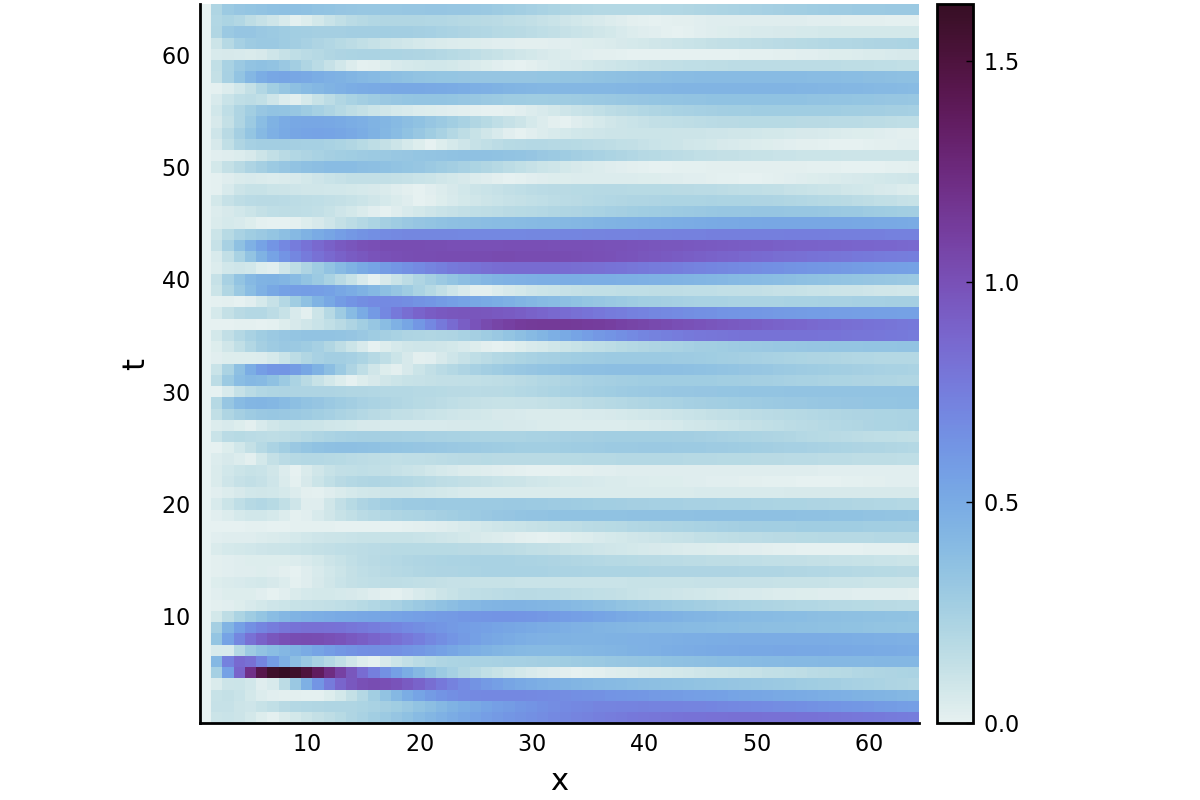

In [71]:
GraphicTools.show_err(hcat(u_pred.u...), u, "")

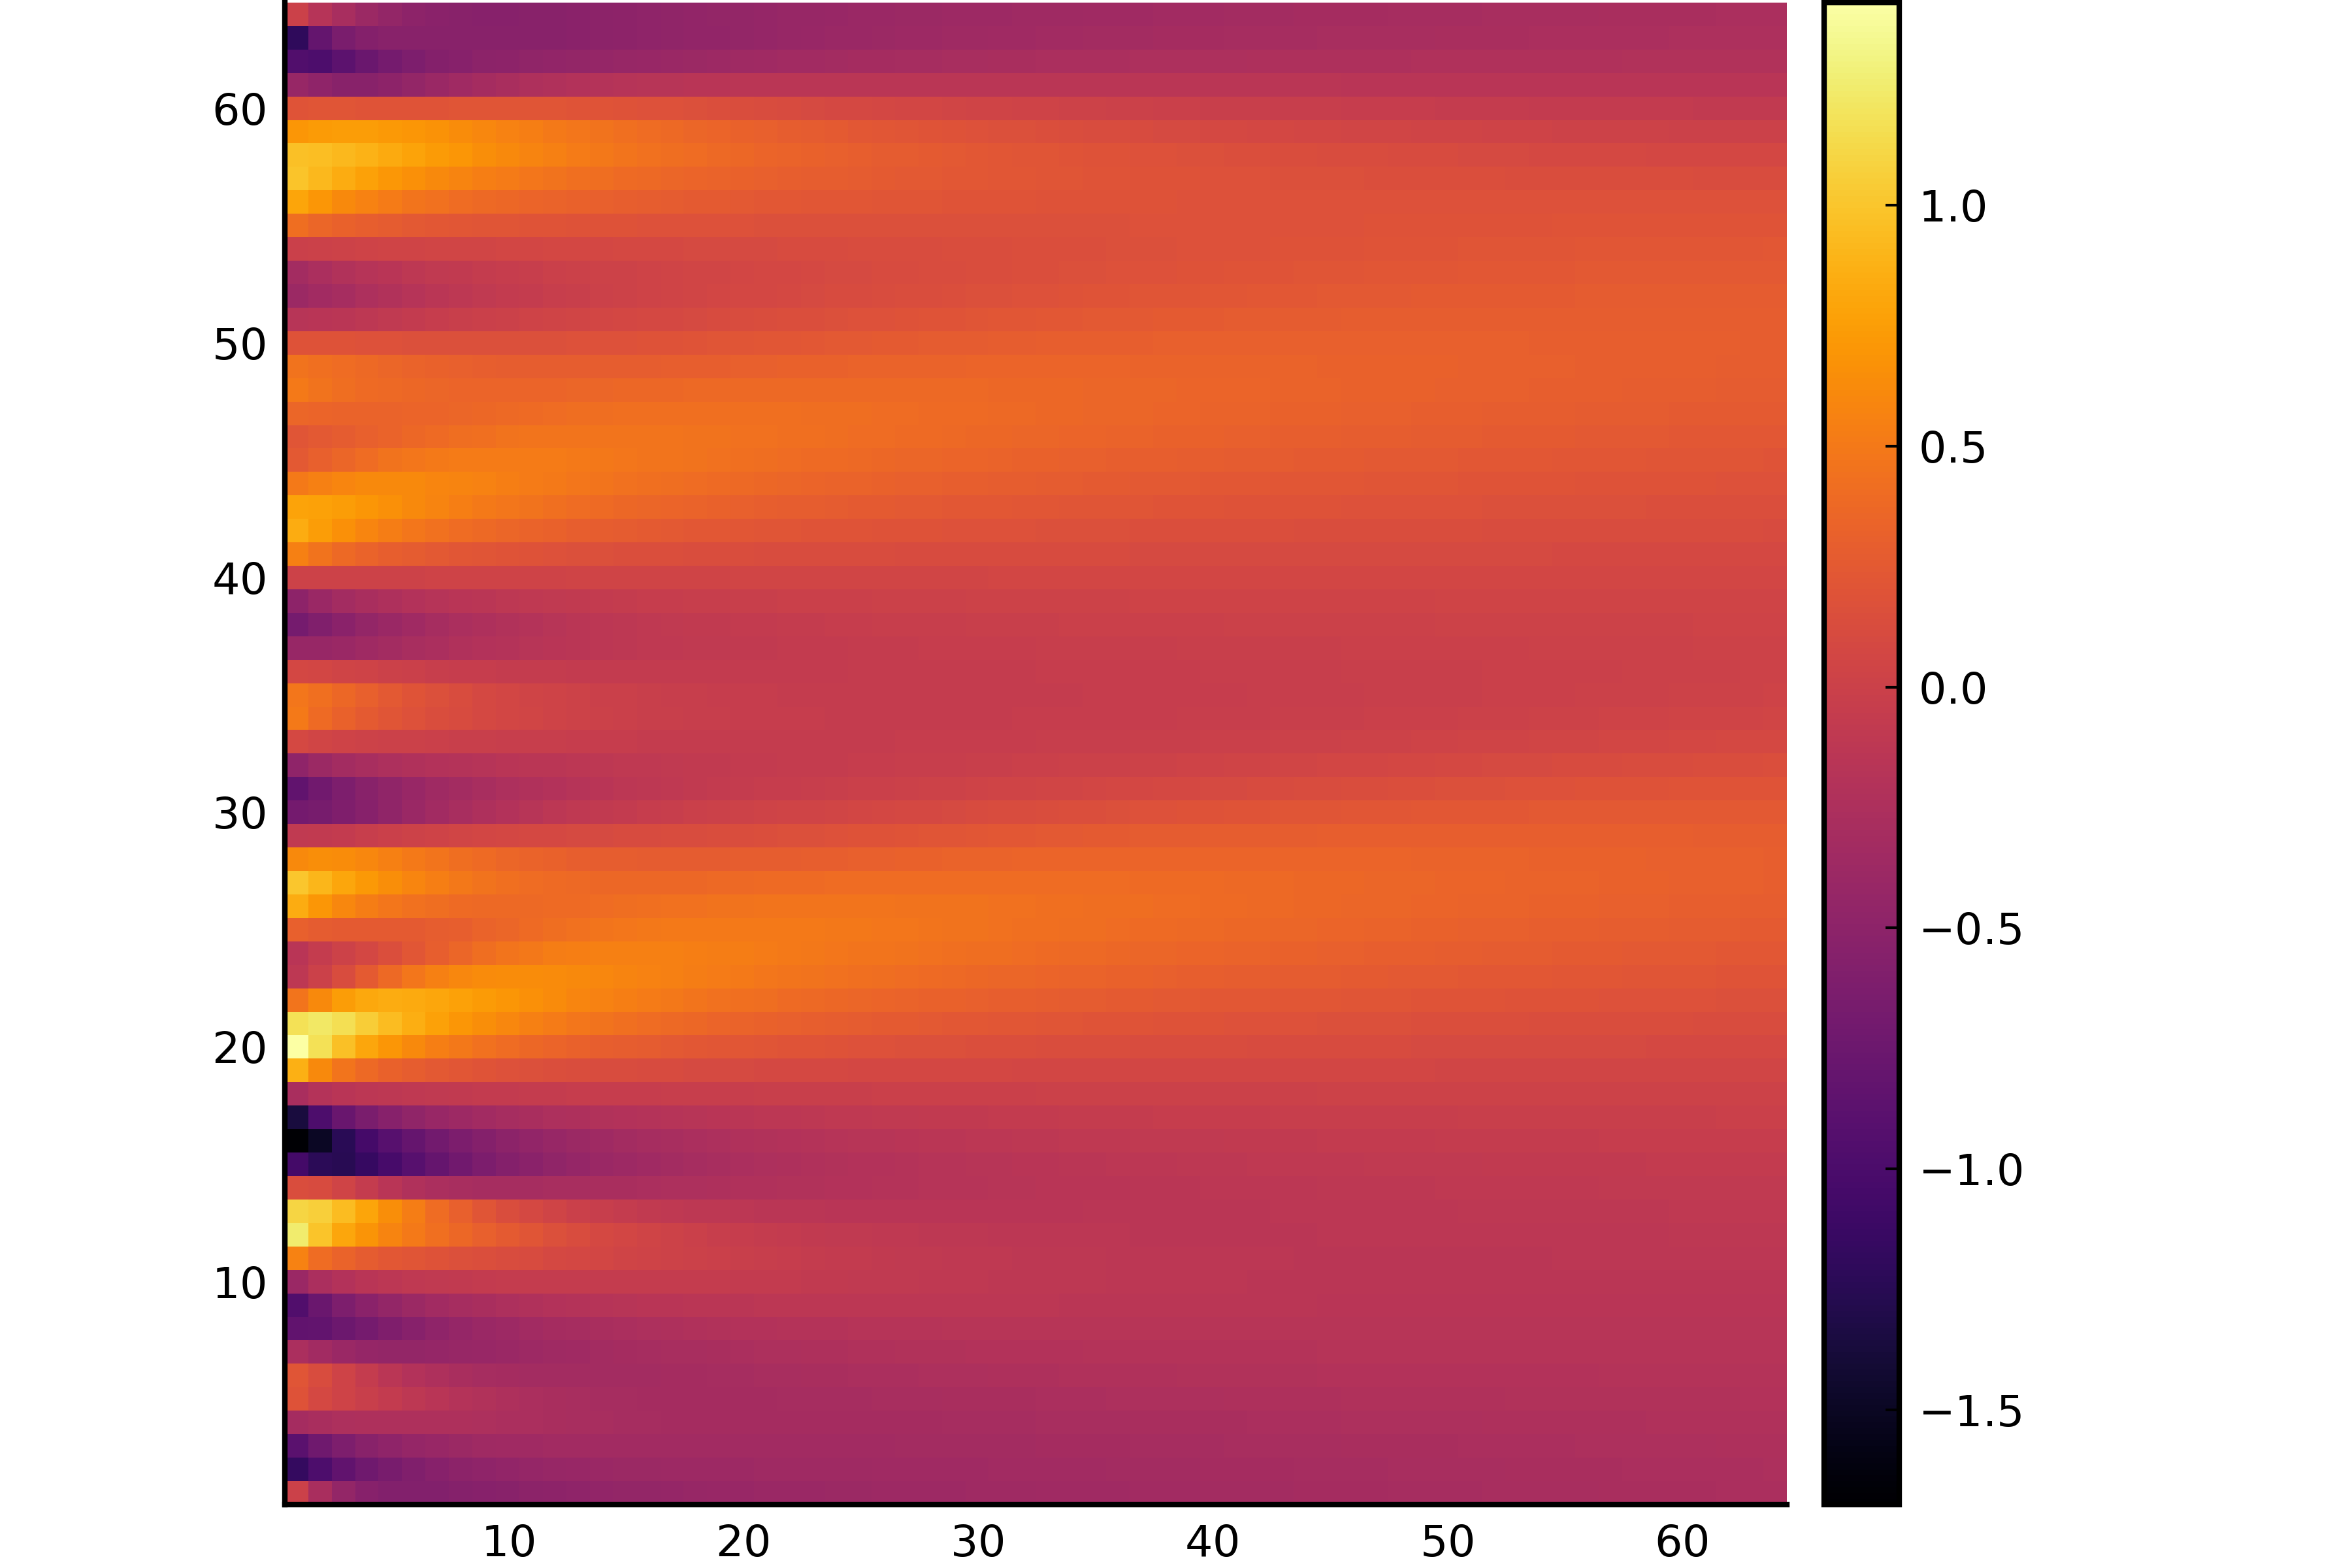

In [59]:
GraphicTools.show_state(u, "")

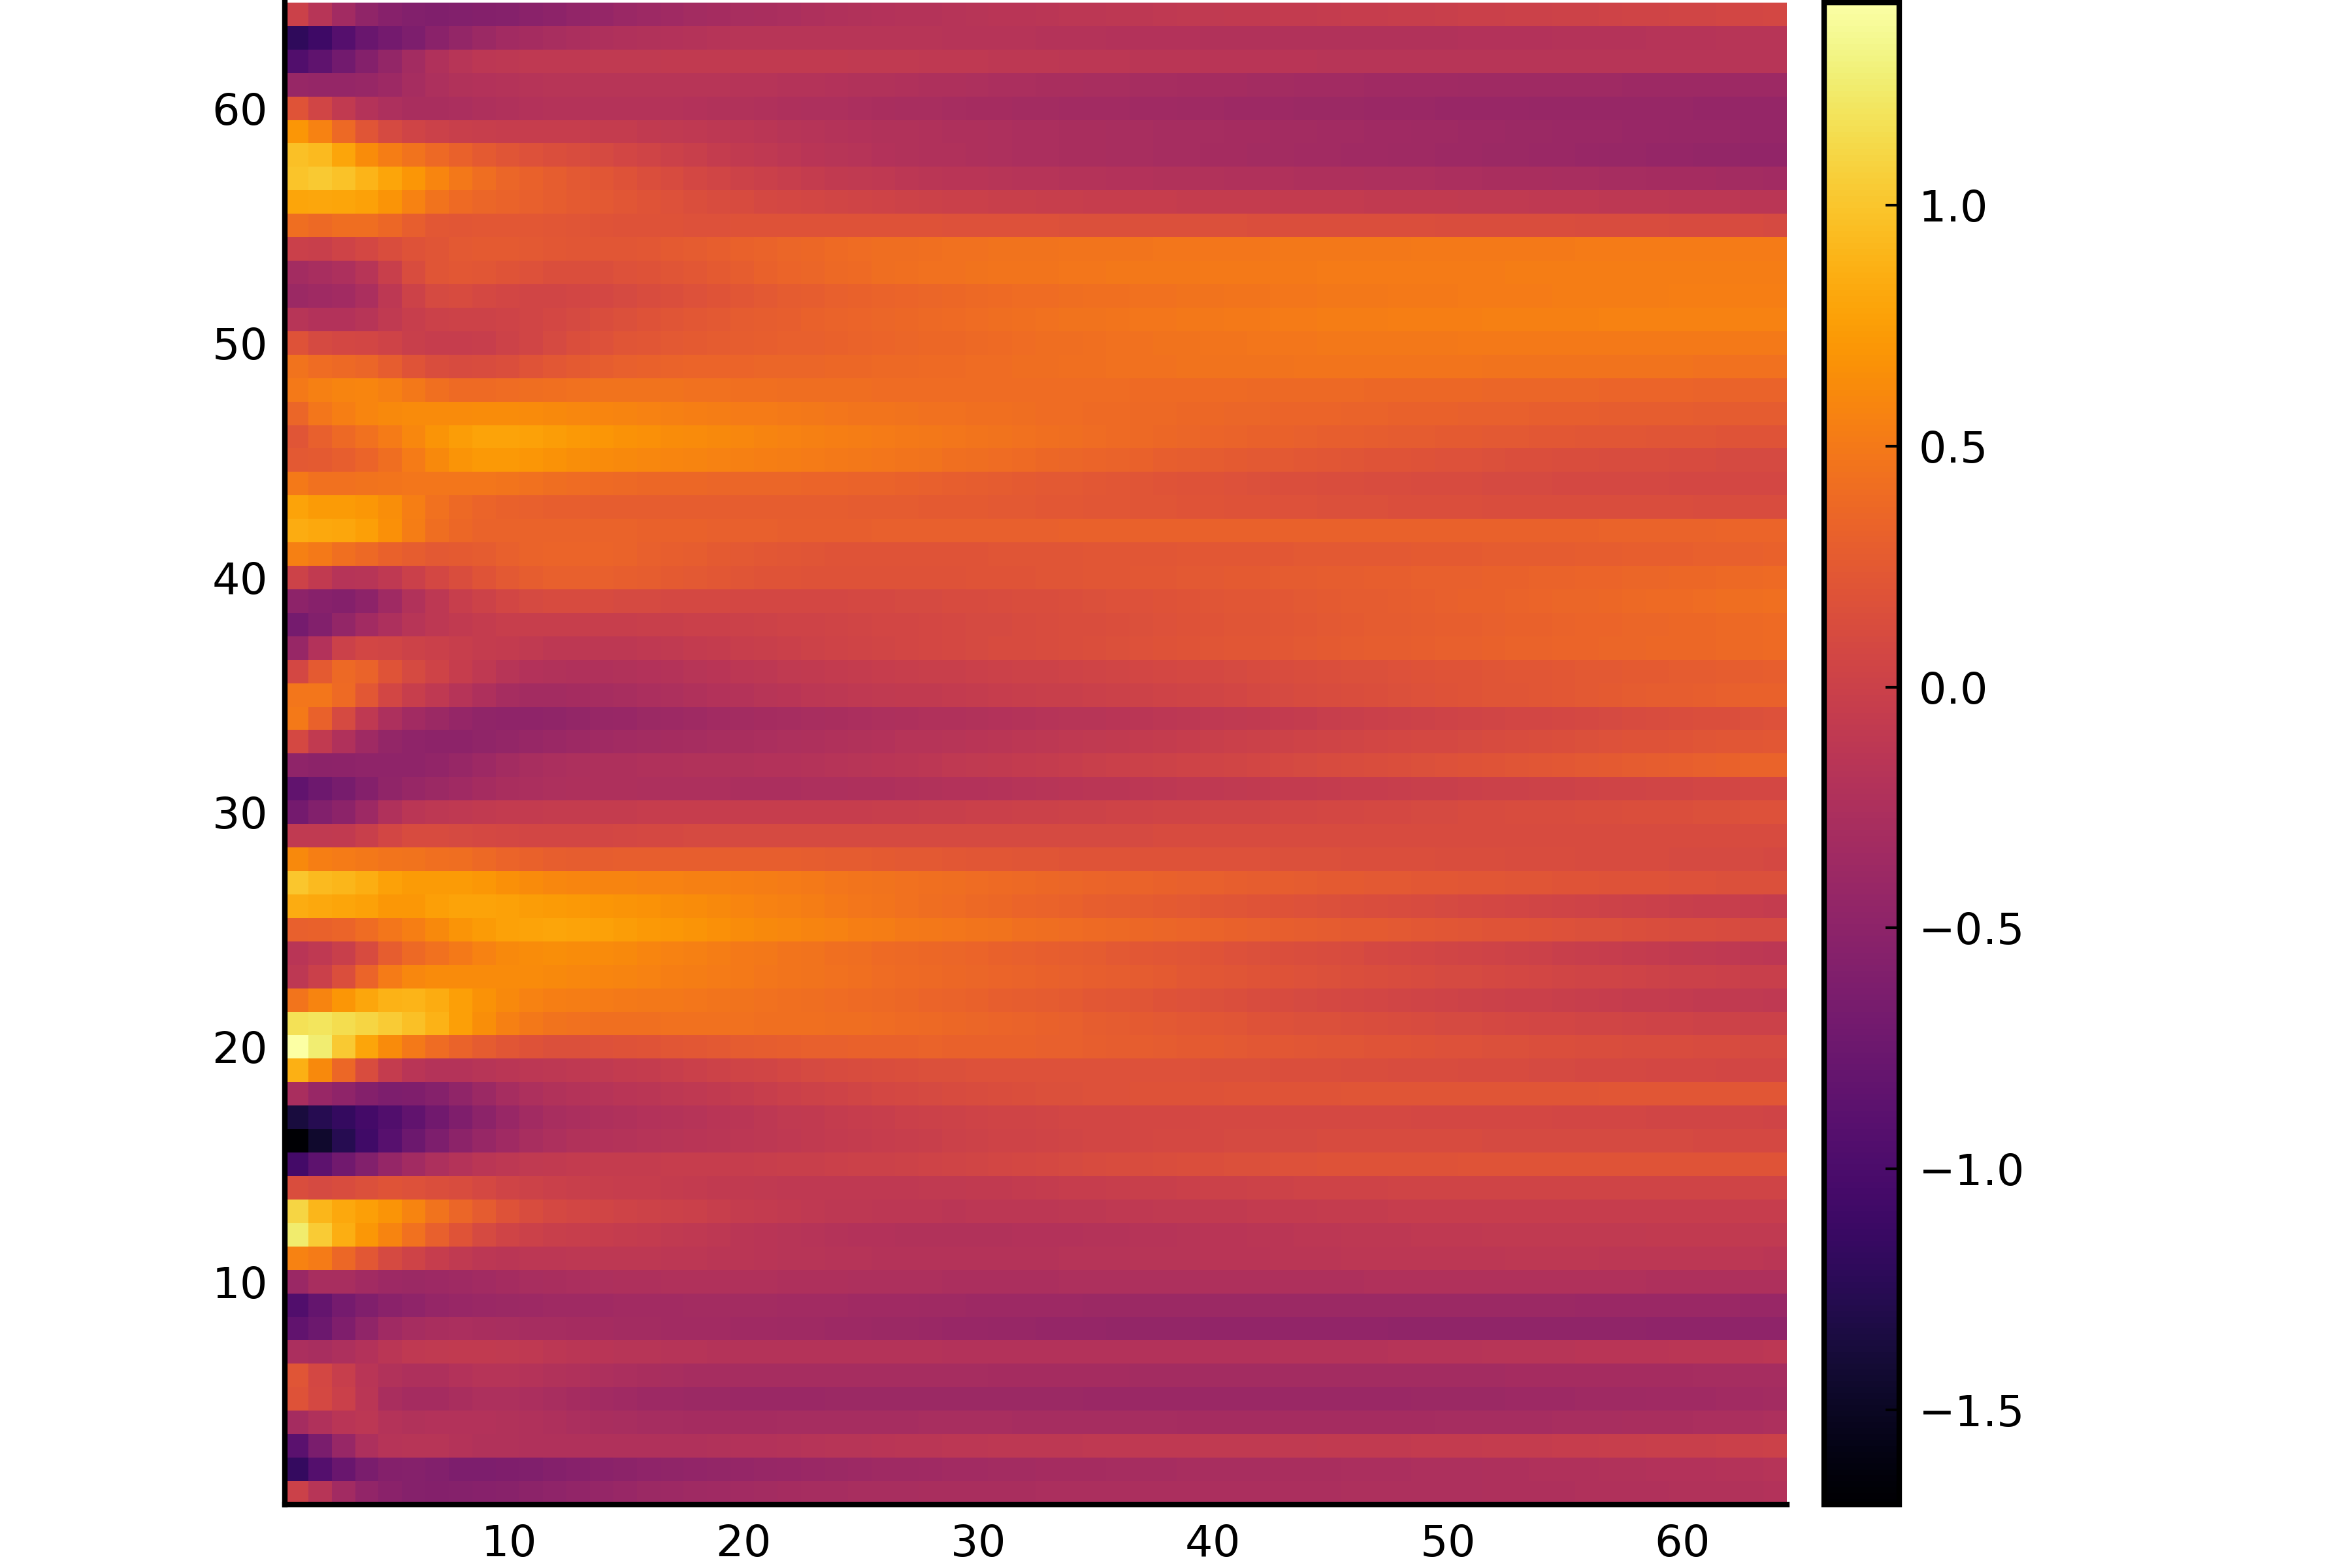

In [60]:
GraphicTools.show_state(hcat(u_pred.u...), "")

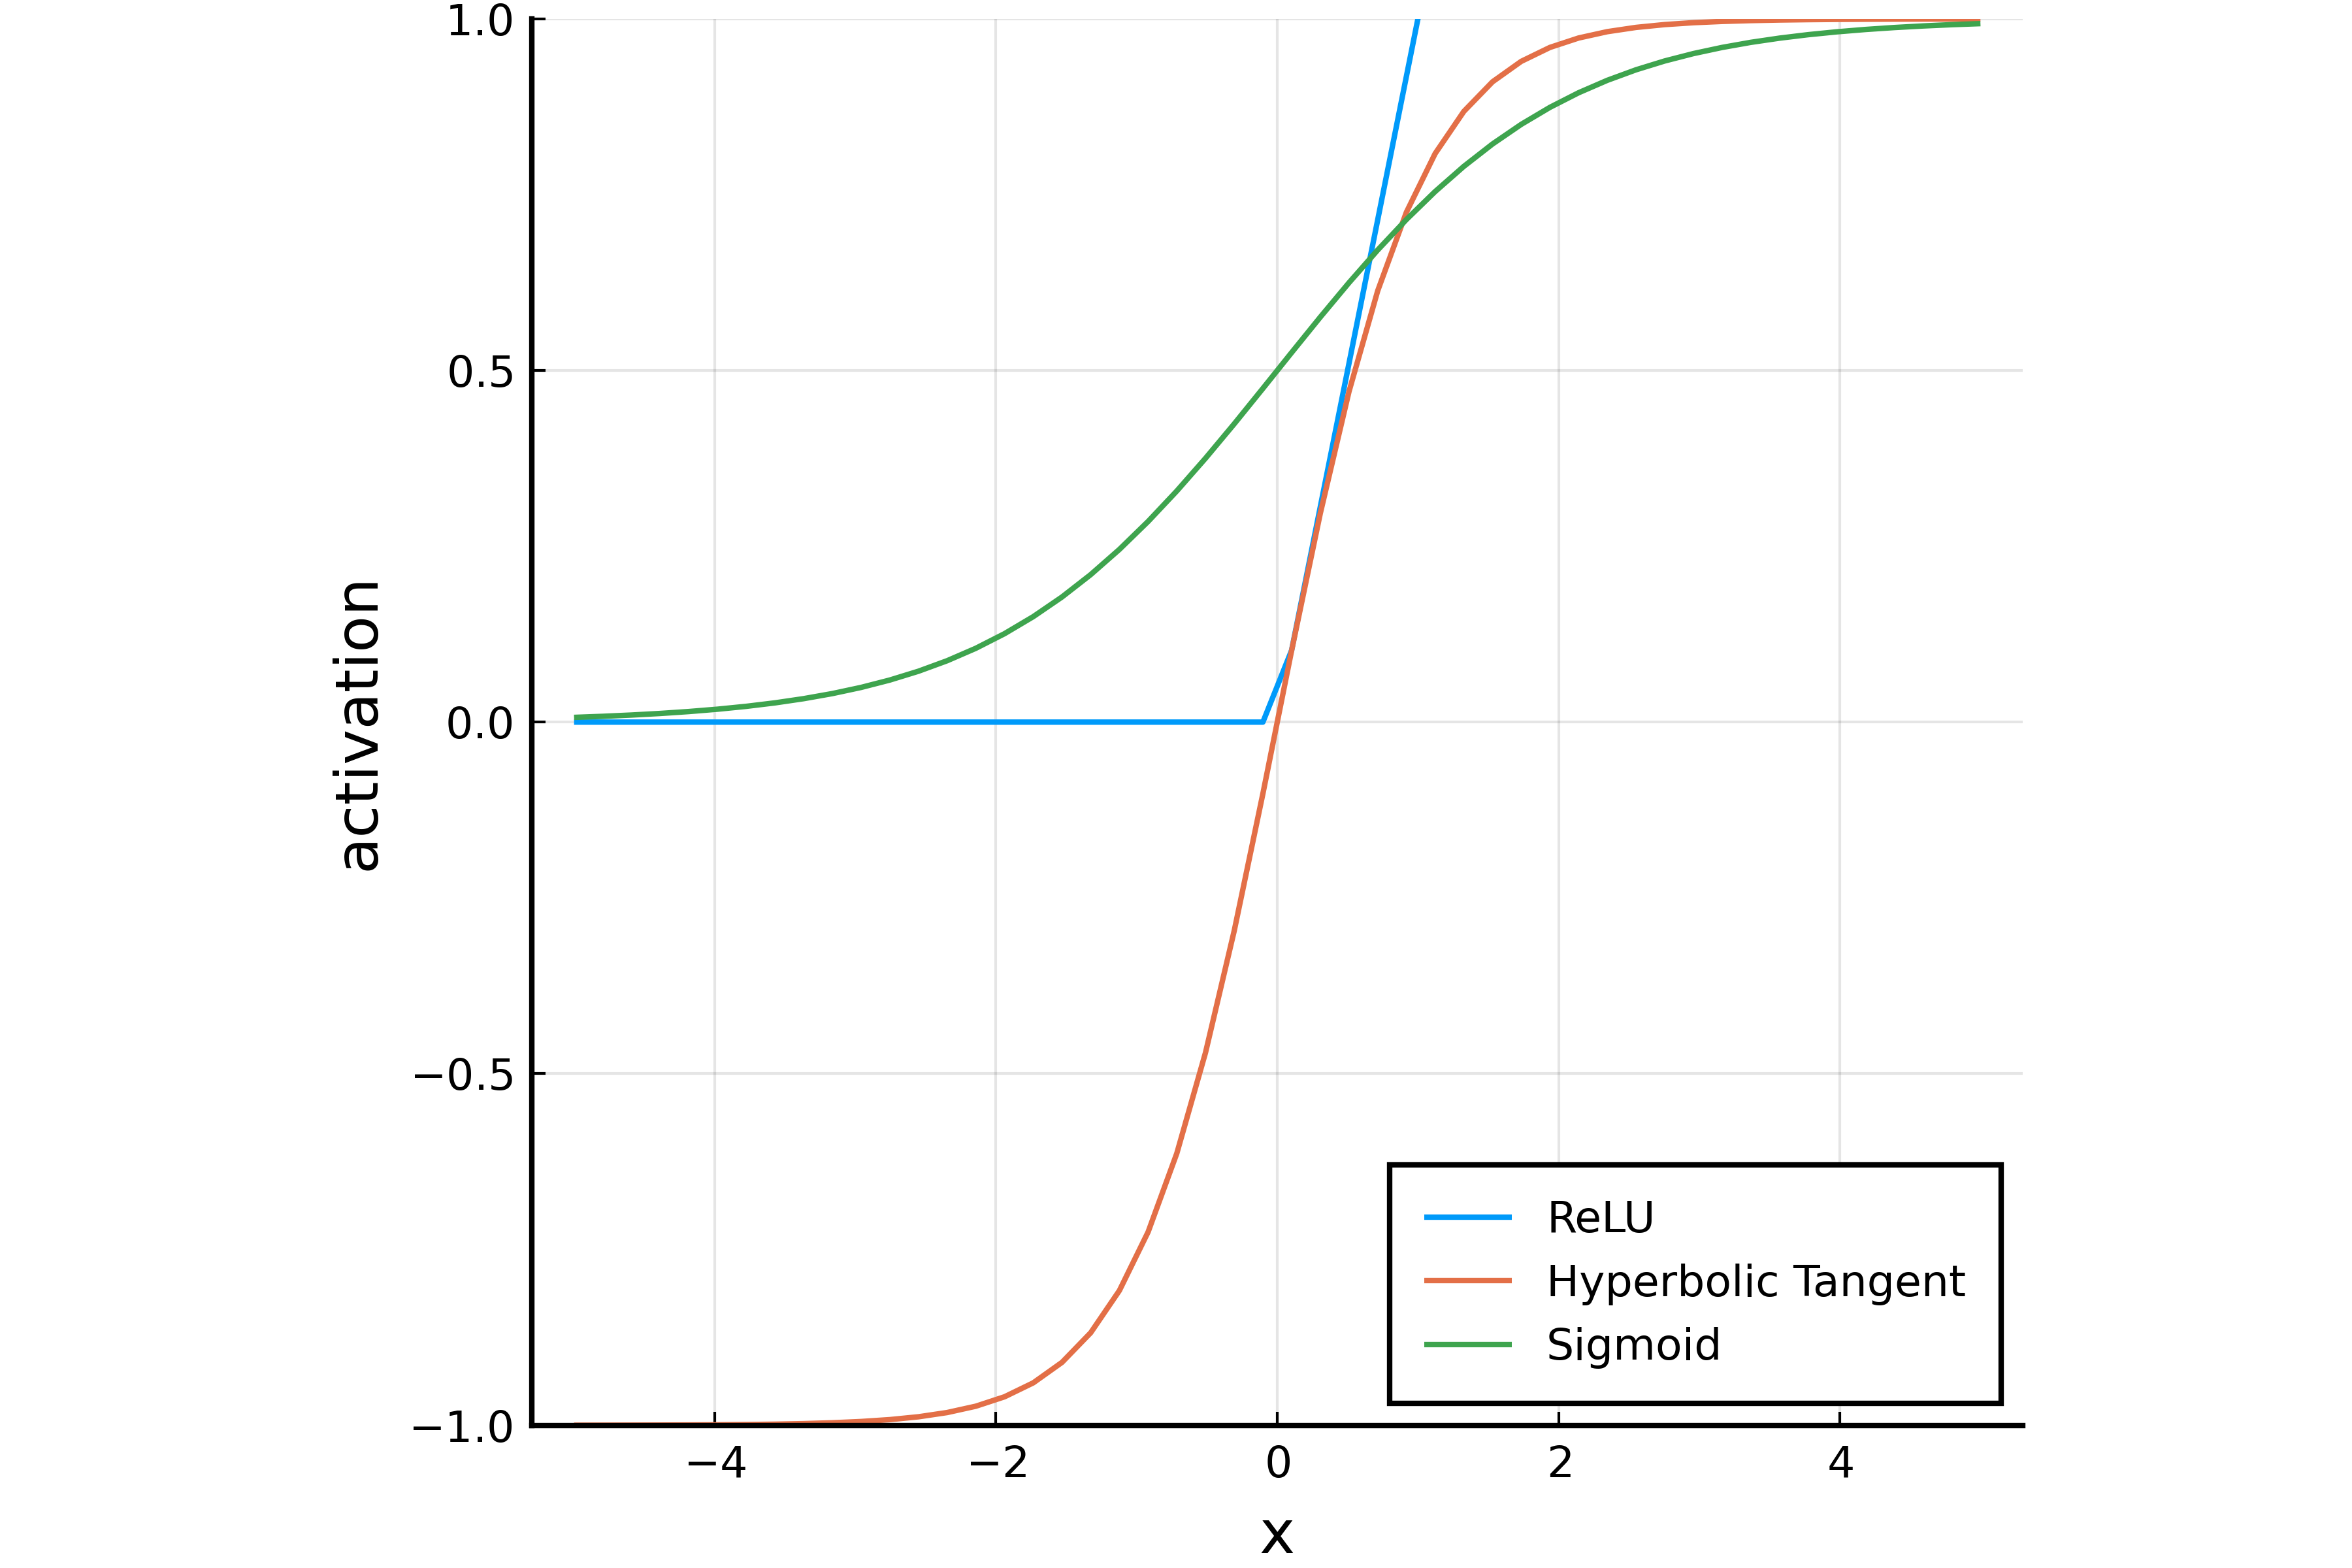

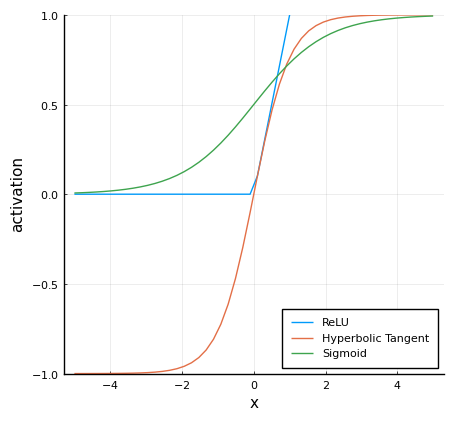

In [48]:
# ?sigmoid
# ?tanh
relu = z -> max.(0., z);
x = collect(LinRange(-5, 5, 50));

plt = plot(x, relu(x), label="ReLU")
plot!(plt, x, tanh.(x), label="Hyperbolic Tangent")
plot!(plt, x, sigmoid.(x), label="Sigmoid")
plot!(plt; dpi=600, xlabel="x", ylabel="activation", ylims=(-1, 1), ratio=5, legend=:bottomright)
display(plt)